In [ ]:
import sys
sys.path.append('../')

In [ ]:
from rumboost.utils import *
from rumboost.utility_smoothing import *
from rumboost.rumboost import *
from rumboost.dataset import *
from rumboost.models import *
from rumboost.utility_plotting import *
from rumboost.post_process import *

import lightgbm

# Example: Utility smoothing and VoT

This notebook shows features implemented in RUMBoost through an example on the LPMC dataset, a mode choice dataset in London developed Hillel et al. (2018). You can find the original source of data [here](https://www.icevirtuallibrary.com/doi/suppl/10.1680/jsmic.17.00018) and the original paper [here](https://www.icevirtuallibrary.com/doi/full/10.1680/jsmic.17.00018).

We first load the preprocessed dataset and its folds for cross-validation. You can find the data under the Data folder

In [ ]:
#load dataset
LPMC_train, LPMC_test, folds = load_preprocess_LPMC()

#load model
LPMC_model = LPMC(LPMC_train)

## Utility smoothing

The utility is smoothed using piece-wise cubic hermite splines. Each spline are linked through knots where they have equal values and derivatives. The number of knots is treated as a hyperparameter and is optimised with hyperopt, while their positions are locally optimised using a local optimizer (scipy.minimize). In this example, for computational purposes, the optimal number of knots is taken from a previous hyperparameter search and only their position is optimized. Note that the code used for the hyperparameter search is in comments, and it is possible to use it by uncommenting the appropriate lines.

### Training of a RUMBoost model

As smoothing is a post-processing tool, we first need to train a RUMBoost model. Therefore, we train the final model from the example simple_rumboost.

In [ ]:
#parameters
params = {'n_jobs': -1,
          'num_classes':4, #important
          'objective':'multiclass',
          'boosting': 'gbdt',
          'monotone_constraints_method': 'advanced',
          'verbosity': -1,
          'num_iterations':1276,
          'early_stopping_round':100,
          'learning_rate':0.1,
          'max_depth':1 #important to let it at 1 so that the model can split on many different features.
          }

#rum_structure dictionary
rum_structure = bio_to_rumboost(LPMC_model)

#features and label column names
features = [f for f in LPMC_train.columns if f != "choice"]
label = "choice"

#create lightgbm dataset
lgb_train_set = lightgbm.Dataset(LPMC_train[features], label=LPMC_train[label], free_raw_data=False)
lgb_test_set = lightgbm.Dataset(LPMC_test[features], label=LPMC_test[label], free_raw_data=False)

#train the model
LPMC_model_fully_trained = rum_train(params, lgb_train_set, rum_structure)

#predicts classes on test set
preds = LPMC_model_fully_trained.predict(lgb_test_set)

#compute cross entropy on the test set
ce_test = cross_entropy(preds, lgb_test_set.get_label().astype(int))

print('-'*50)
print(f'Final negative cross-entropy on the test set: {ce_test}')

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\rumboost.py:825: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Finished loading model, total used 1276 iterations
Finished loading model, total used 1276 iterations
Finished loading model, total used 1276 iterations
Finished loading model, total used 1276 iterations
--------------------------------------------------
Final negative cross-entropy on the test set: 0.6736637302293347


### Hyperparameter search: optimal number of knots

The optimal number of knots is found with hyperopt. For computational purposes we show here only one iteration, but we ran that code with 25 iterations for the paper. Given a number of knots, the optimal positions of knots can be found with the ```optimal_knots_position()``` function.

In [ ]:
import hyperopt
# param_space = {'0':{'distance': hyperopt.pyll.scope.int(hyperopt.hp.quniform('distance_0', 3, 7,1)),
#                     'dur_walking': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_walking', 3, 7,1))},
#             '1':{'distance': hyperopt.pyll.scope.int(hyperopt.hp.quniform('distance_1', 3, 7,1)),
#                     'dur_cycling': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_cycling', 3, 7,1))},
#             '2':{'cost_transit': hyperopt.pyll.scope.int(hyperopt.hp.quniform('cost_transit', 3, 7,1)),
#                     #'distance': hyperopt.pyll.scope.int(hyperopt.hp.quniform('distance_2', 3, 7,1)),
#                     'dur_pt_access': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_pt_access', 3, 7,1)),
#                     'dur_pt_bus': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_pt_bus', 3, 7,1)),
#                     'dur_pt_int_waiting': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_pt_int_waiting', 3, 7,1)),
#                     'dur_pt_int_walking': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_pt_int_walking', 3, 7,1)),
#                     'dur_pt_rail': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_pt_rail', 3, 7,1))},
#             '3':{'cost_driving_fuel': hyperopt.pyll.scope.int(hyperopt.hp.quniform('cost_driving_fuel', 3, 7,1)),
#                     'distance': hyperopt.pyll.scope.int(hyperopt.hp.quniform('distance_3', 3, 7,1)),
#                     'driving_traffic_percent': hyperopt.pyll.scope.int(hyperopt.hp.quniform('driving_traffic_percent', 3, 7,1)),
#                     'dur_driving': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_driving', 3, 7,1))}
#                 }

#optimal number of splines (number of knots-1)
param_space = {'0':{'distance': 5,
                    'dur_walking': 5},
            '1':{'distance': 5,
                    'dur_cycling': 5},
            '2':{'cost_transit': 2,
                    #'distance': 5,
                    'dur_pt_access': 3,
                    'dur_pt_bus': 3,
                    'dur_pt_int_waiting': 7,
                    'dur_pt_int_walking': 6,
                    'dur_pt_rail': 2},
            '3':{'cost_driving_fuel': 5,
                    'distance': 3,
                    'driving_traffic_percent': 7,
                    'dur_driving': 3}
                }

Optimisation of knots position for hyperopt

In [ ]:
def objective(space):
    dataset_train, _, _ = load_preprocess_LPMC()
        
    weights = weights_to_plot_v2(LPMC_model_fully_trained)

    spline_utilities = {'0':['distance', 'dur_walking'],'1':['distance', 'dur_cycling'], '2':['distance', 'dur_pt_rail', 'dur_pt_bus', 'cost_transit', 'dur_pt_access', 'dur_pt_int_walking', 'dur_pt_int_waiting'], '3': ['distance', 'dur_driving','cost_driving_fuel', 'driving_traffic_percent']}

    target = 'choice'

    spline_collection = space

    x_opt, x_first, x_last, loss = optimal_knots_position(weights, dataset_train, dataset_train, dataset_train[target], spline_utilities, spline_collection, max_iter = 50, optimize = True, deg_freedom=True, n_iter=1)

    return {'loss': loss, 'x_opt':x_opt.x, 'status': hyperopt.STATUS_OK, 'x_first': x_first, 'x_last': x_last}

# n=25
n=1
trials = hyperopt.Trials()
best_classifier = hyperopt.fmin(fn=objective,
                                space=param_space,
                                algo=hyperopt.tpe.suggest,
                                max_evals=n,
                                trials=trials)

best_classifier['_best_loss'] = trials.best_trial['result']['loss']
best_classifier['_x_opt'] = trials.best_trial['result']['x_opt']
best_classifier['_x_first'] = trials.best_trial['result']['x_first']
best_classifier['_x_last'] = trials.best_trial['result']['x_last']

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "



Iteration limit reached    (Exit mode 9)             
            Current function value:                  
71593.47363880971                                    
            Iterations:                              
50                                                   
            Function evaluations:                    
2458                                                 
            Gradient evaluations:                    
48                                                   
1/1:71593.47363880971 with knots at: [ 0.95717964  9.02996486 22.8508837  25.37585004  0.71324514  2.17387713
  4.53771013  6.37144282  2.09579978  8.03835122 12.16538718 24.65747448
  0.31172481  0.84219135  1.40503657  2.46455405  2.53837711  0.27817017
  0.49829621  0.64287616  1.09898311  0.09167981  0.1632993   0.19485346
  0.20907956  0.33081399  0.52310831  0.04957955  0.05629823  0.06426128
  0.07350546  0.1260462   0.63490641  1.10758643  5.43315975  6.21844261
  7.00967444  7.81689716  3.73490207 20

## Testing on out-of-sample data

Given the optimal knot position, we can validate our approach by computing the cross entropy loss on out-of-sample data. 
This can vary from the value displayed in the paper due to randomness in the optimisation solver

In [ ]:
weights = weights_to_plot_v2(LPMC_model_fully_trained)

# spline_collection = {'0':{'distance': int(best_classifier['distance_0']),
#                     'dur_walking': int(best_classifier['dur_walking'])},
#             '1':{'distance': int(best_classifier['distance_1']),
#                     'dur_cycling': int(best_classifier['dur_cycling'])},
#             '2':{'cost_transit': int(best_classifier['cost_transit']),
#                     #'distance': int(best_classifier['distance_2']),
#                     'dur_pt_access': int(best_classifier['dur_pt_access']),
#                     'dur_pt_bus': int(best_classifier['dur_pt_bus']),
#                     'dur_pt_int_waiting': int(best_classifier['dur_pt_int_waiting']),
#                     'dur_pt_int_walking': int(best_classifier['dur_pt_int_walking']),
#                     'dur_pt_rail': int(best_classifier['dur_pt_rail'])},
#             '3':{'cost_driving_fuel': int(best_classifier['cost_driving_fuel']),
#                     'distance': int(best_classifier['distance_3']),
#                     'driving_traffic_percent': int(best_classifier['driving_traffic_percent']),
#                     'dur_driving': int(best_classifier['dur_driving'])}
#                 }


spline_collection = {'0':{'distance': 5,
                    'dur_walking': 5},
            '1':{'distance': 5,
                    'dur_cycling': 5},
            '2':{'cost_transit': 2,
                    #'distance': 5,
                    'dur_pt_access': 3,
                    'dur_pt_bus': 3,
                    'dur_pt_int_waiting': 7,
                    'dur_pt_int_walking': 6,
                    'dur_pt_rail': 2},
            '3':{'cost_driving_fuel': 5,
                    'distance': 3,
                    'driving_traffic_percent': 7,
                    'dur_driving': 3}
                }

spline_utilities = {'0':['distance', 'dur_walking'],'1':['distance', 'dur_cycling'], '2':['dur_pt_rail', 'dur_pt_bus', 'cost_transit', 'dur_pt_int_waiting', 'dur_pt_int_walking', 'dur_pt_access'], '3': ['distance', 'dur_driving','cost_driving_fuel', 'driving_traffic_percent']}
x_knots_dict = map_x_knots(trials.best_trial['result']['x_opt'], spline_collection, trials.best_trial['result']['x_first'], trials.best_trial['result']['x_last'])
util_collection = updated_utility_collection(weights, LPMC_train, spline_collection, spline_utilities, mean_splines=False, x_knots = x_knots_dict)

y_pred = smooth_predict(LPMC_test, util_collection)
CE_final = cross_entropy(y_pred, LPMC_test['choice'])
best_classifier['_on_test_set'] = CE_final

print(f'Smoothed final cross entropy loss: {CE_final}')

Smoothed final cross entropy loss: 0.6732300573483379


## Plotting smoothed utility functions

We can use the result to plot the utility functions.

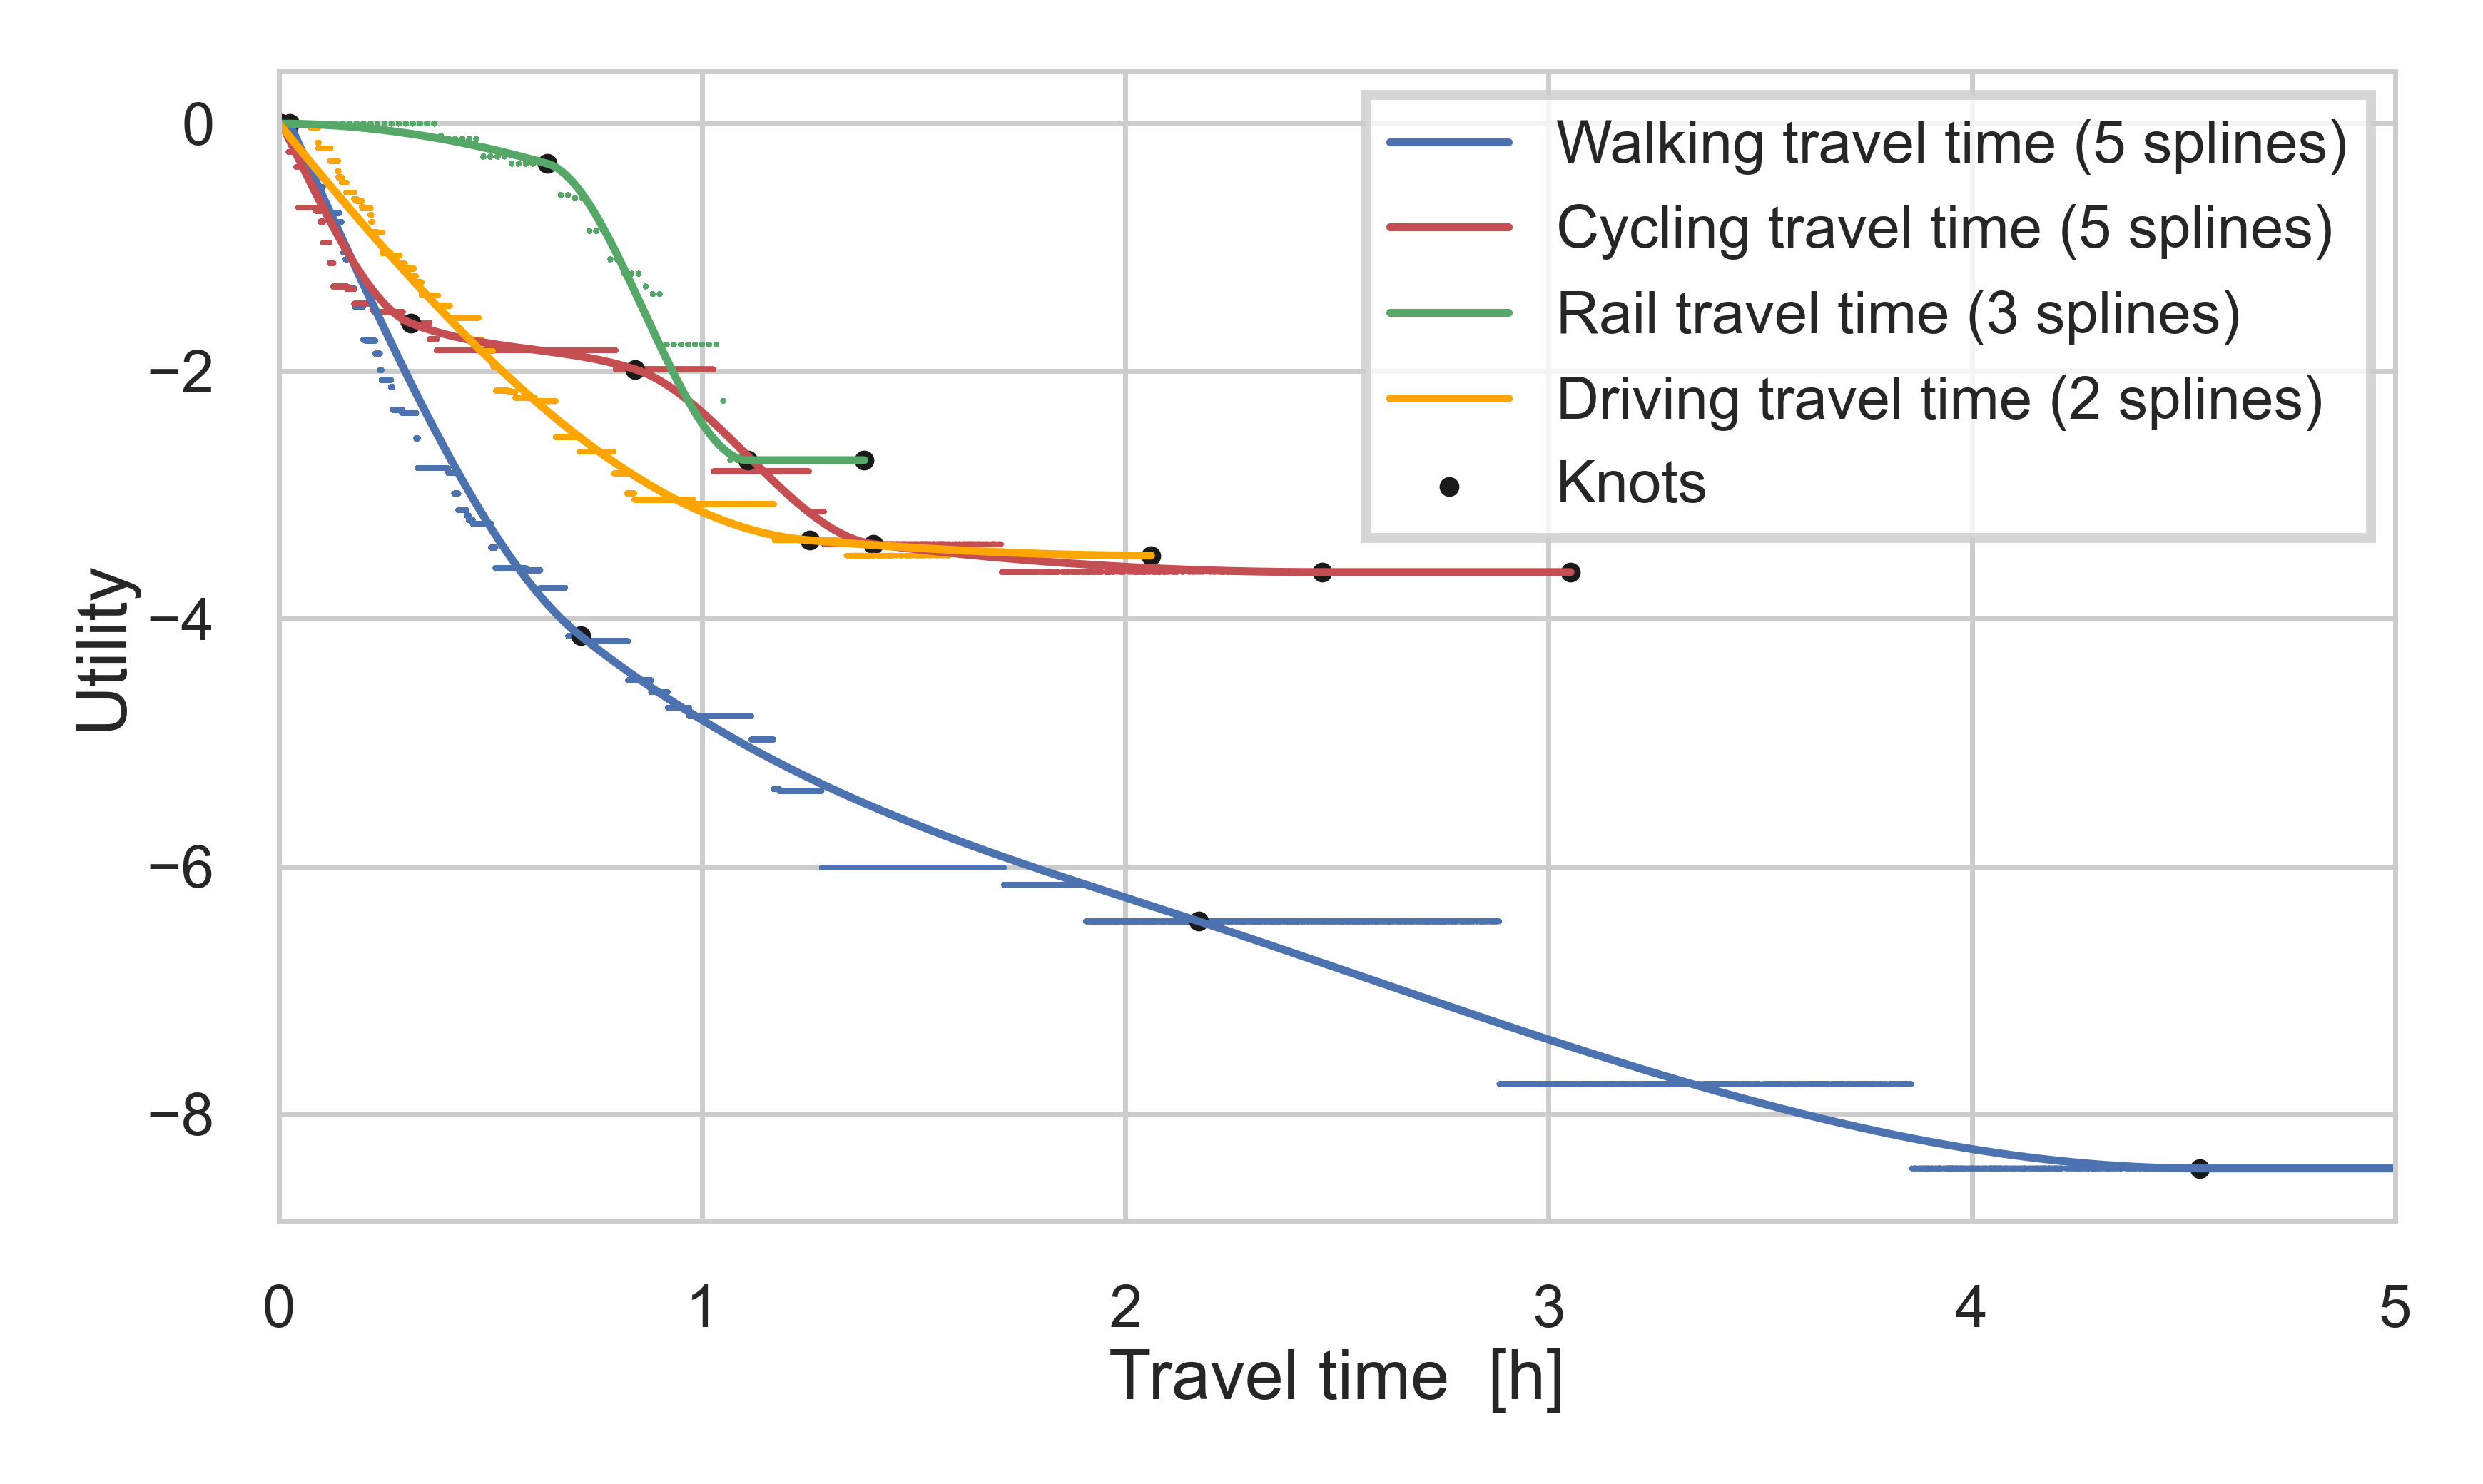

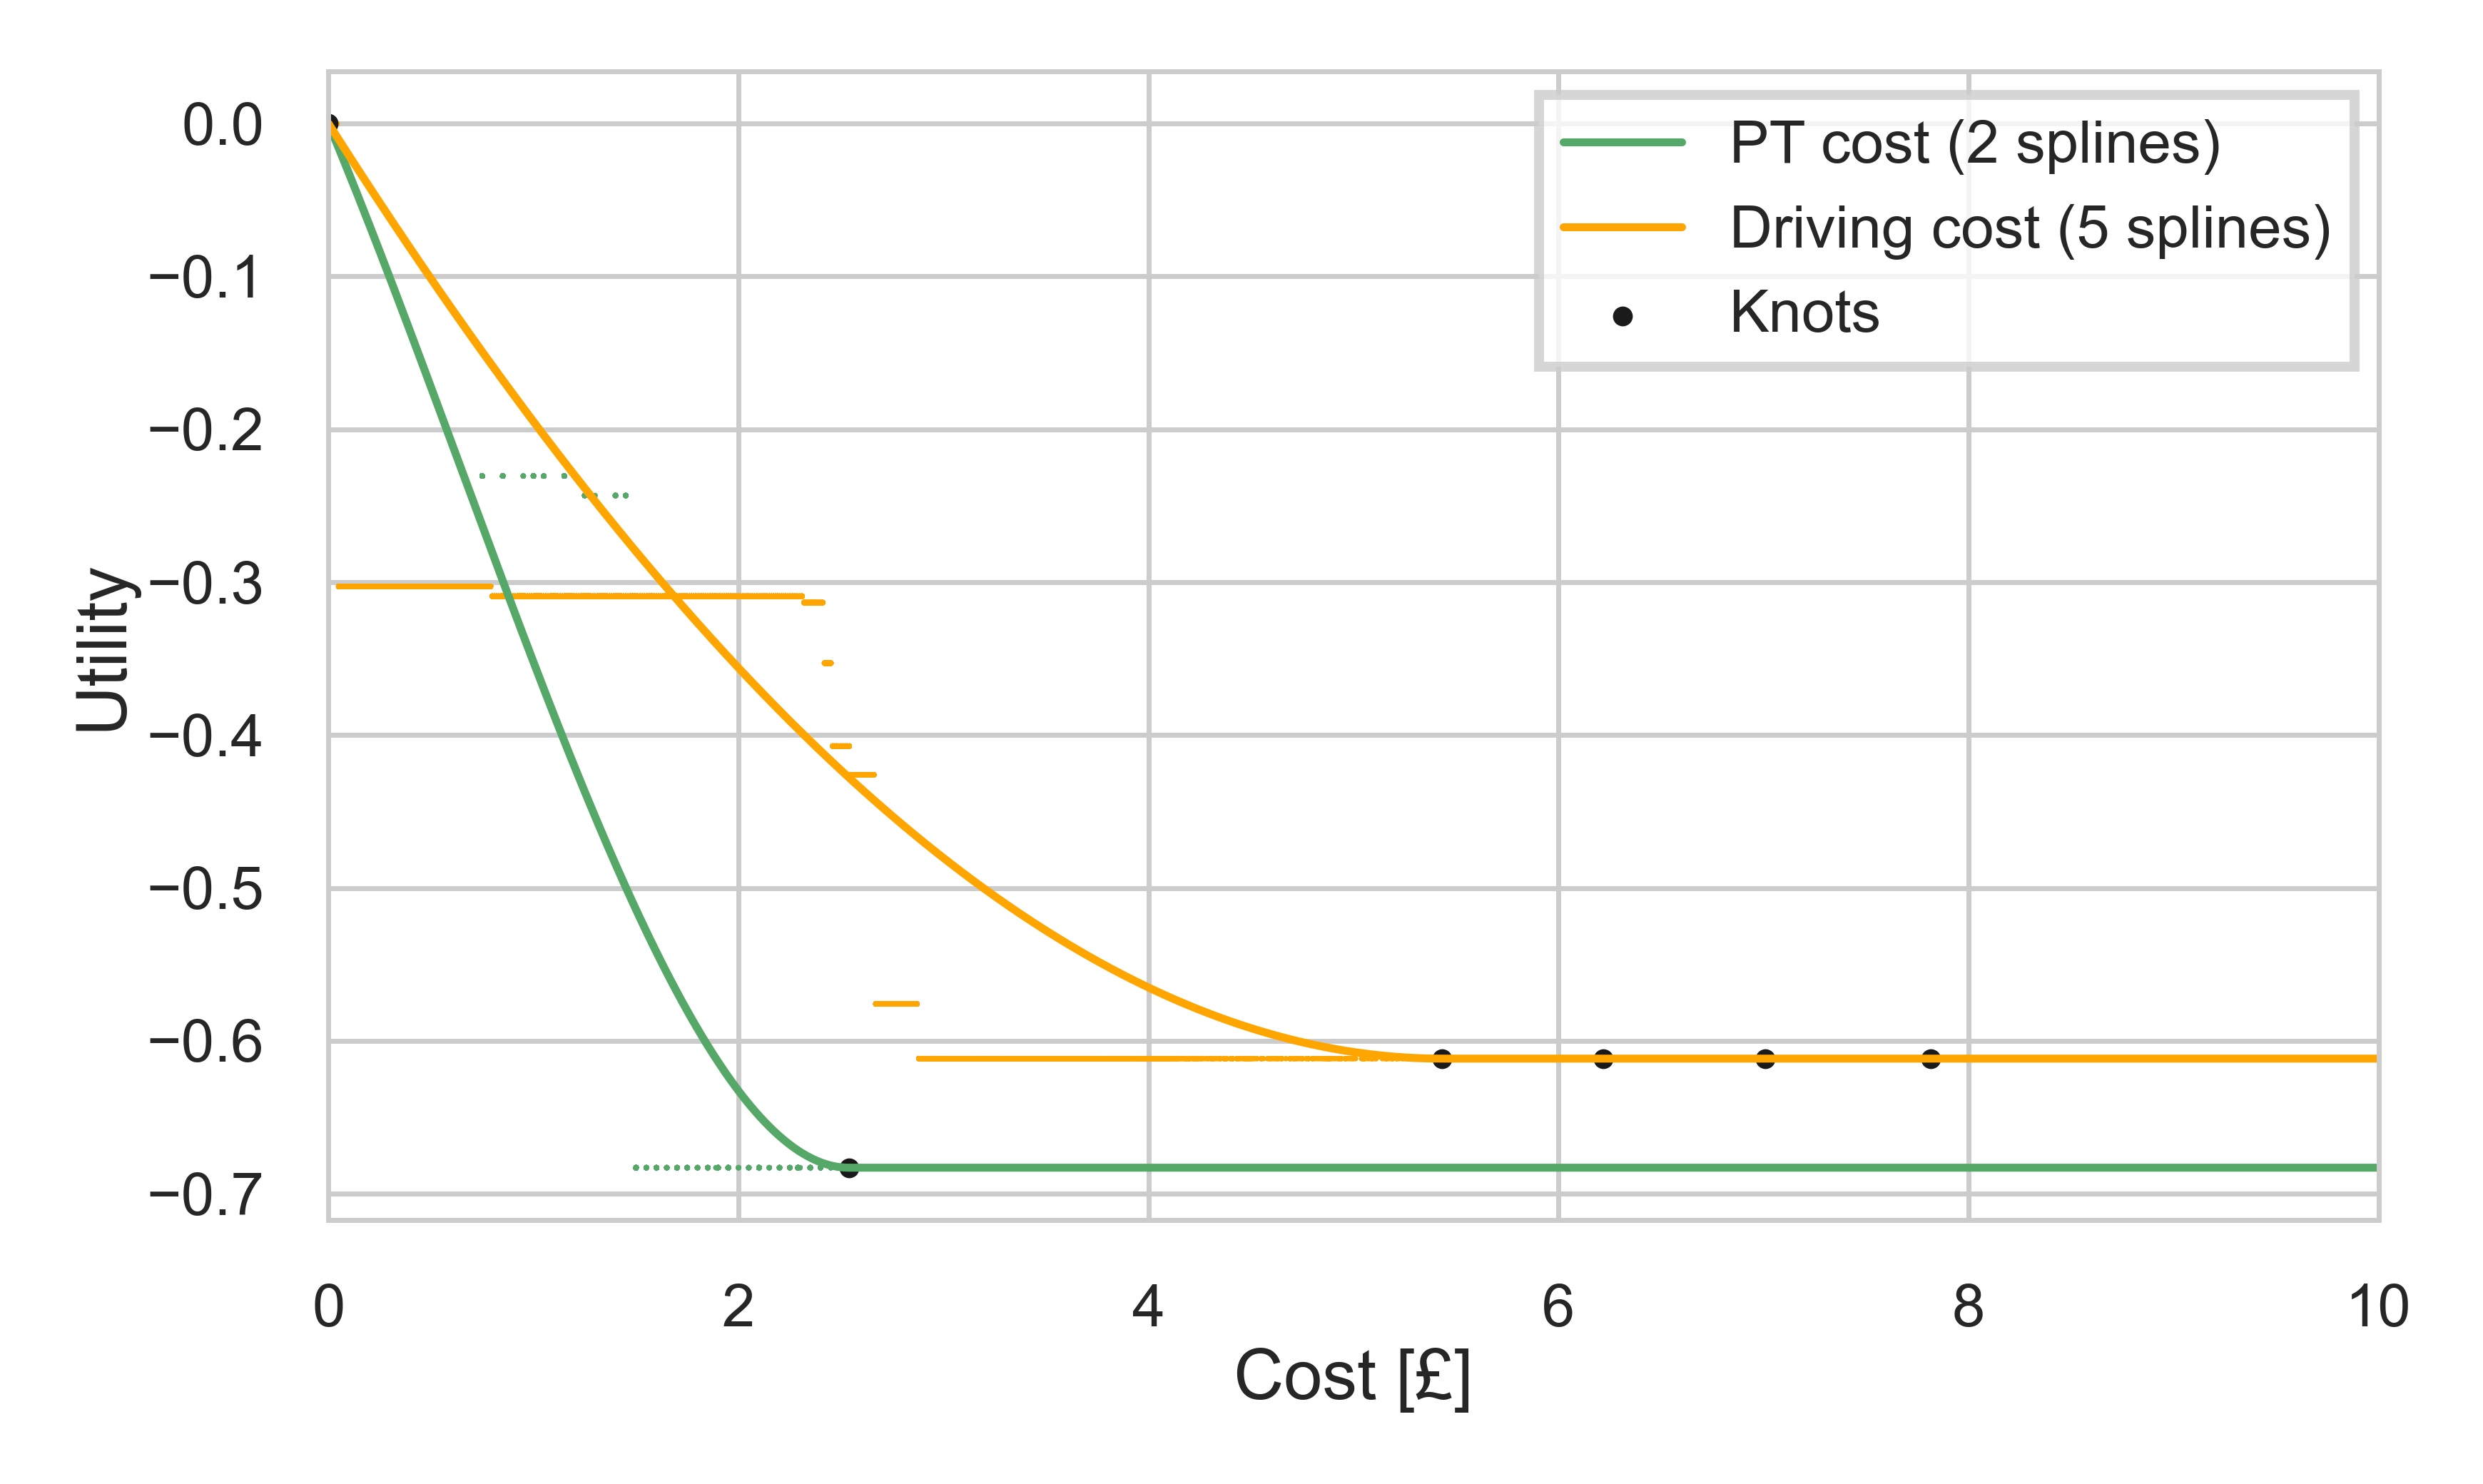

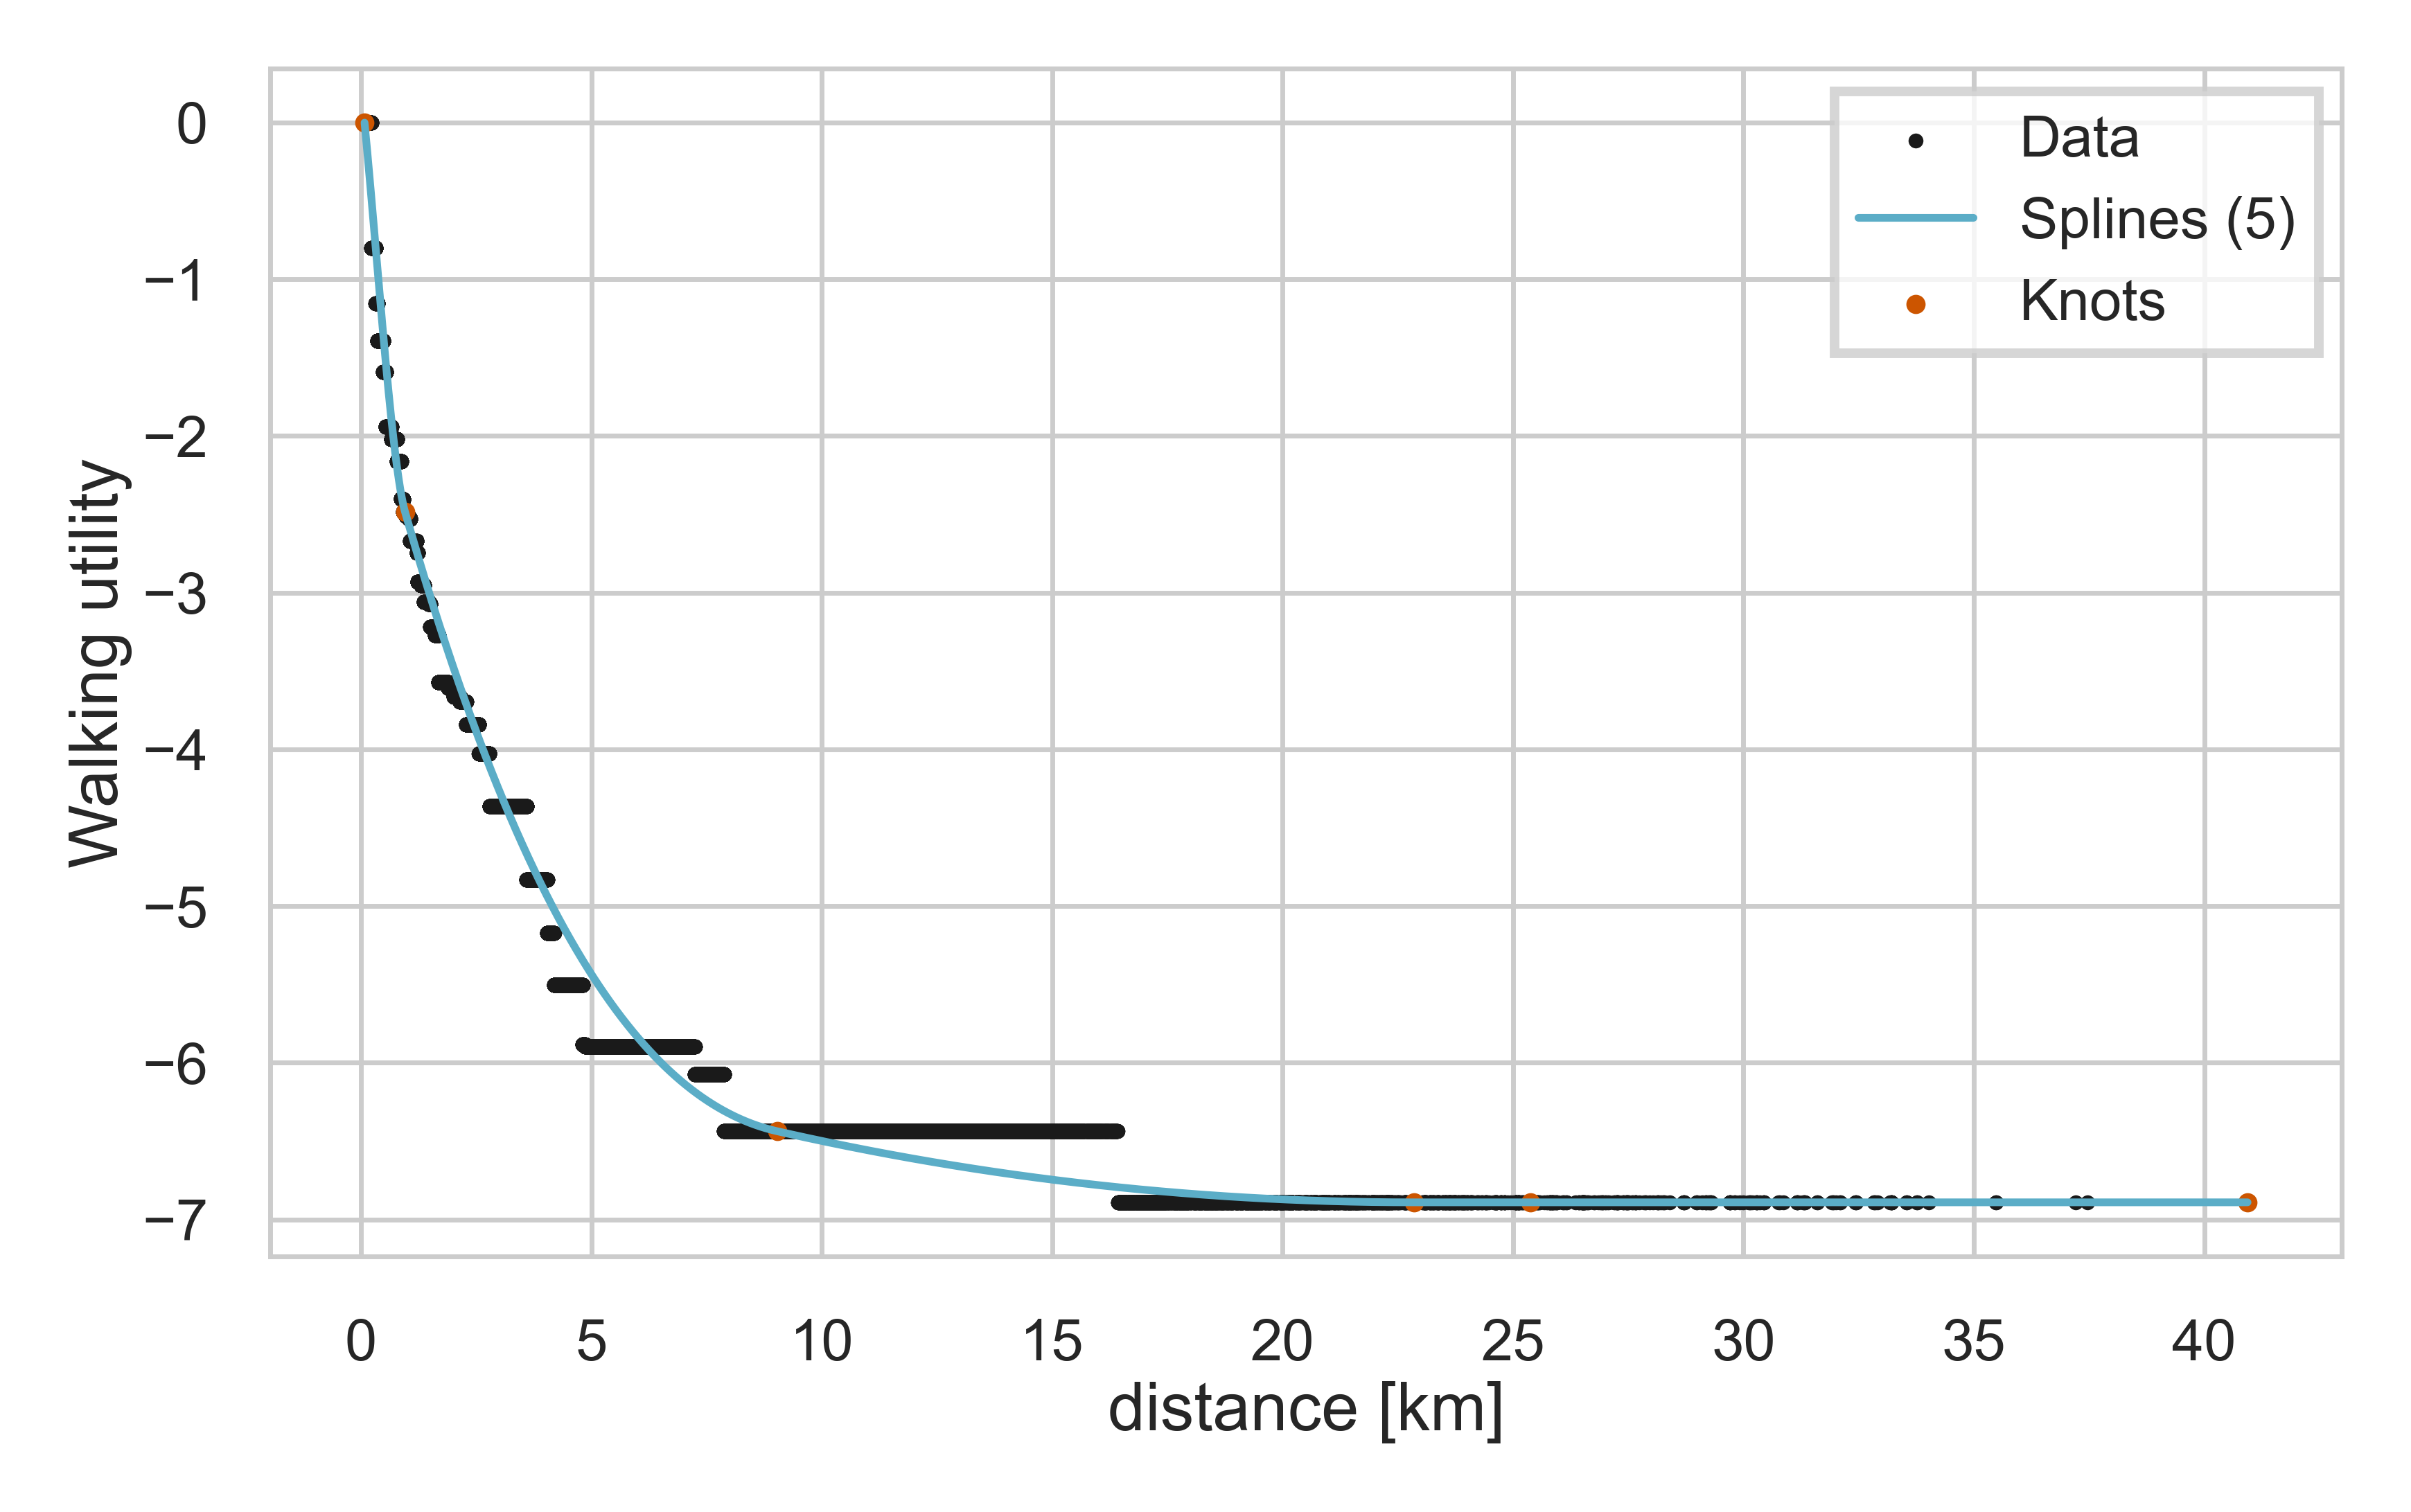

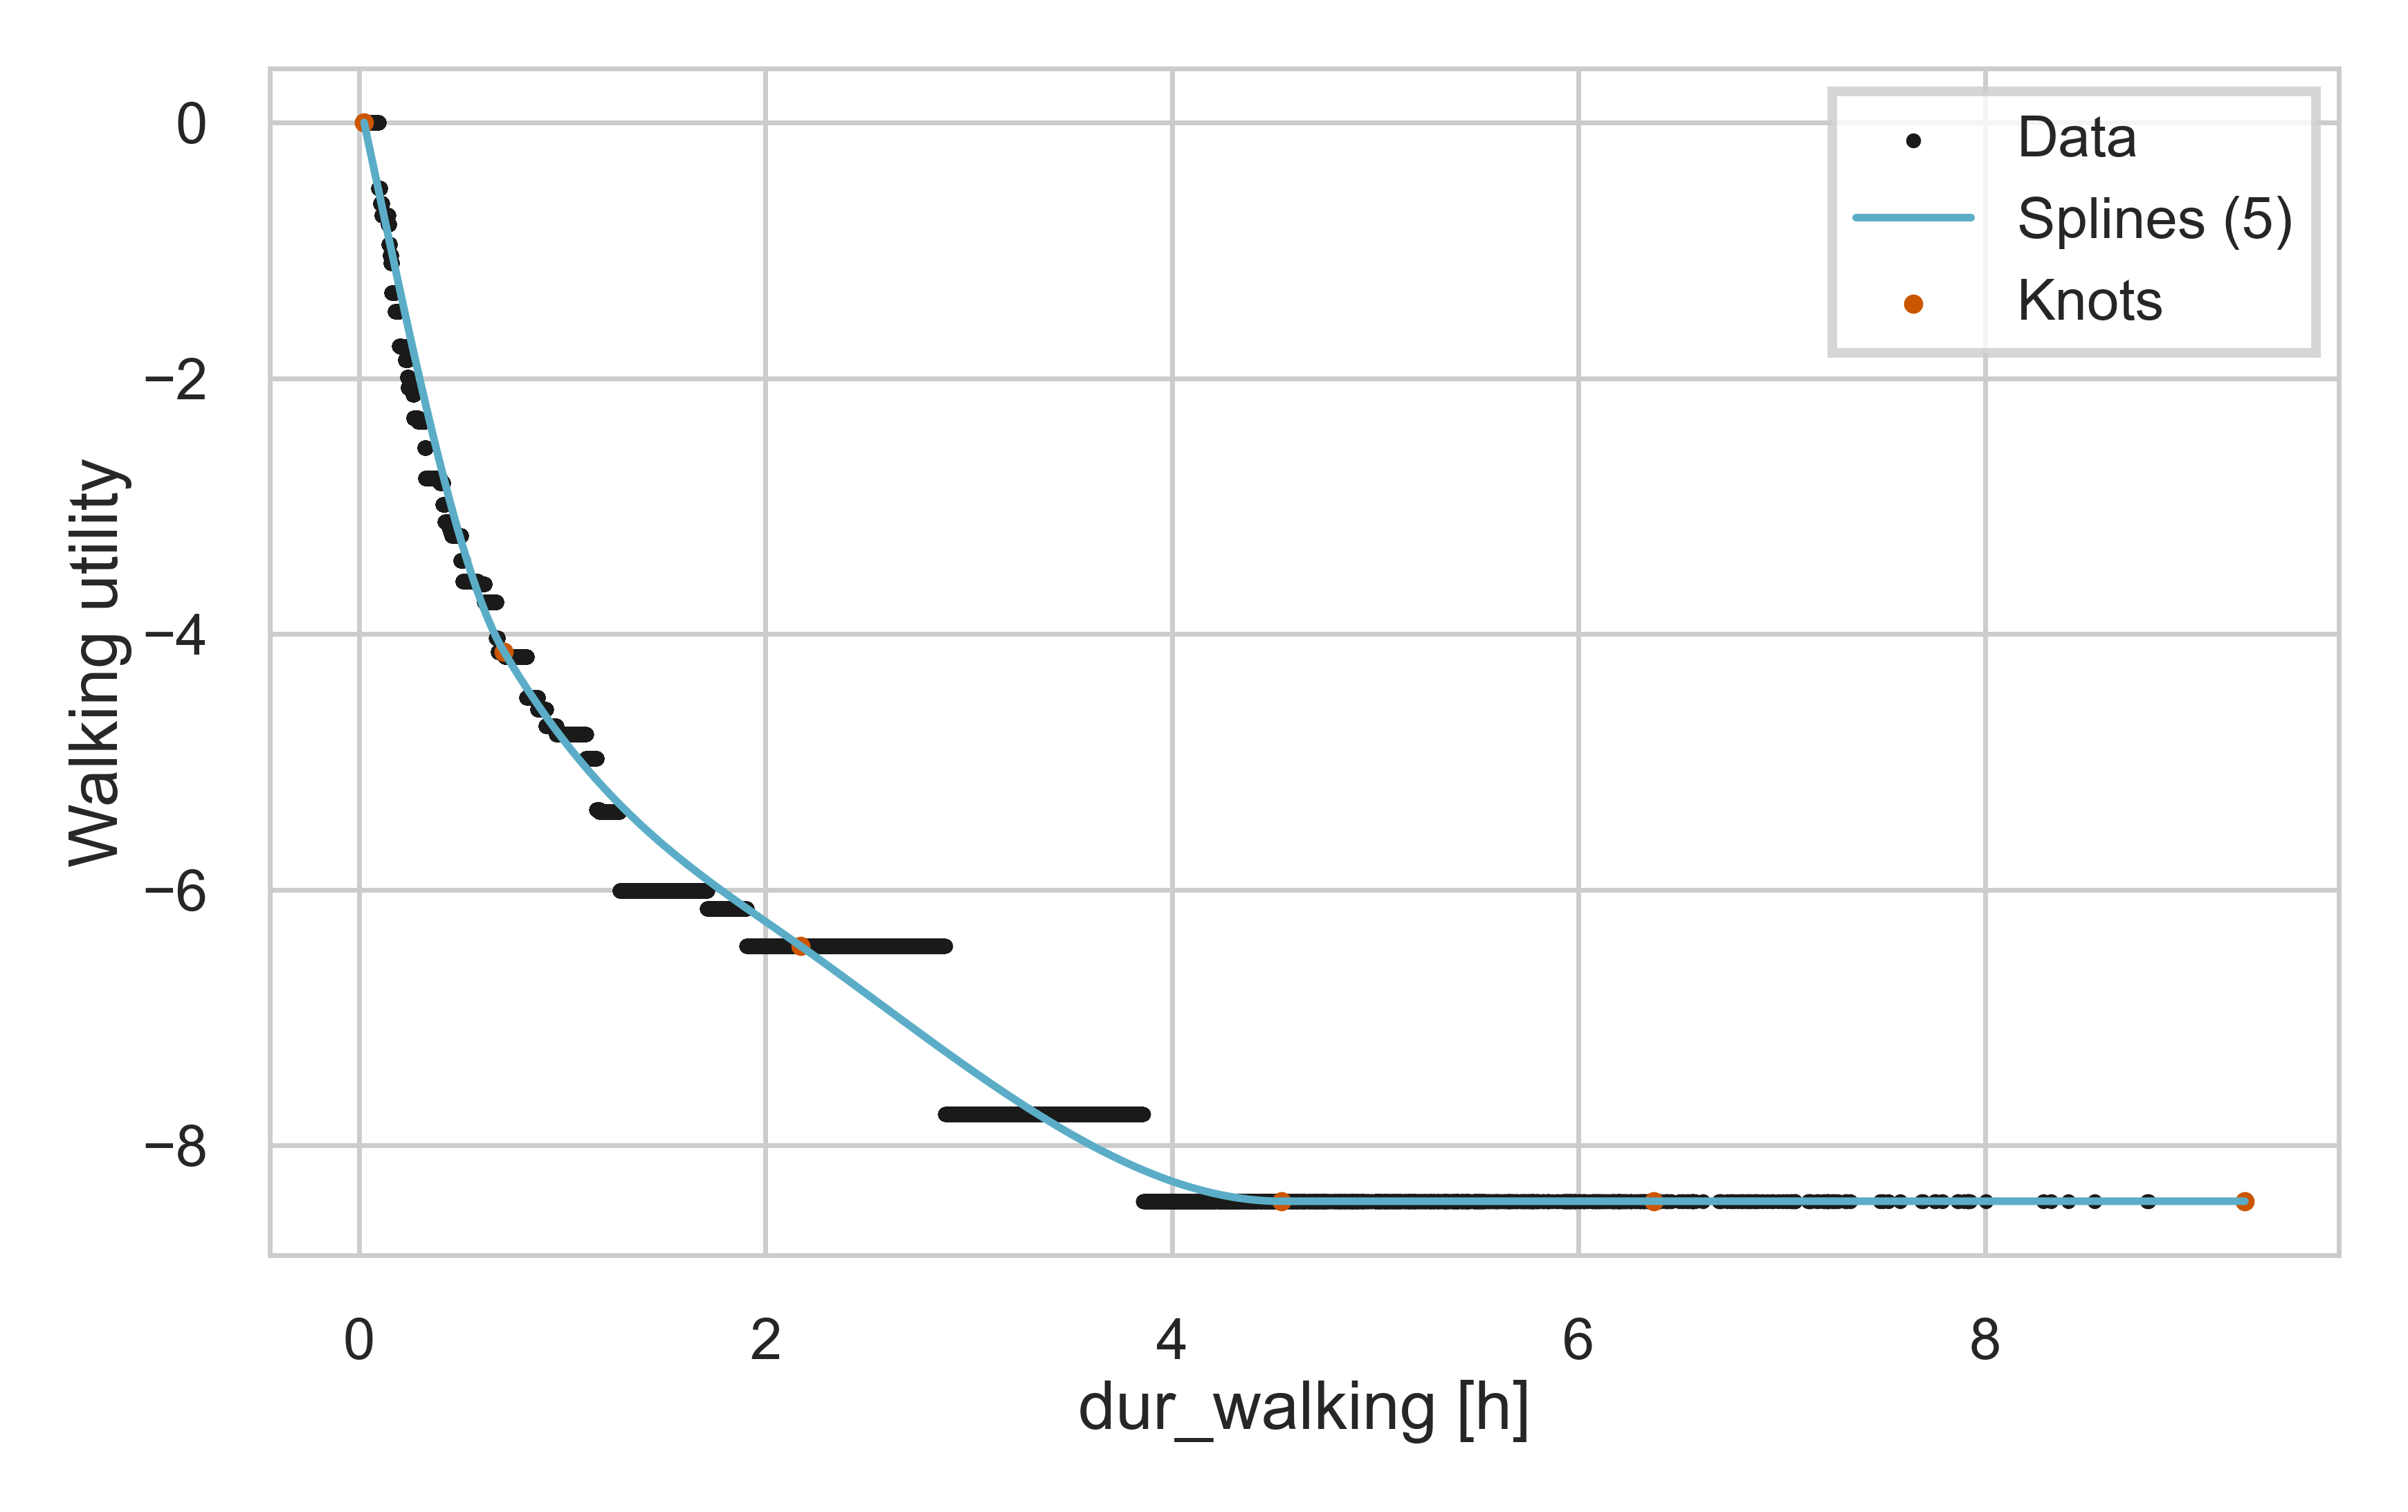

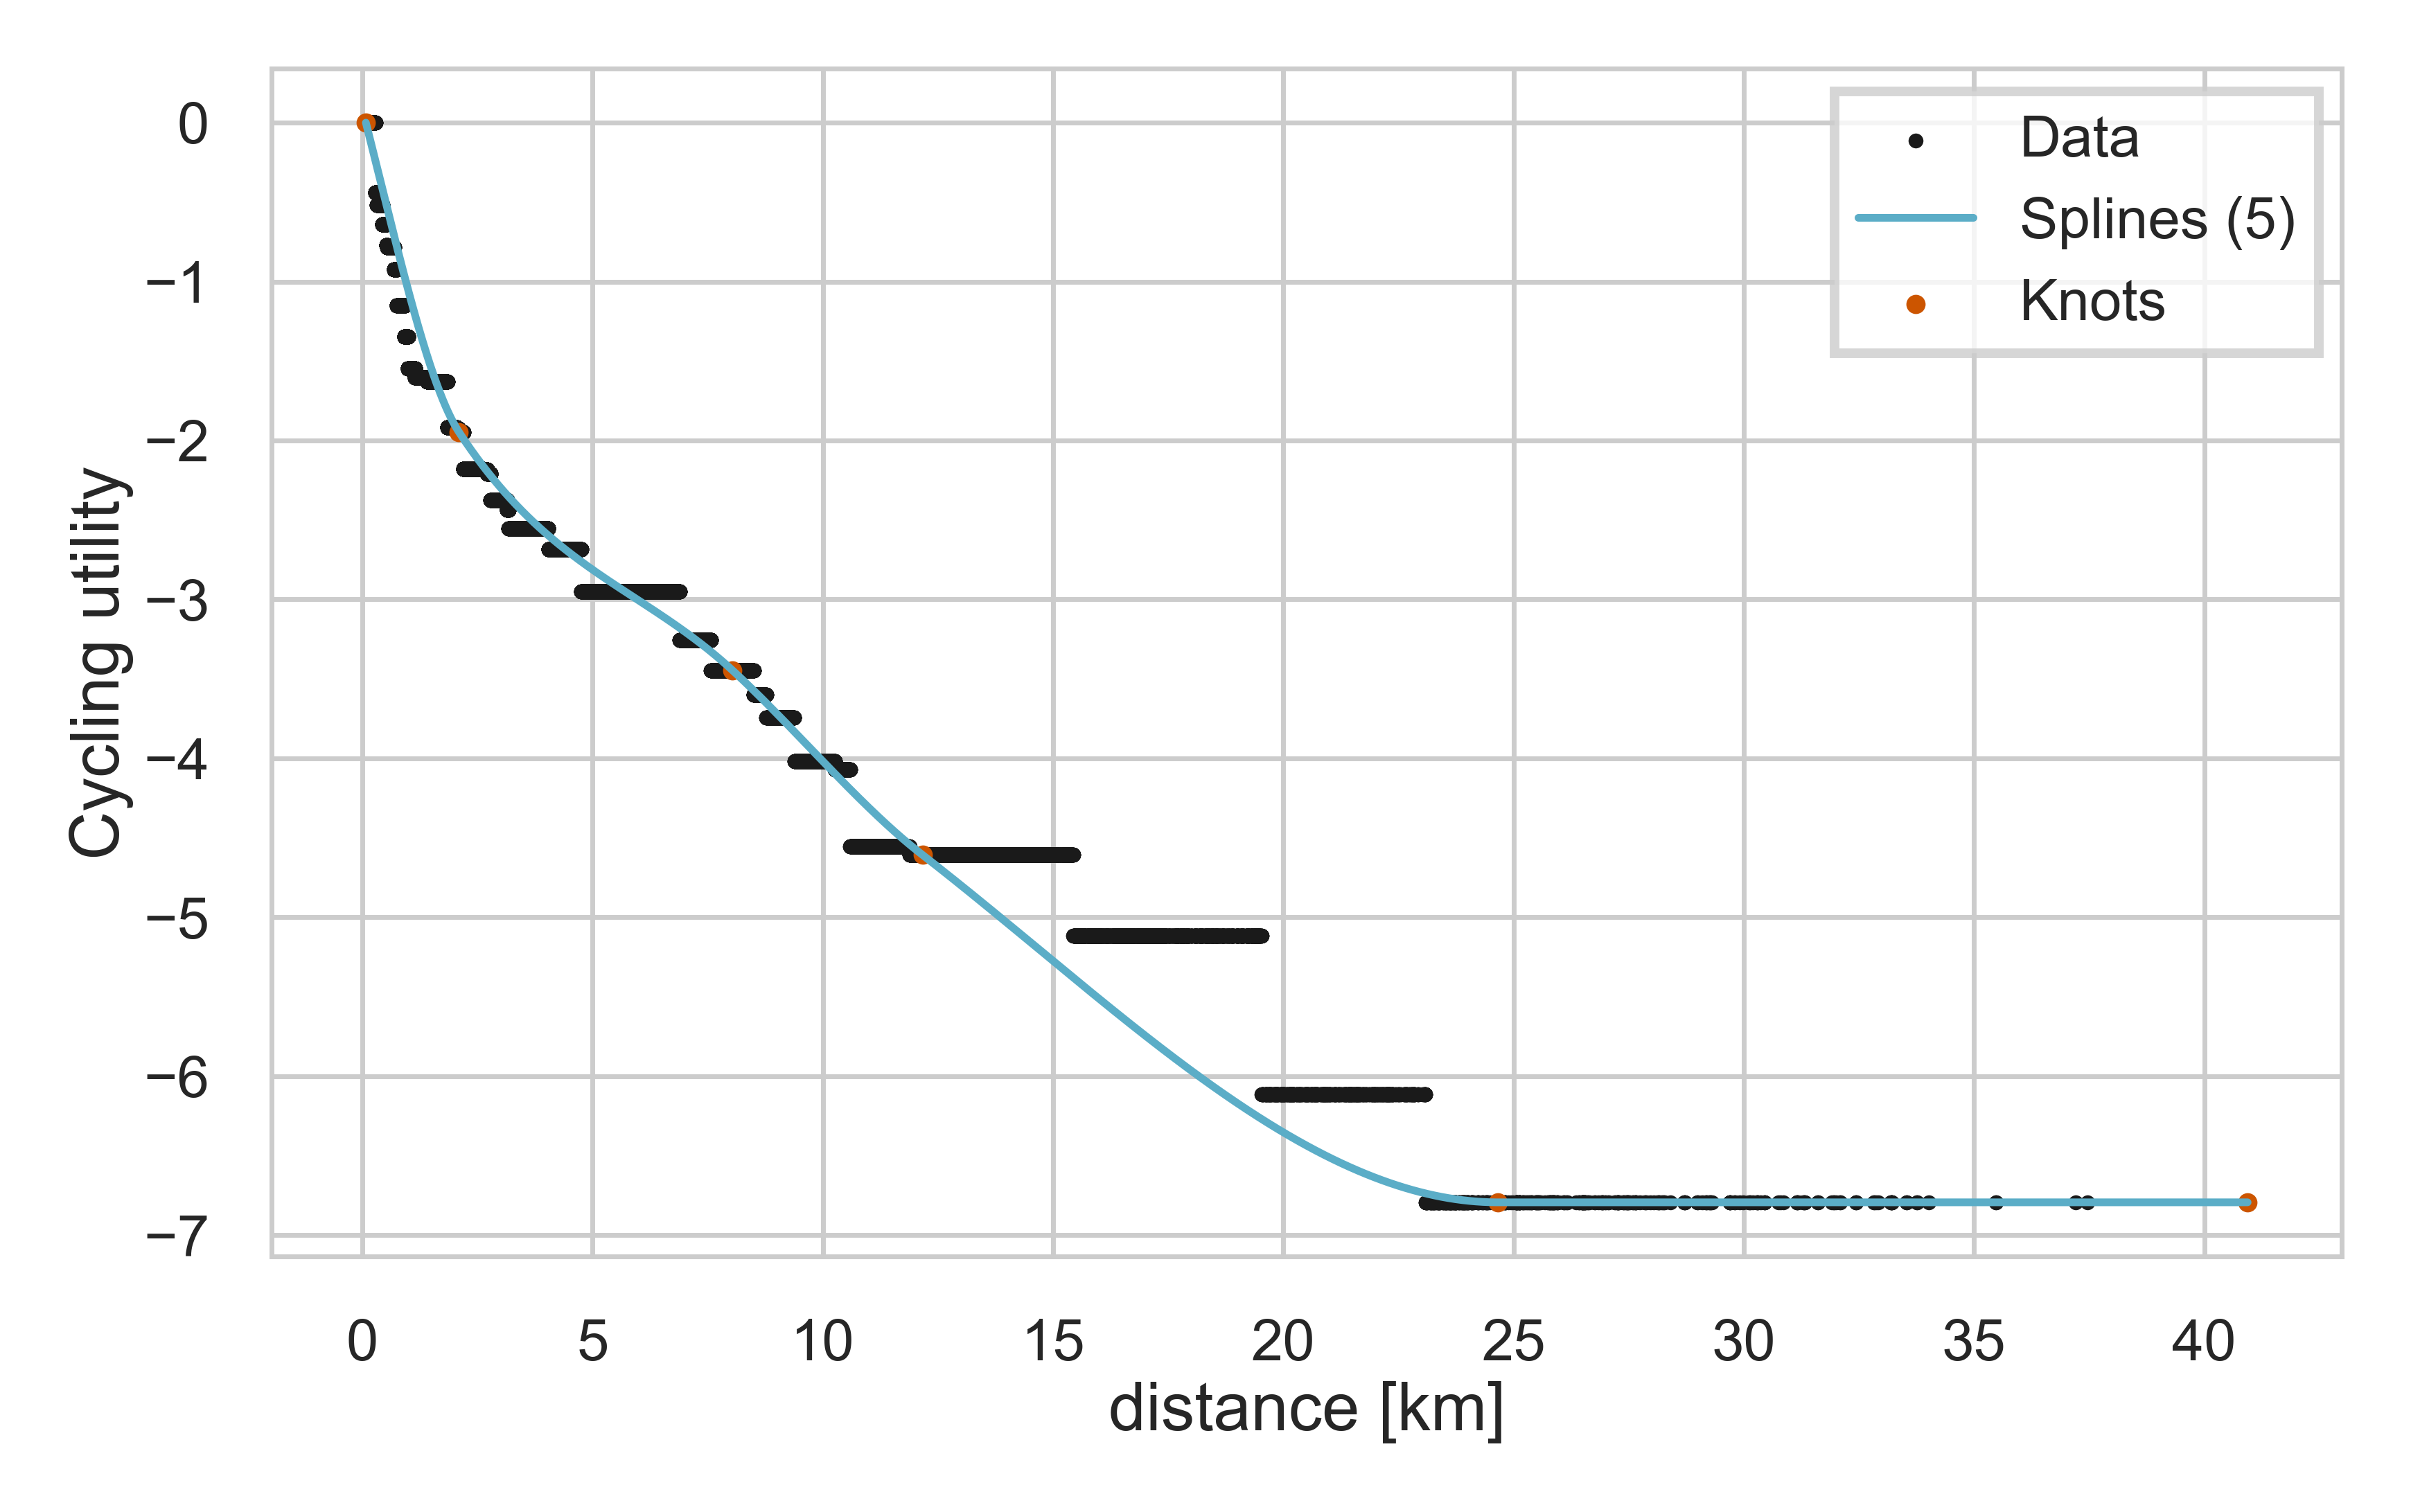

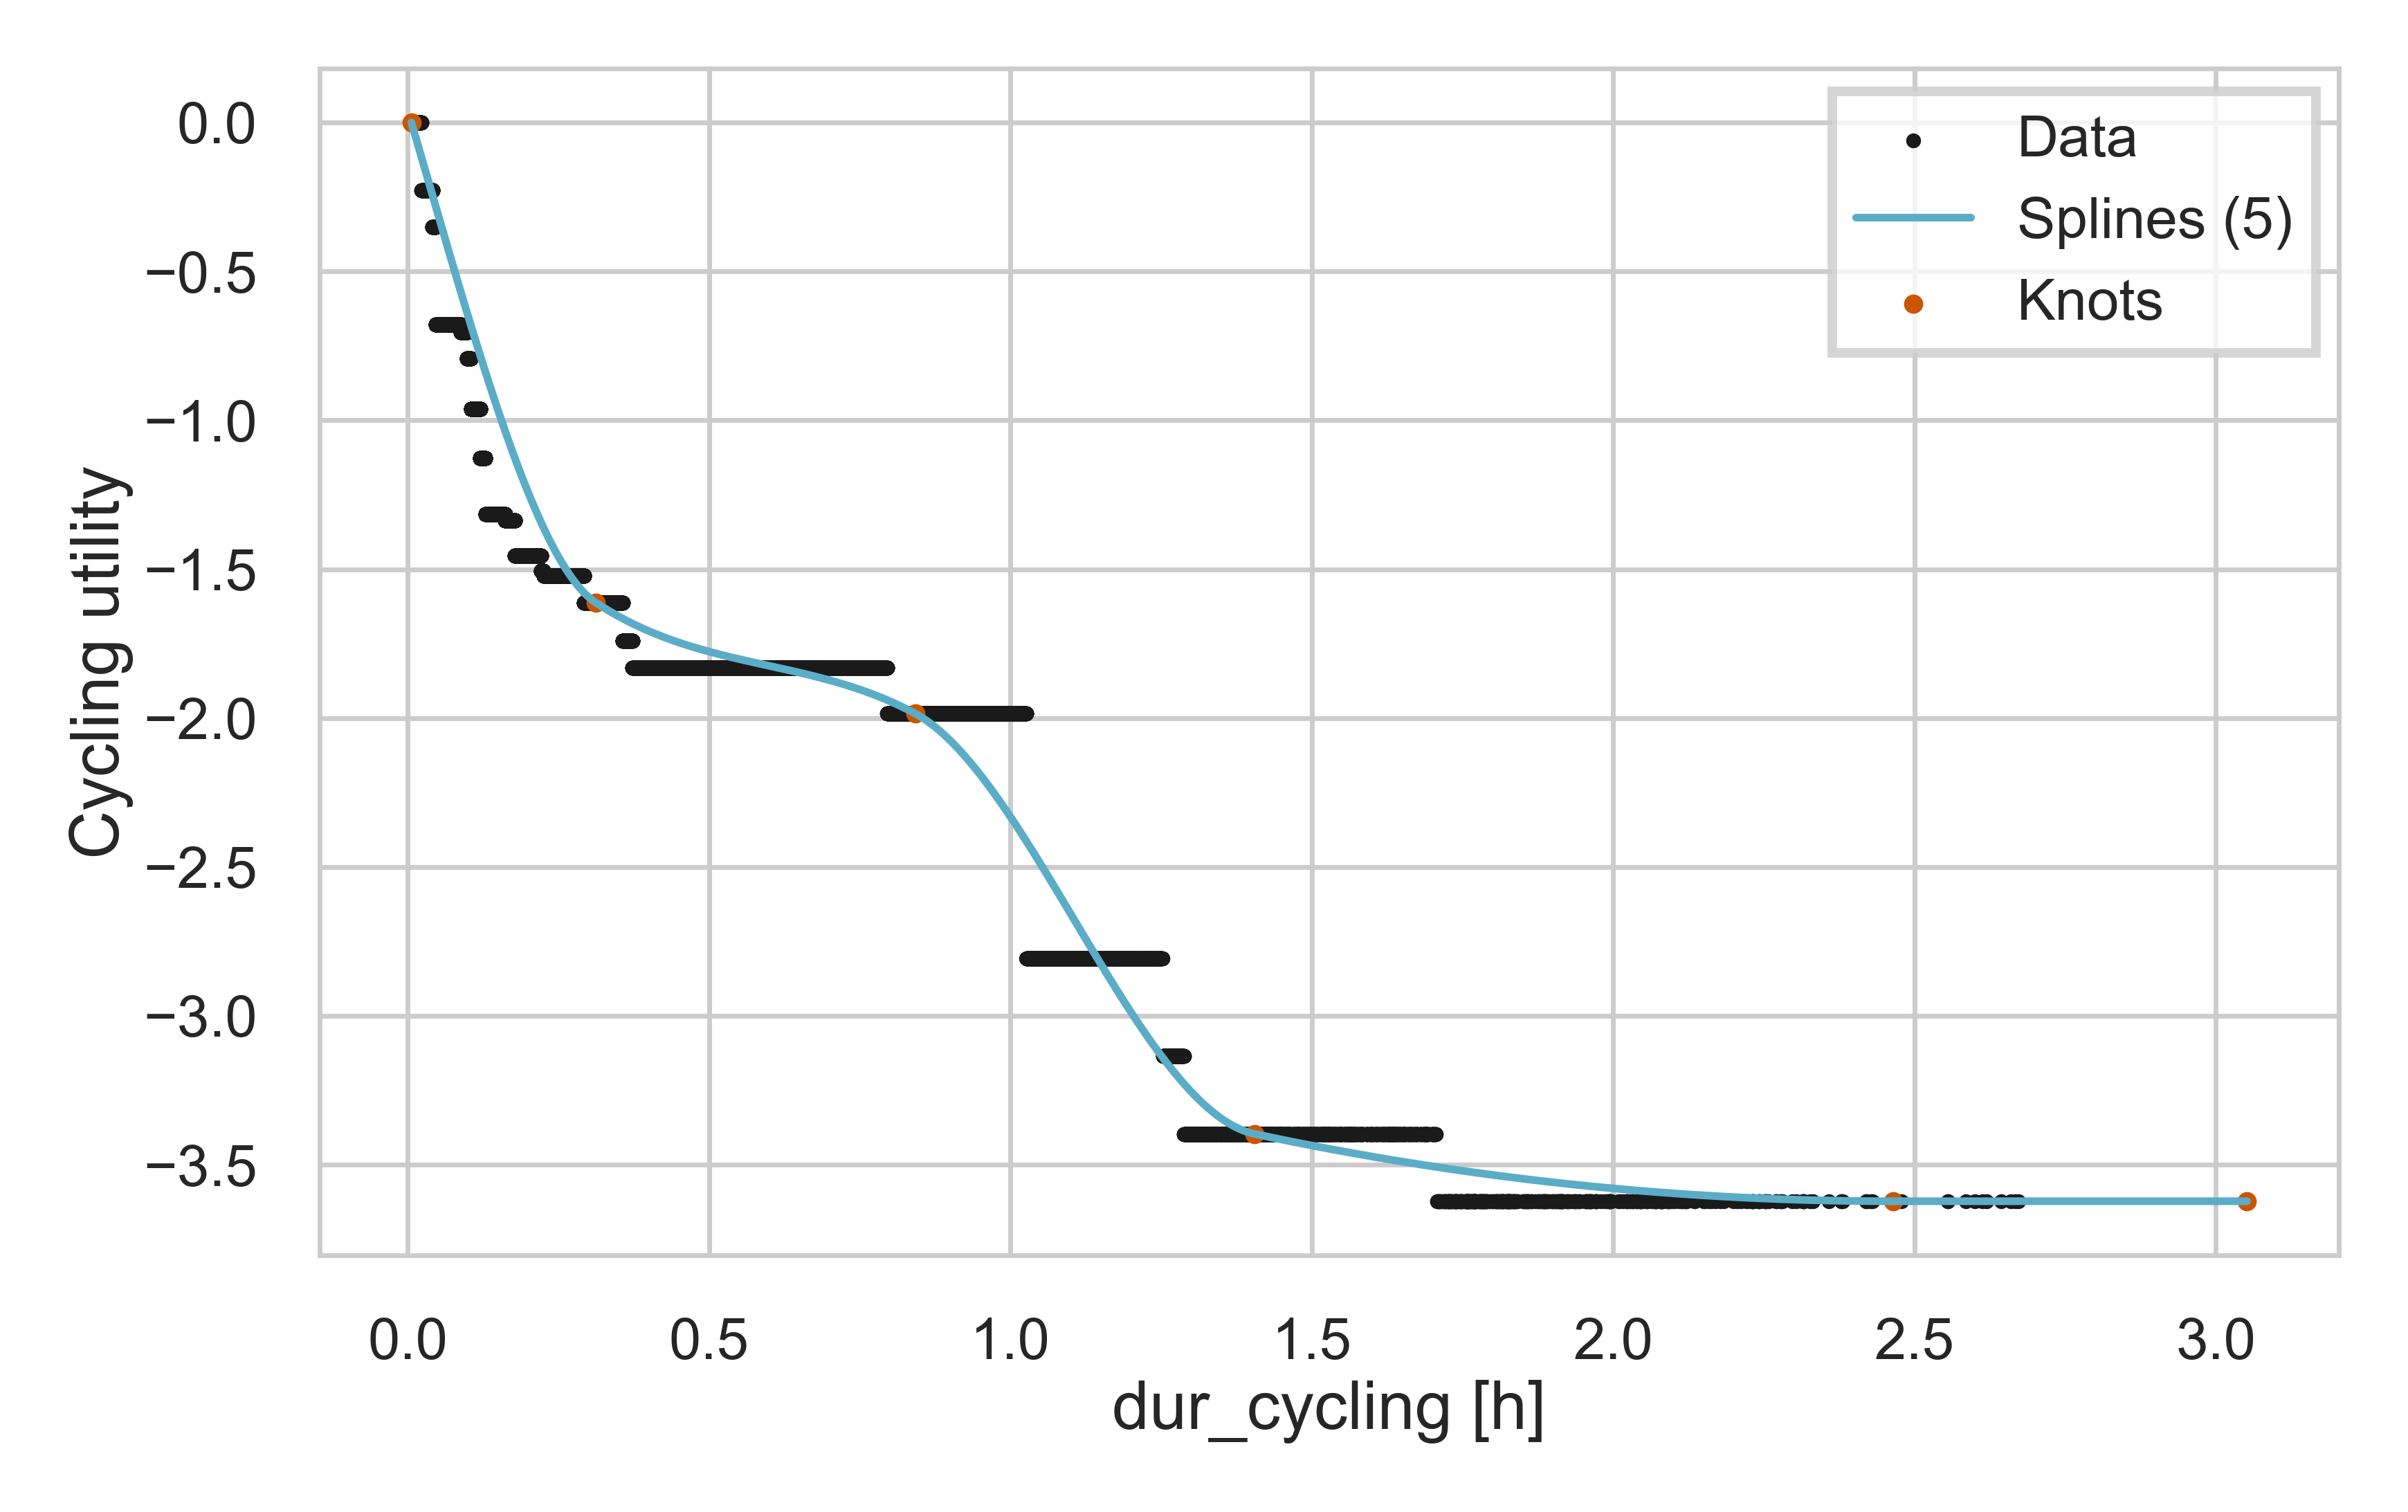

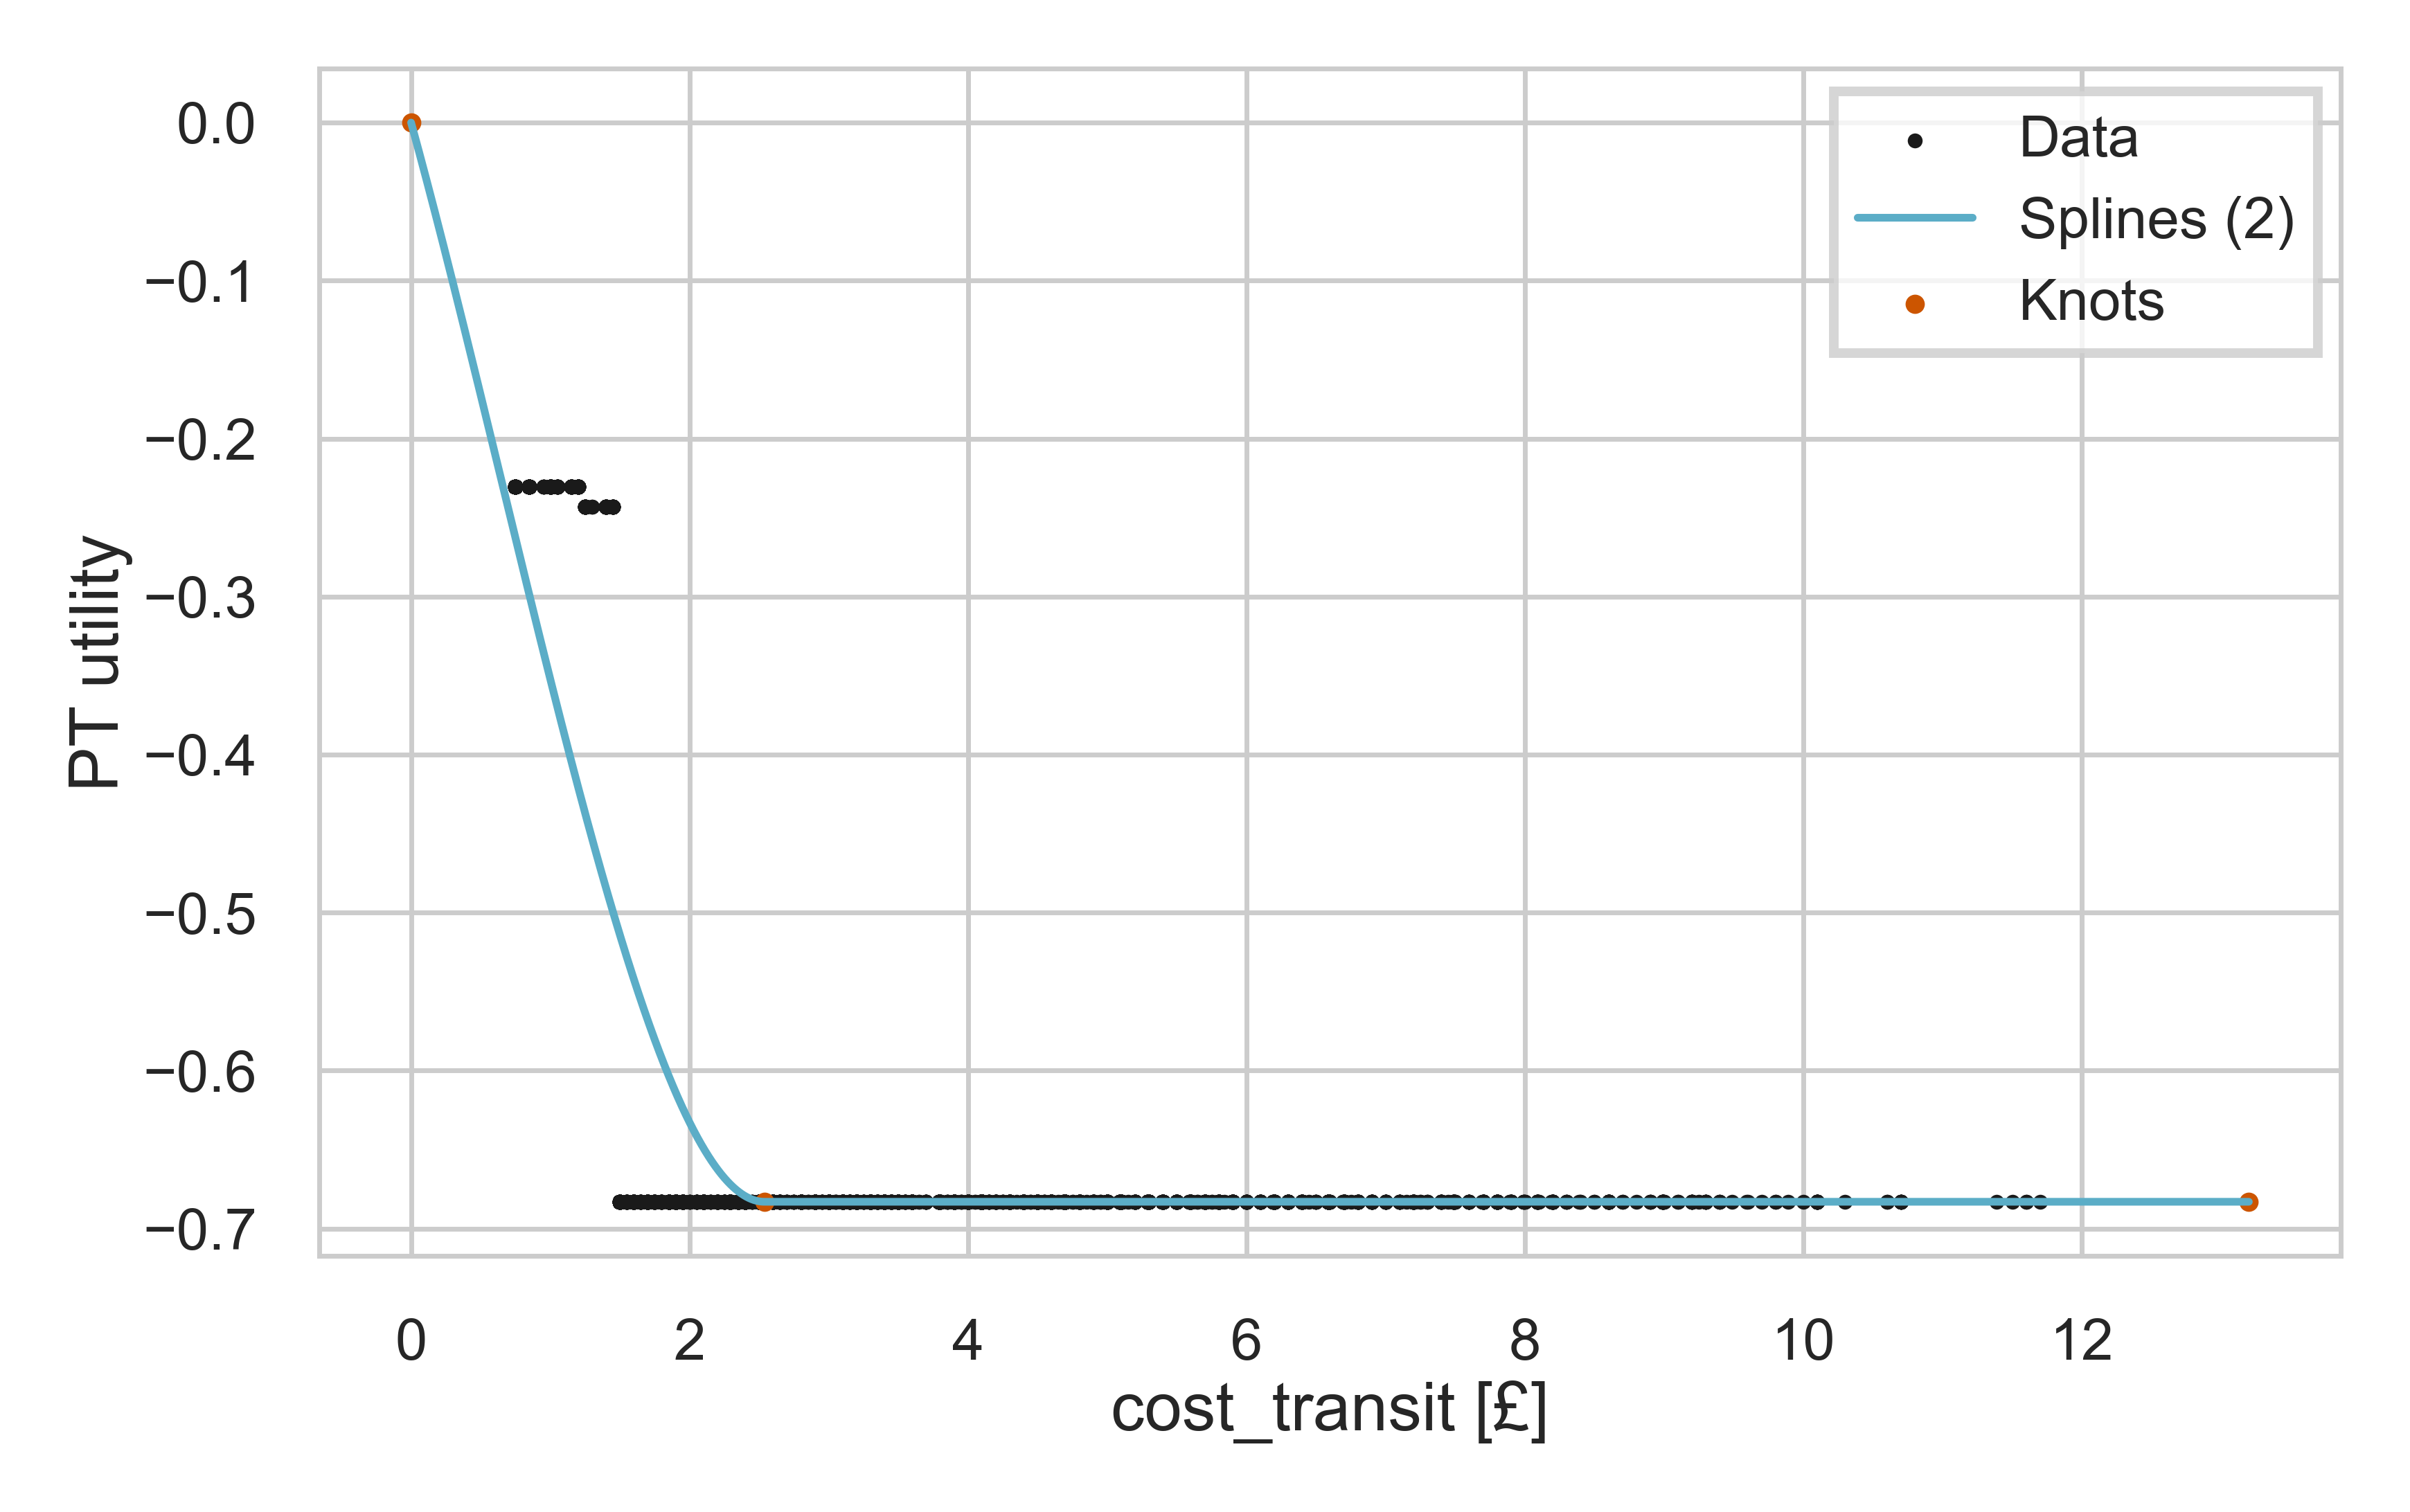

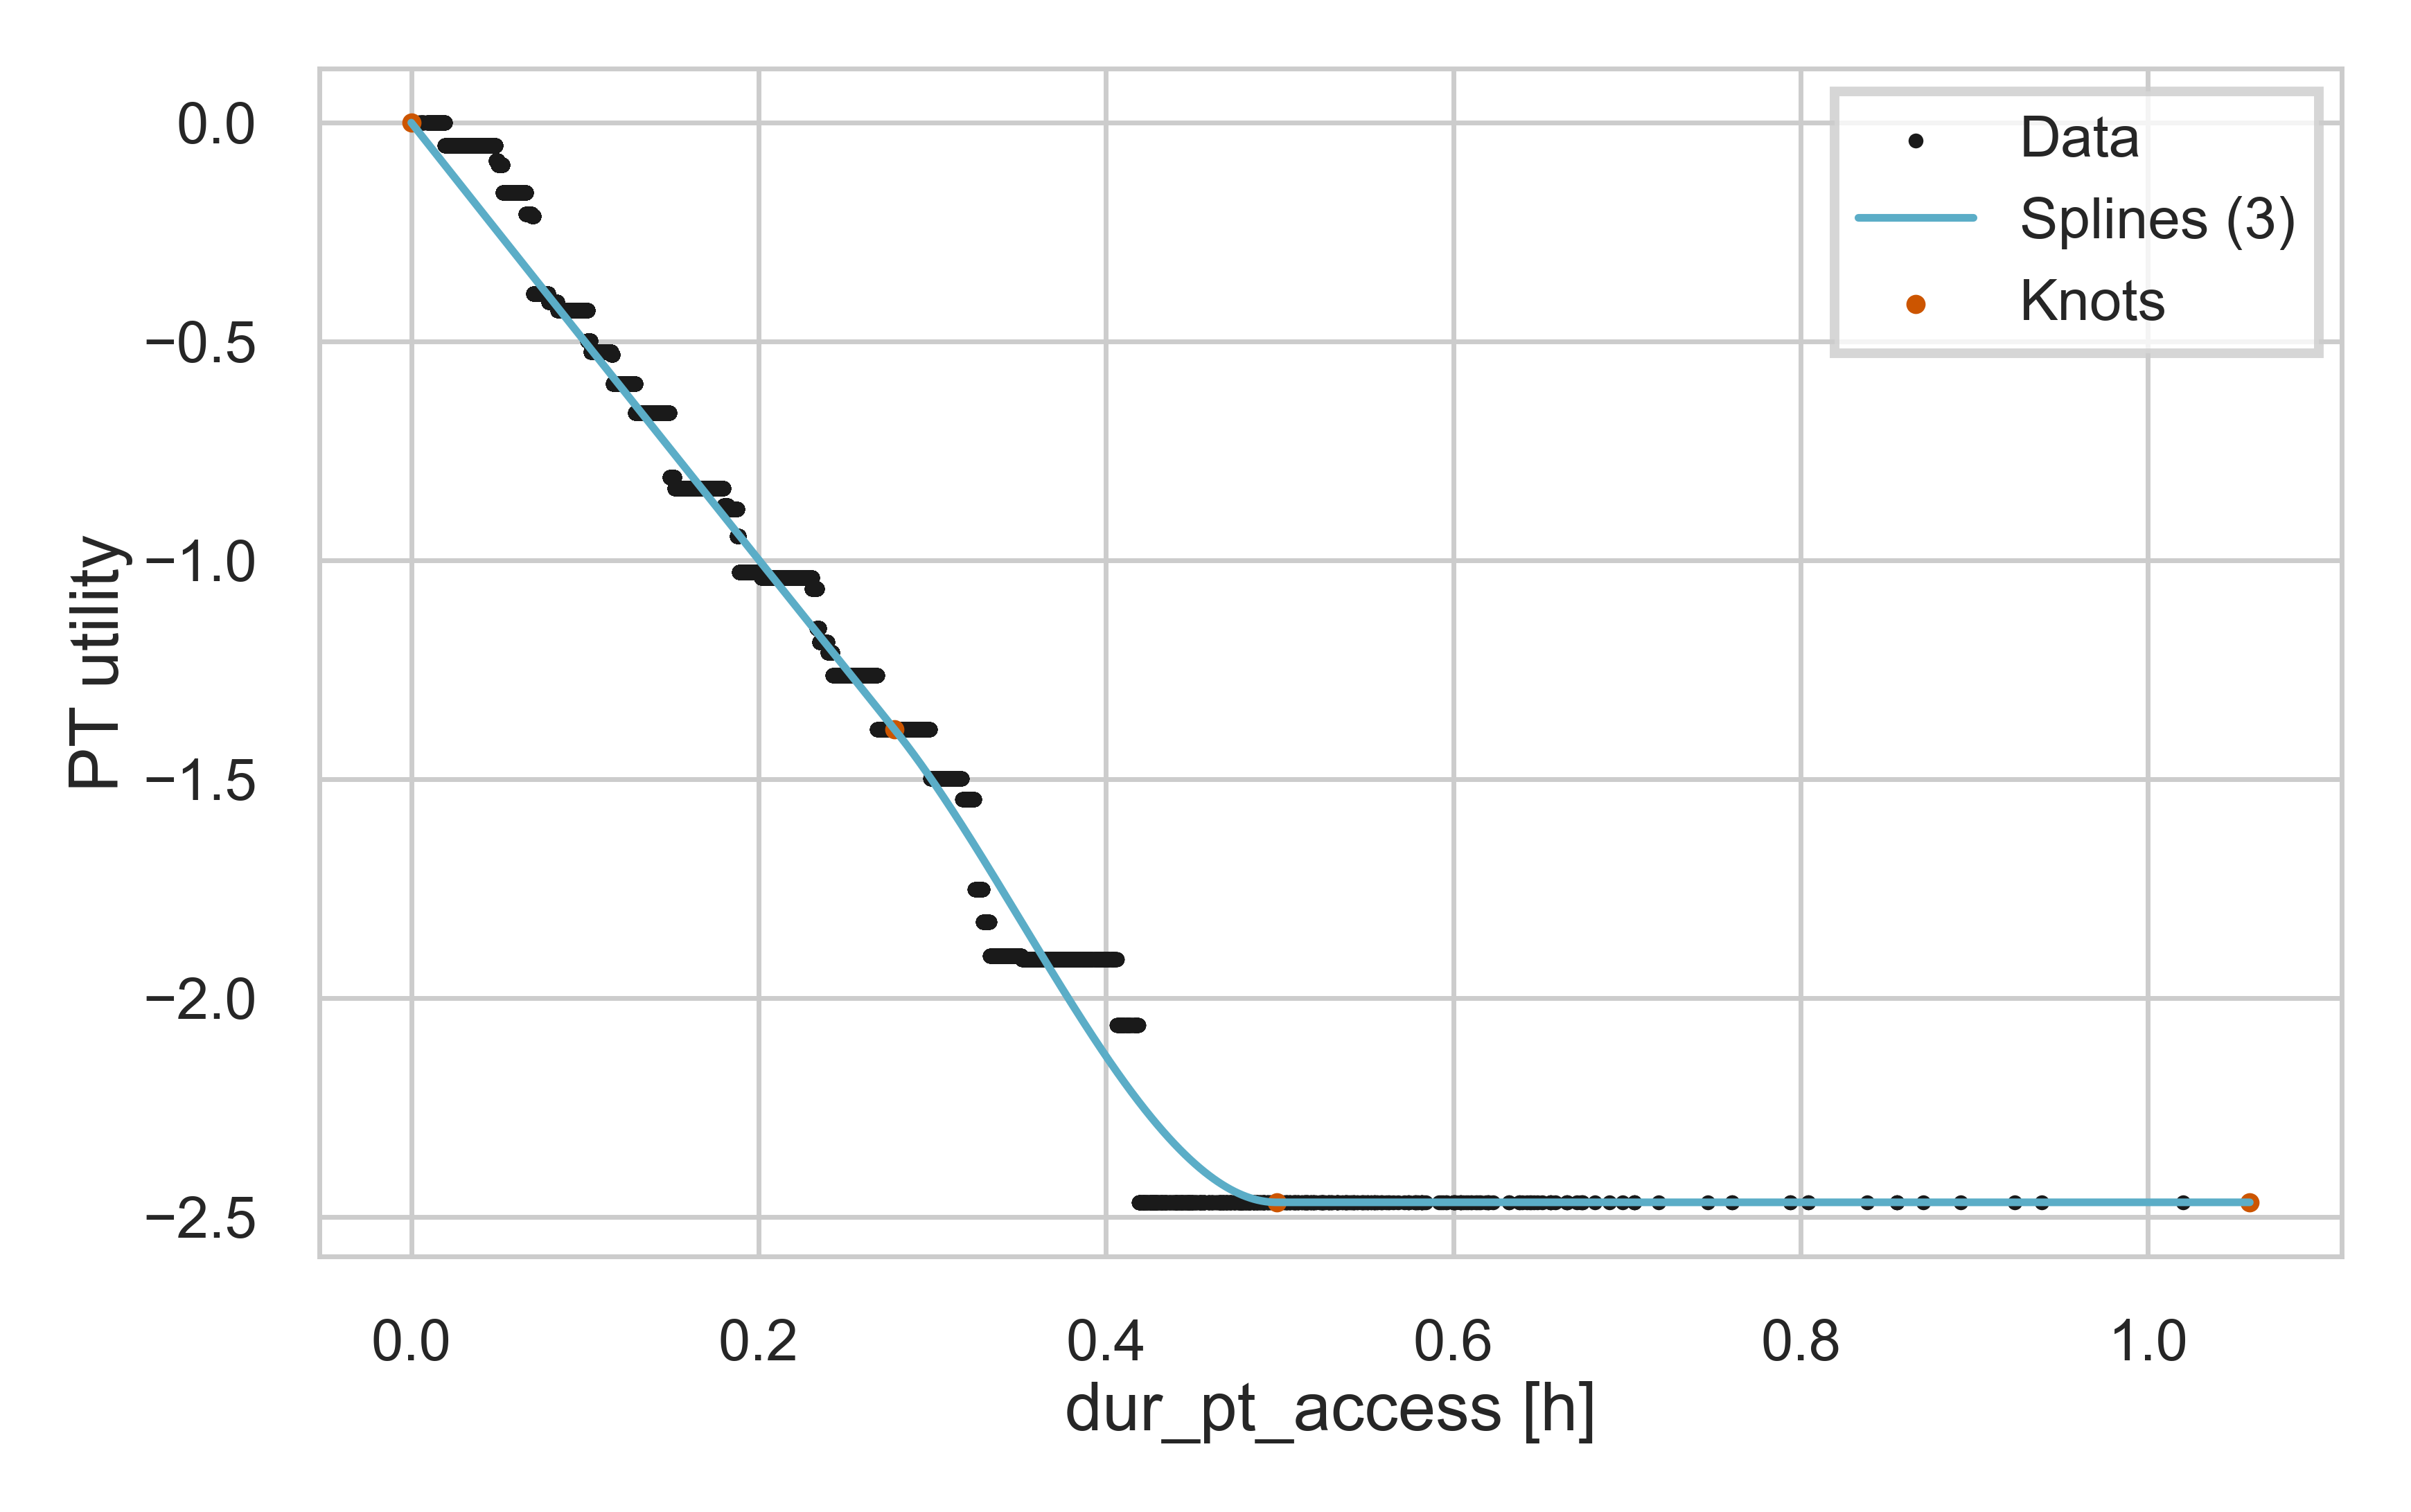

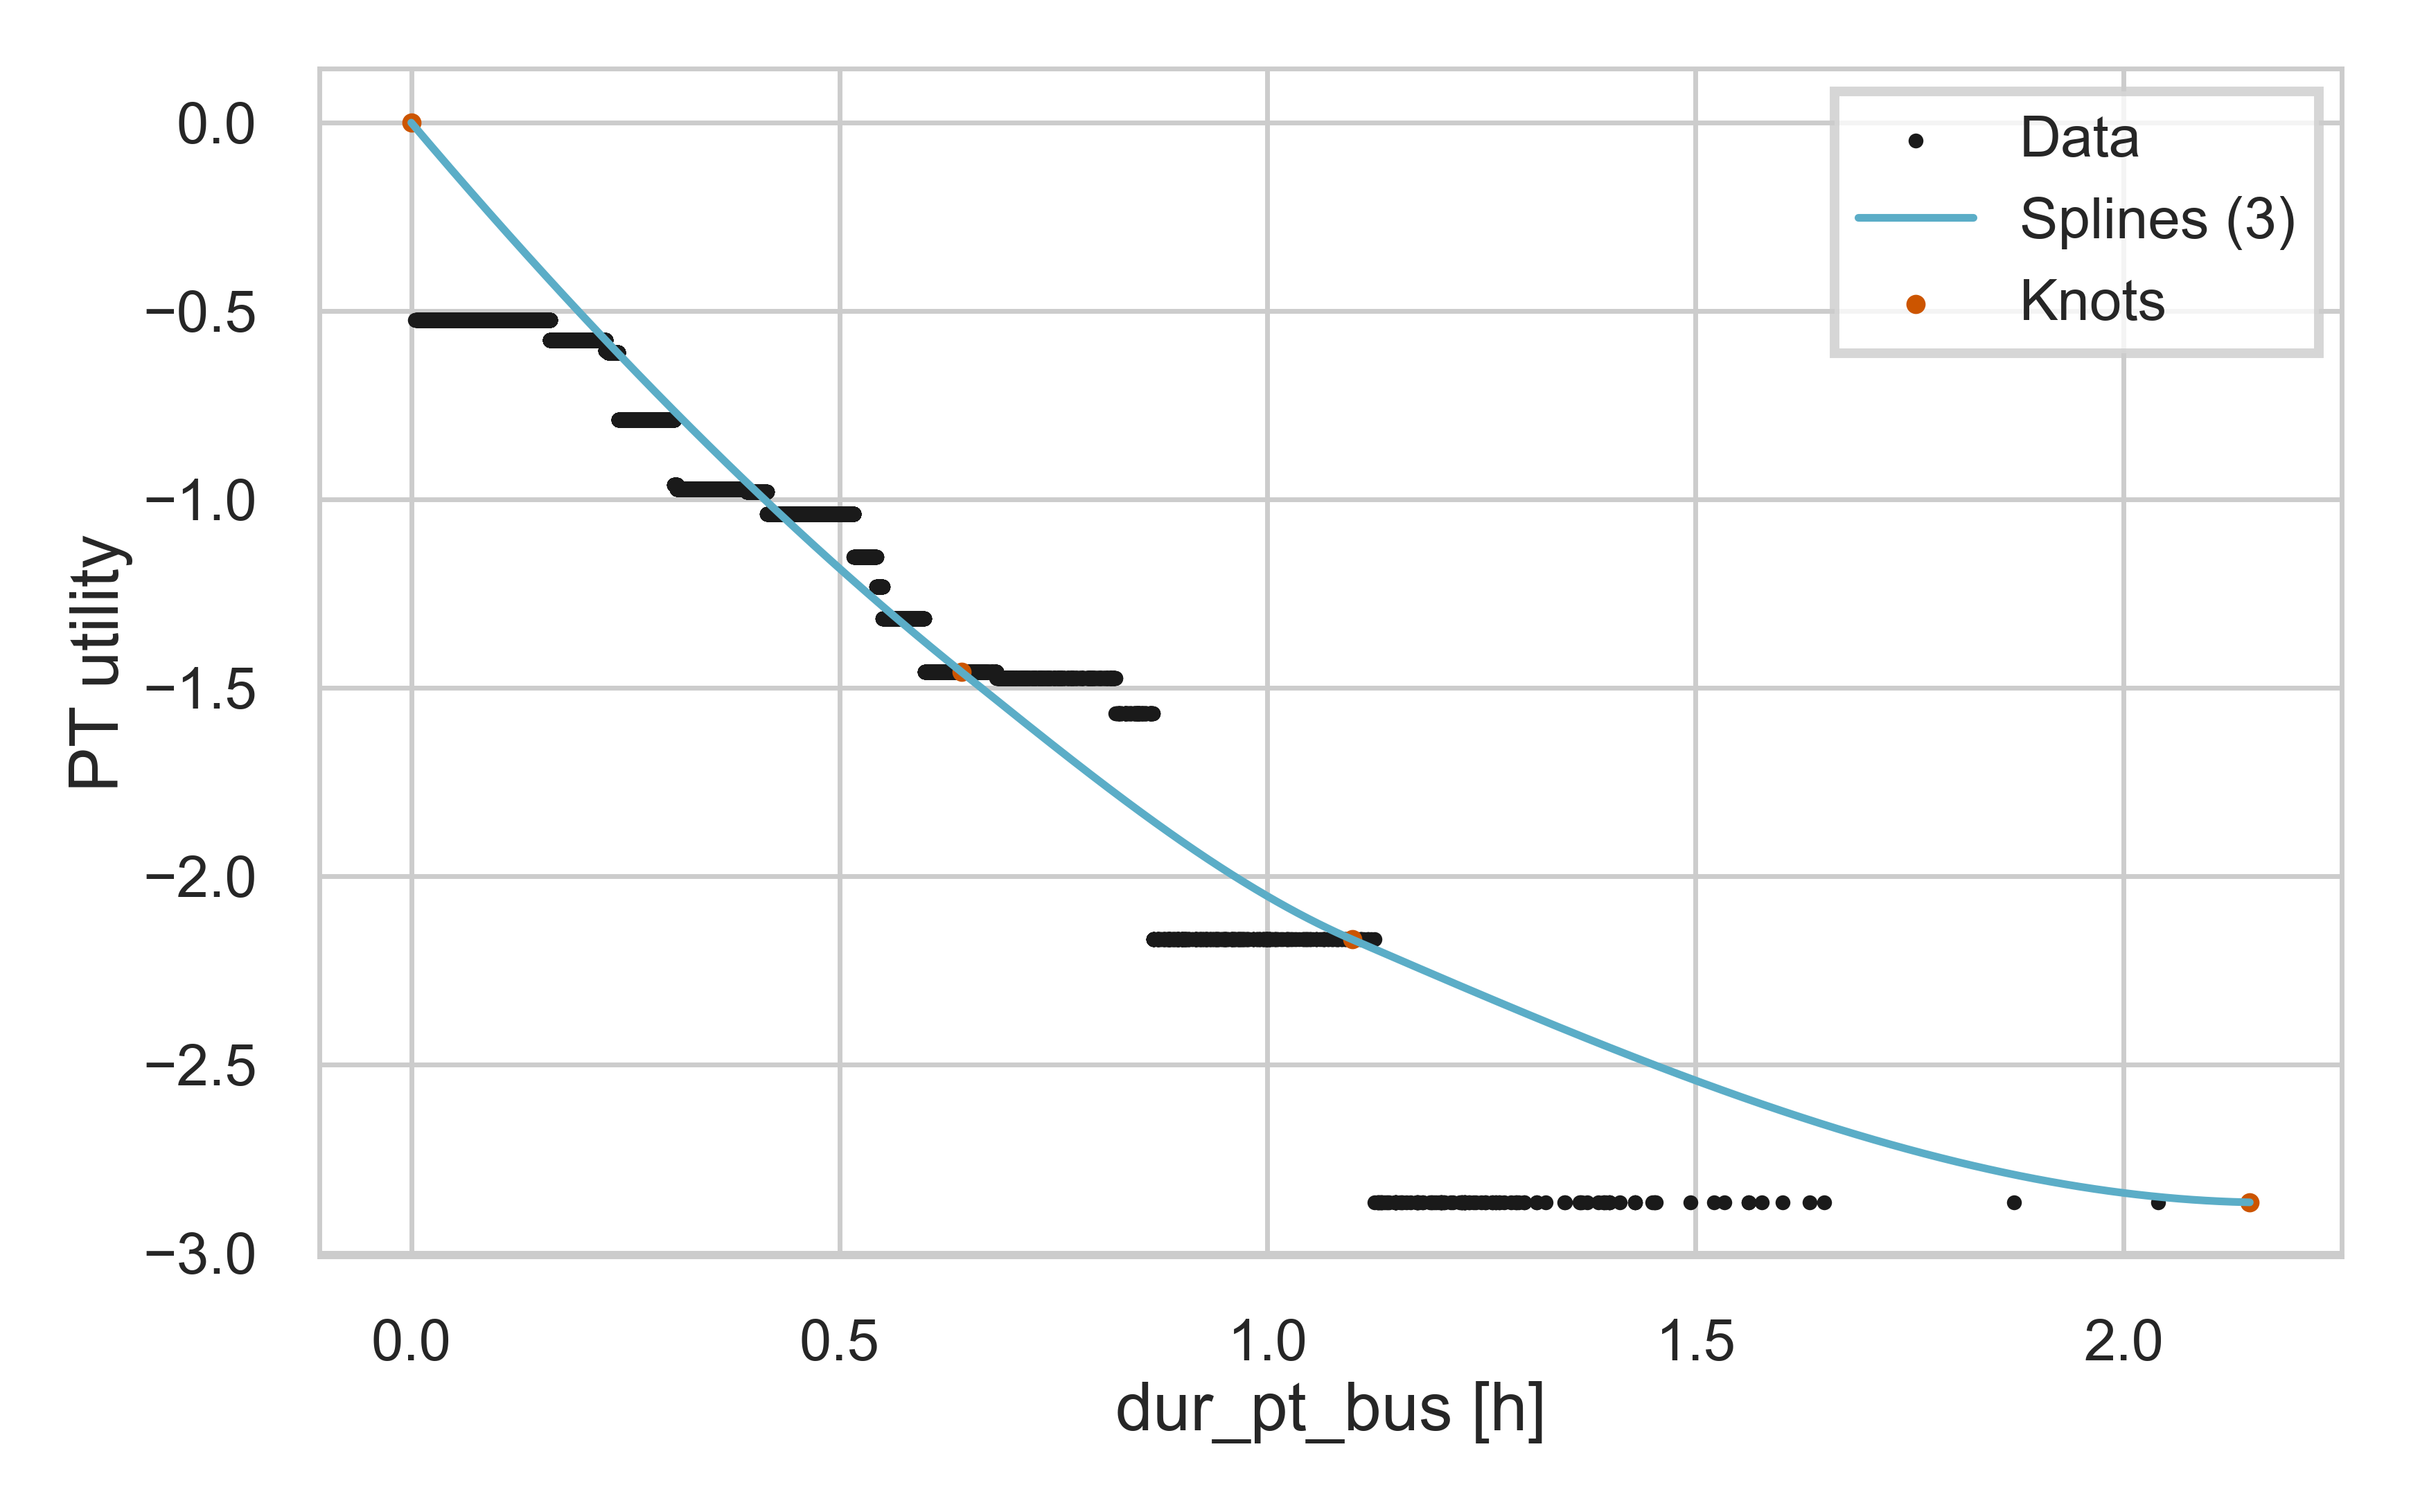

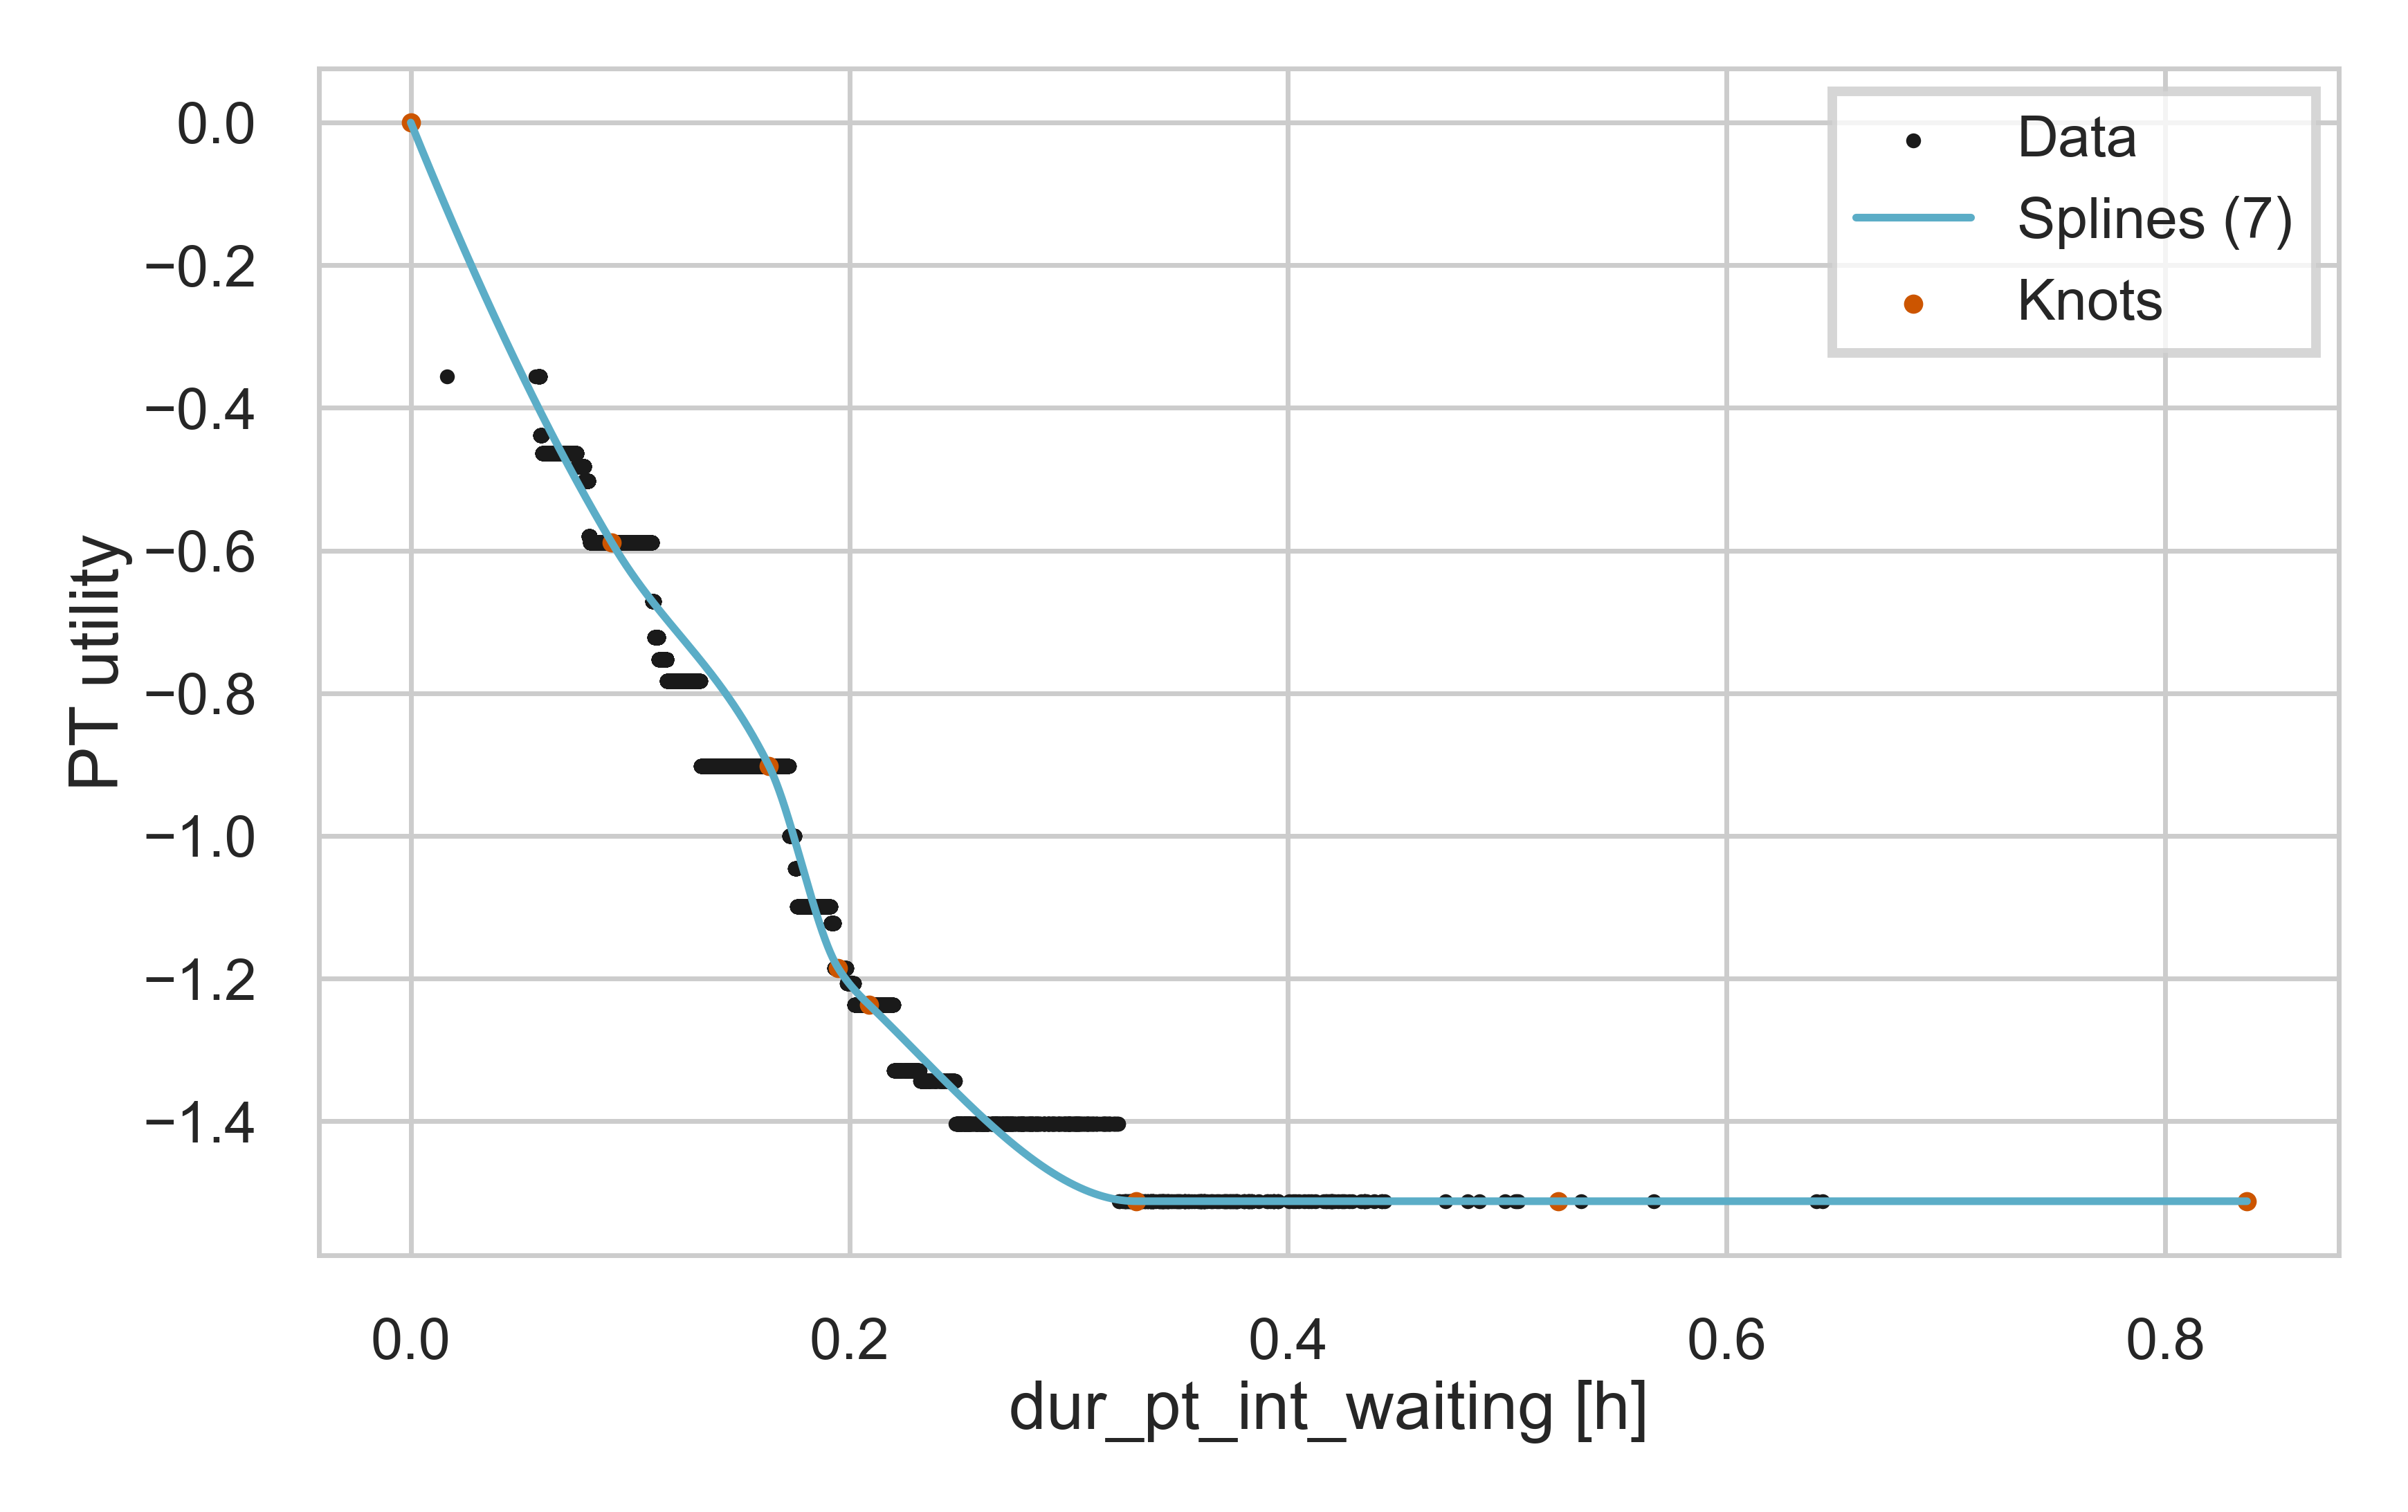

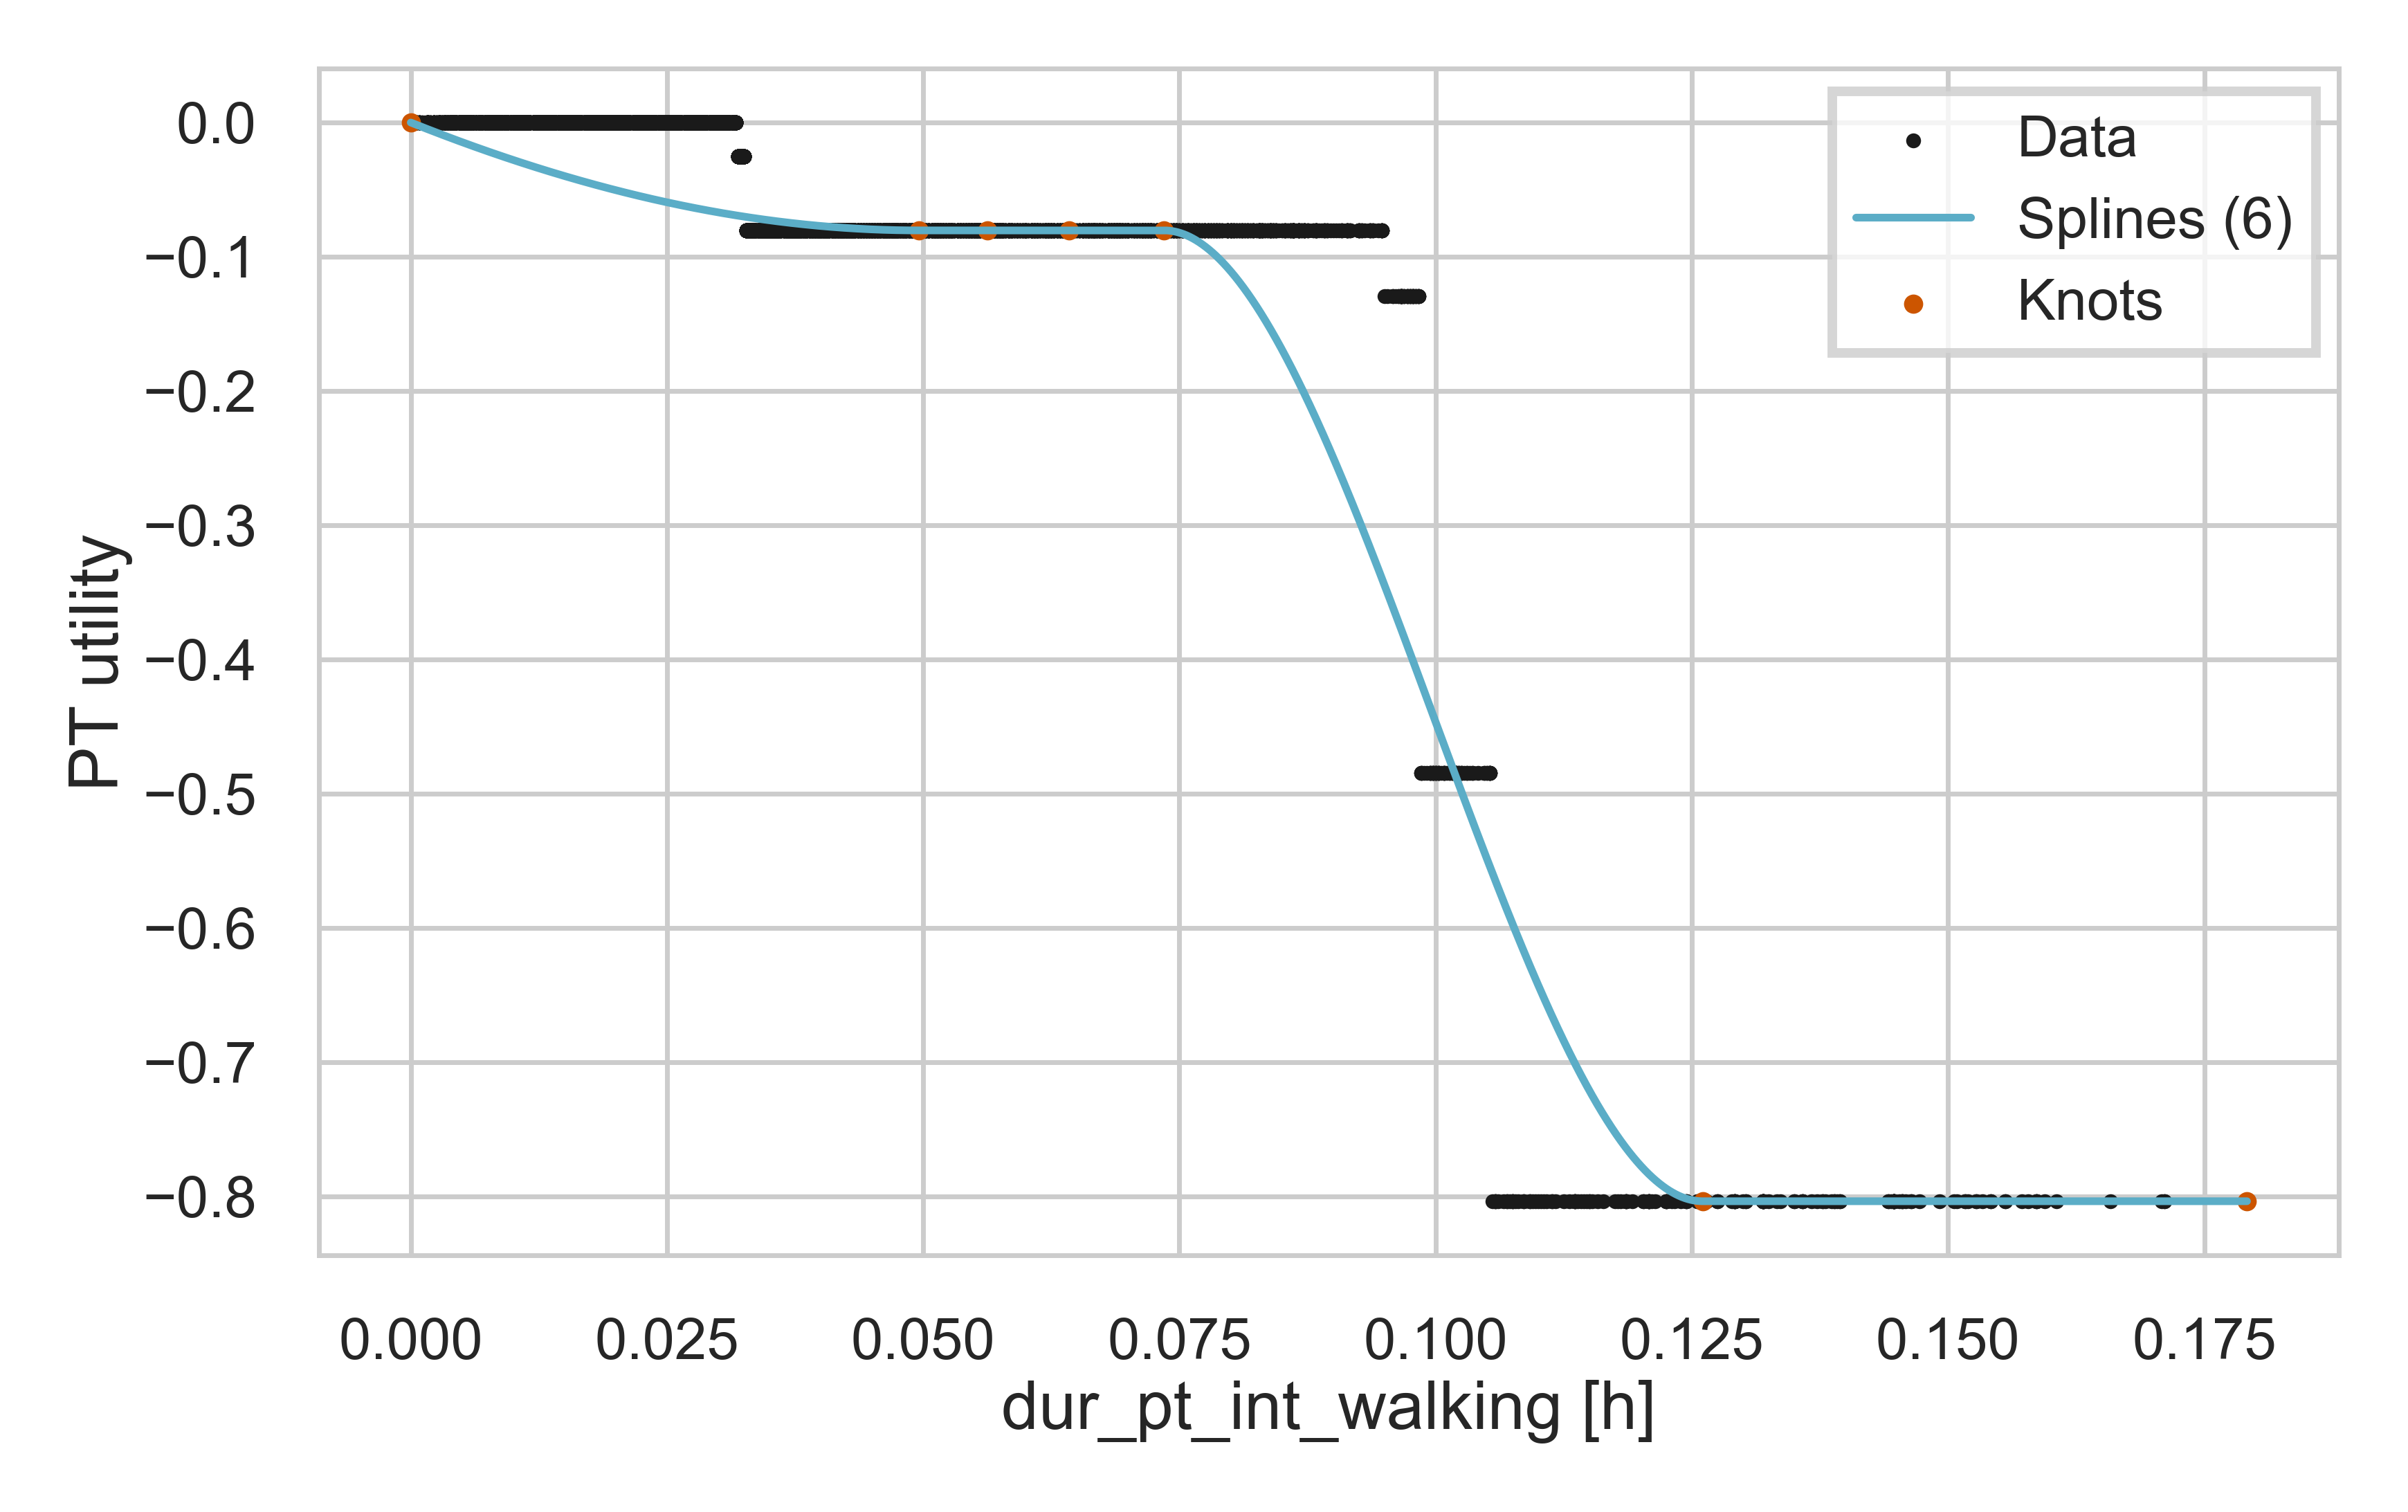

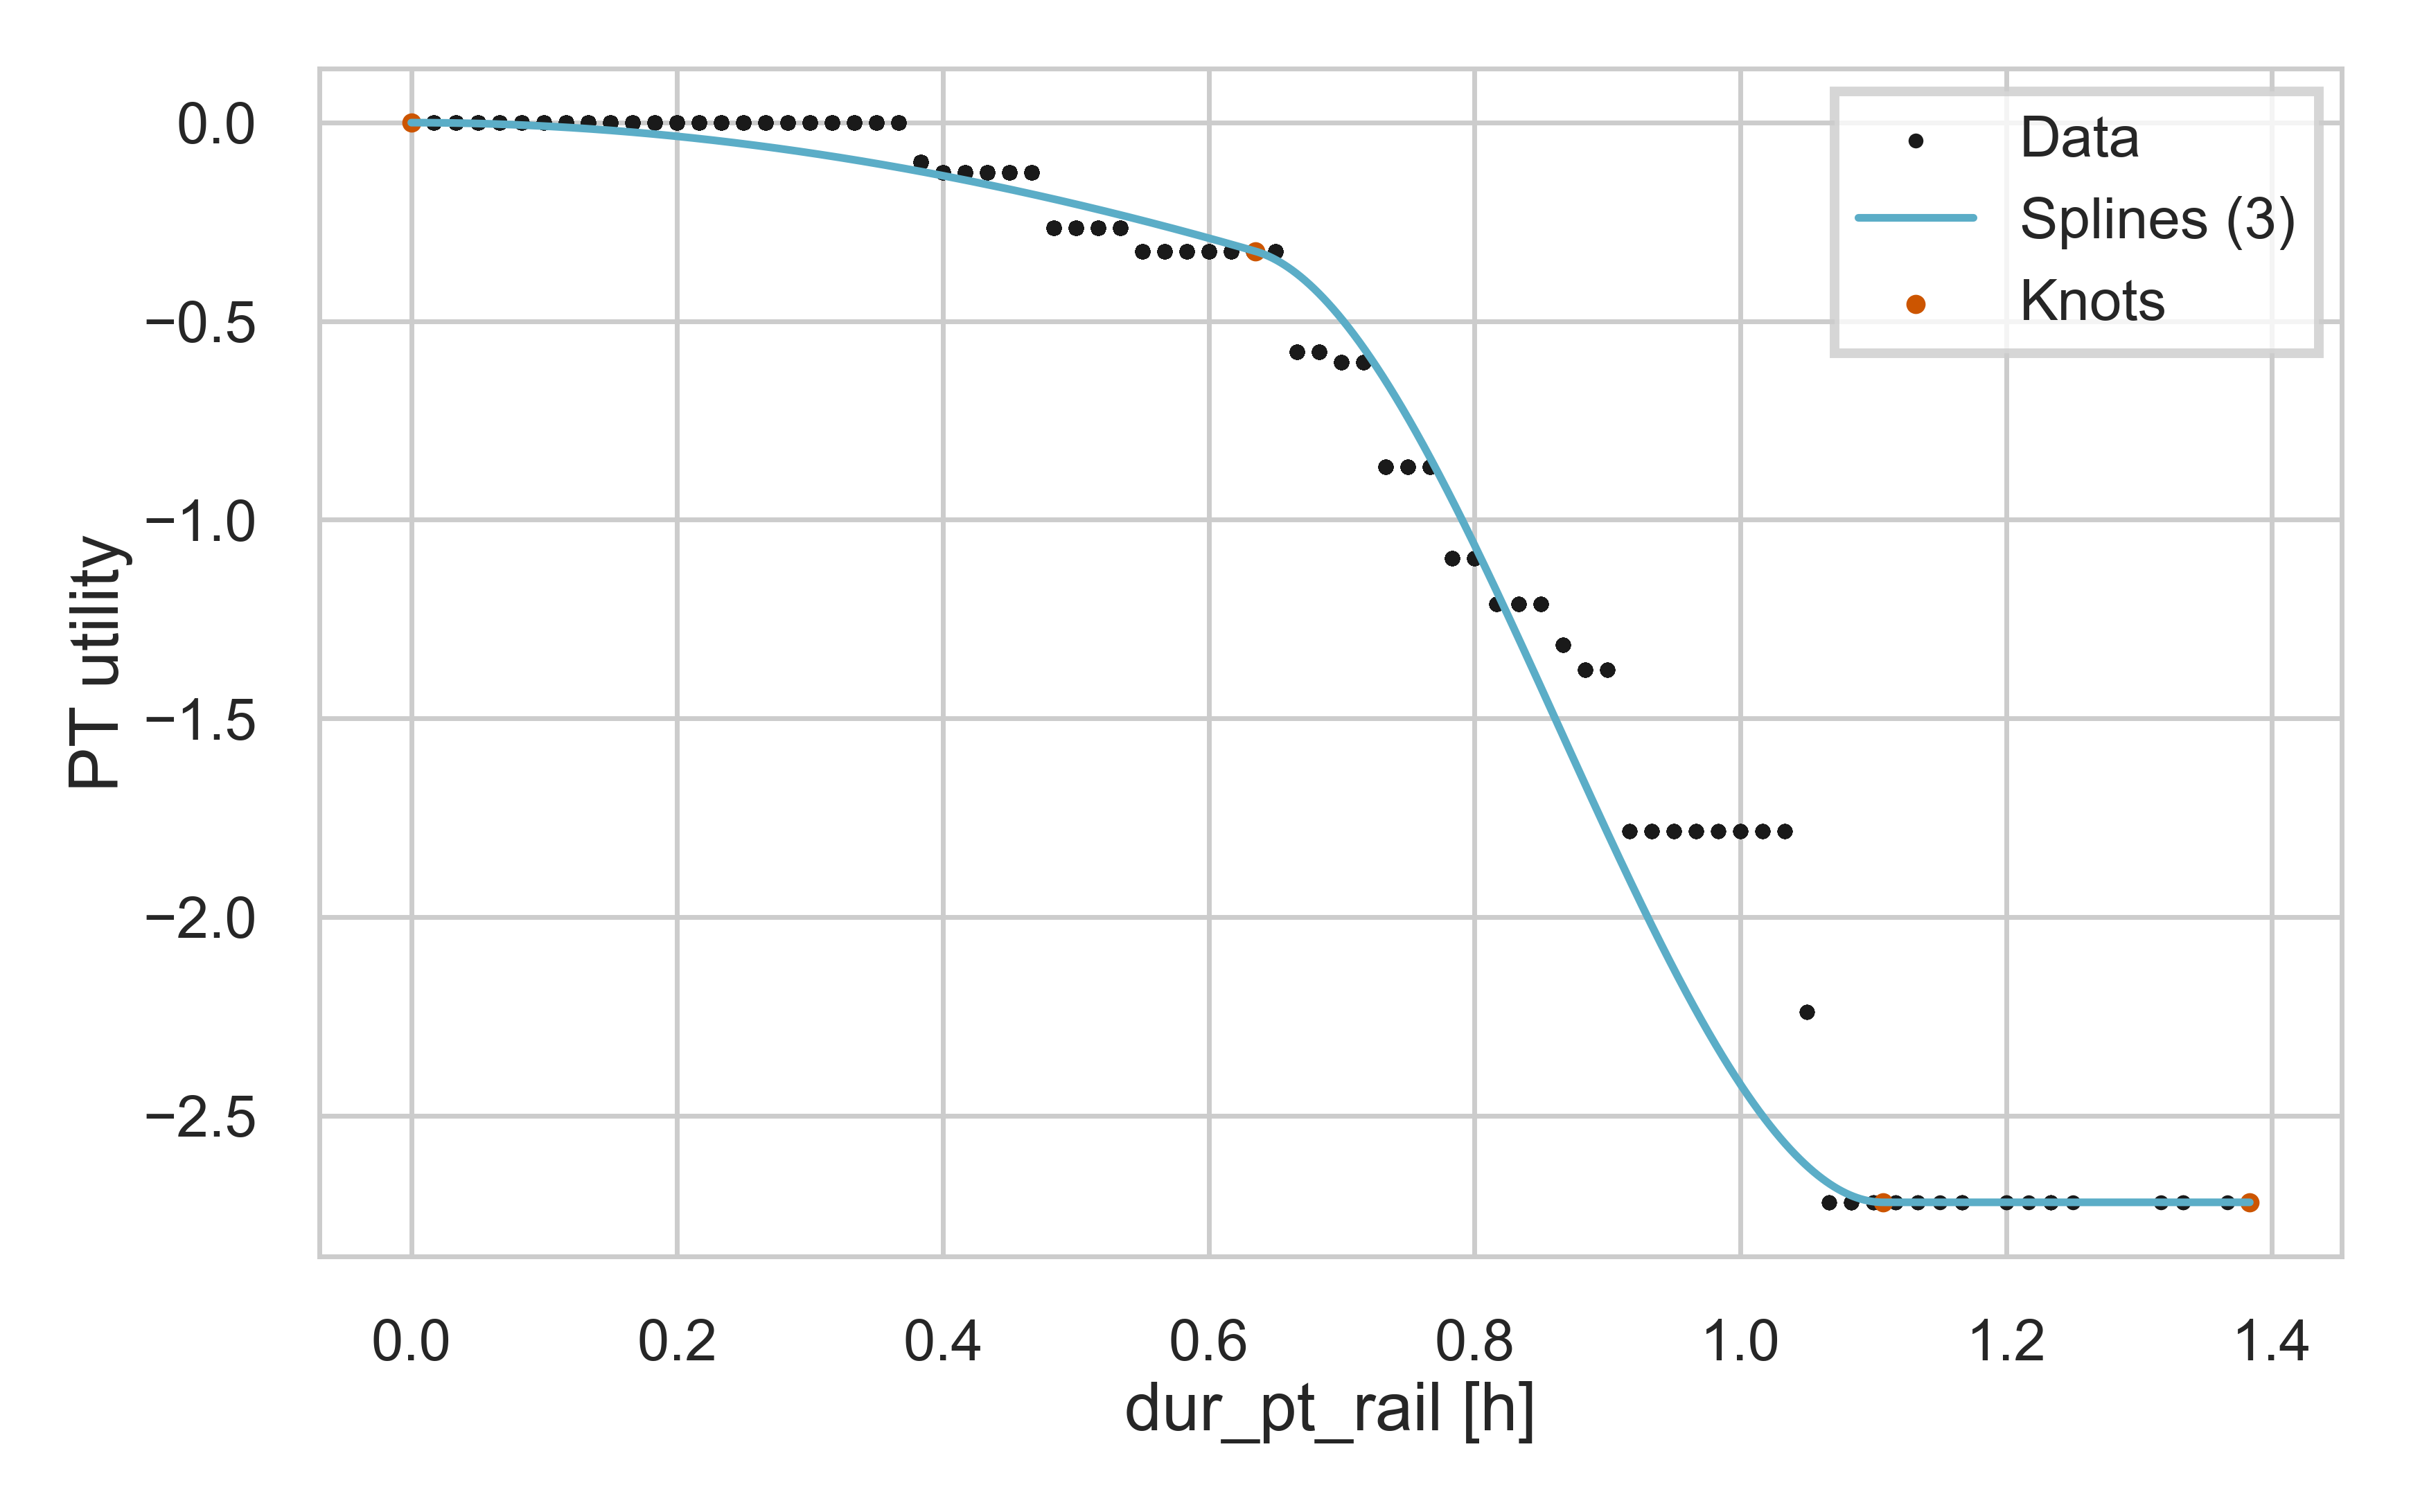

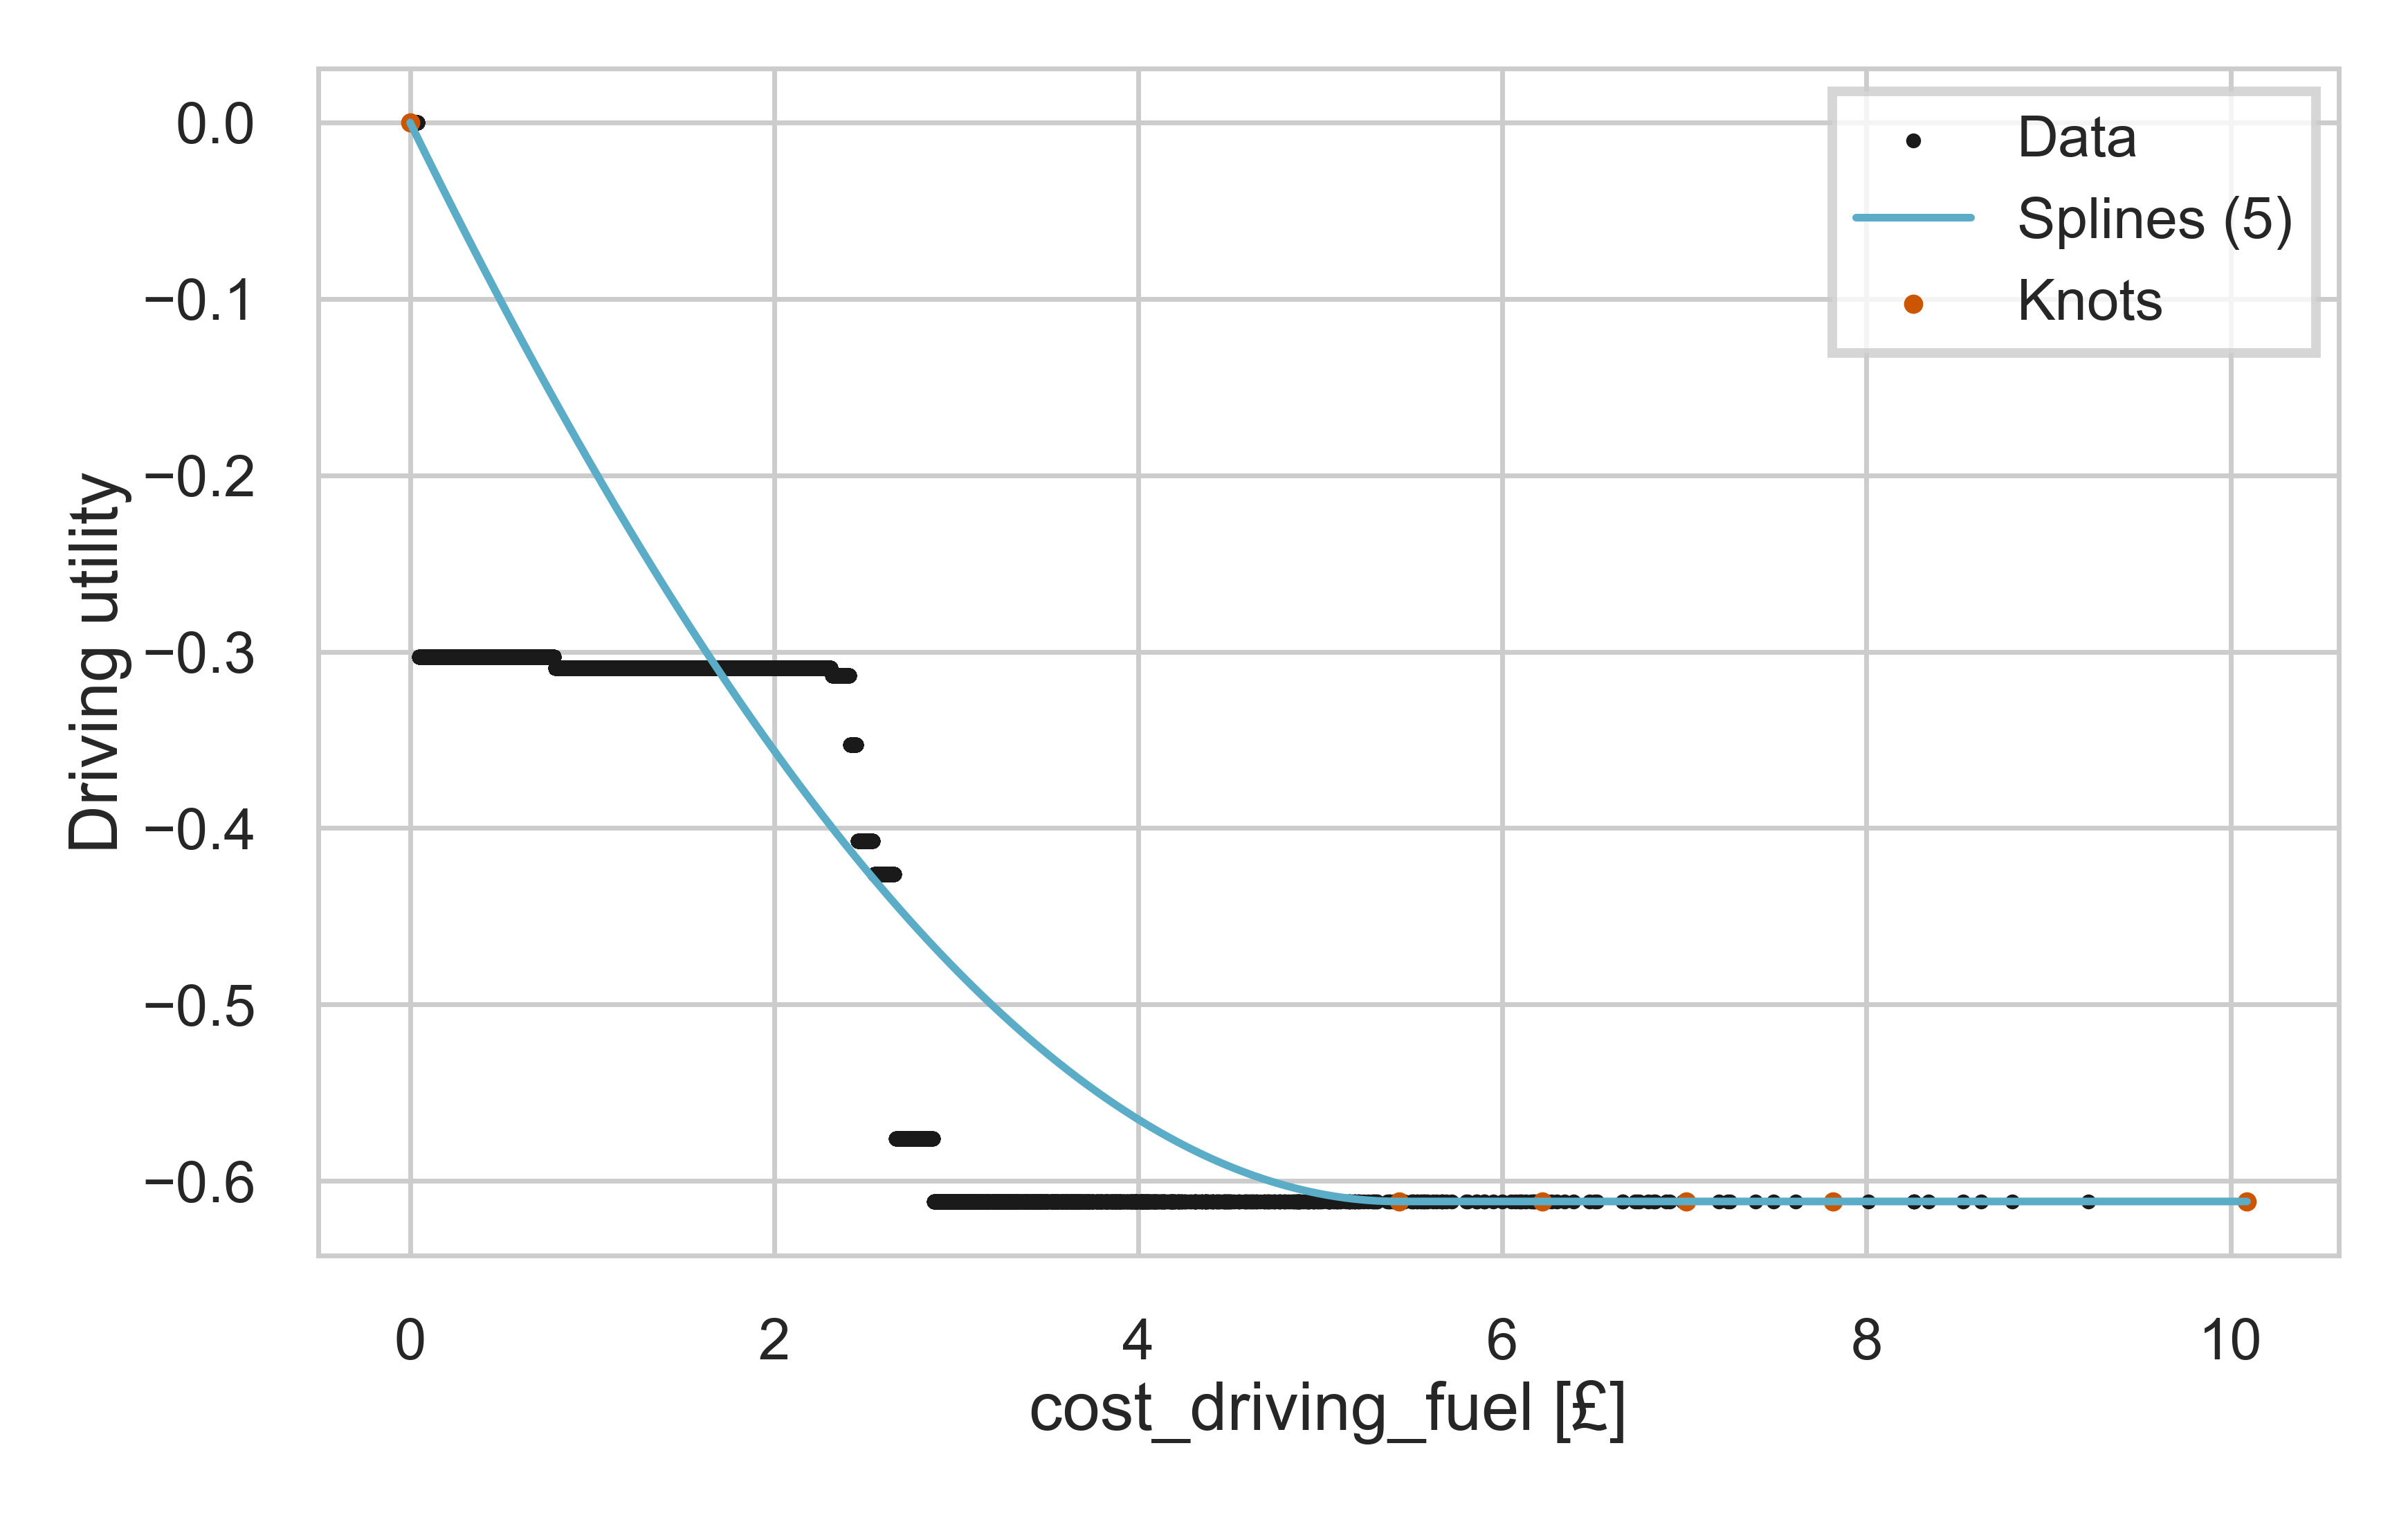

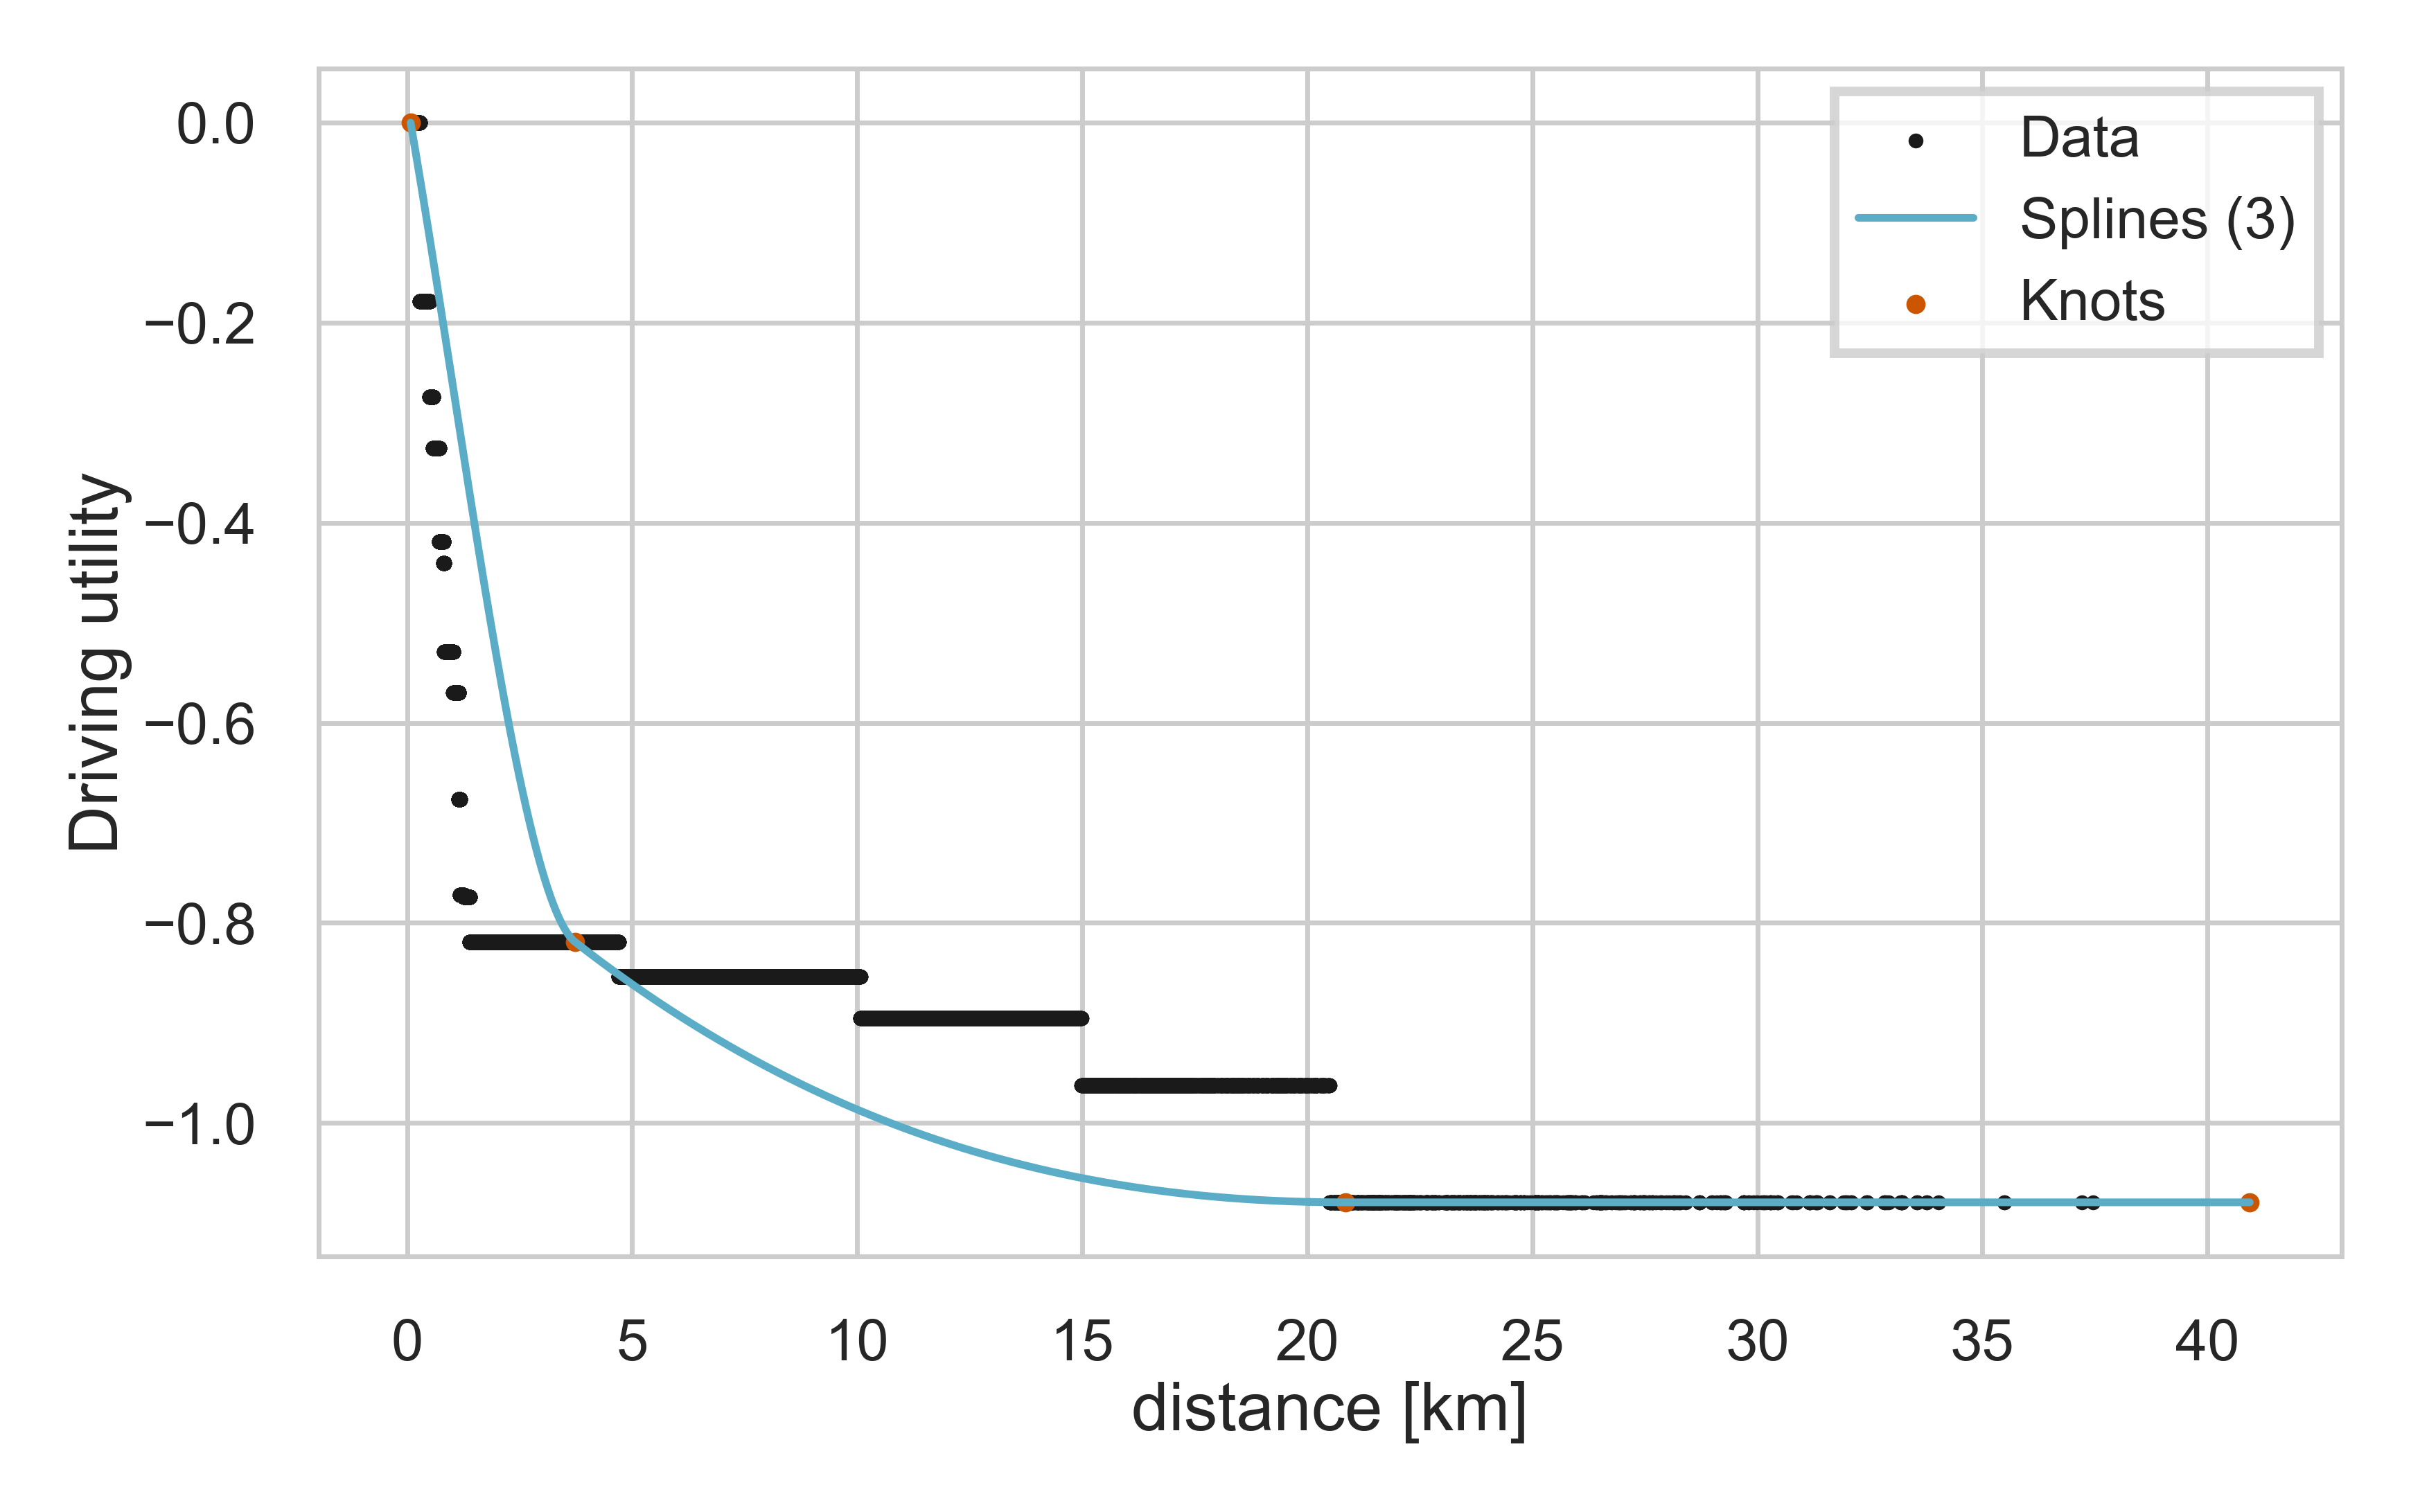

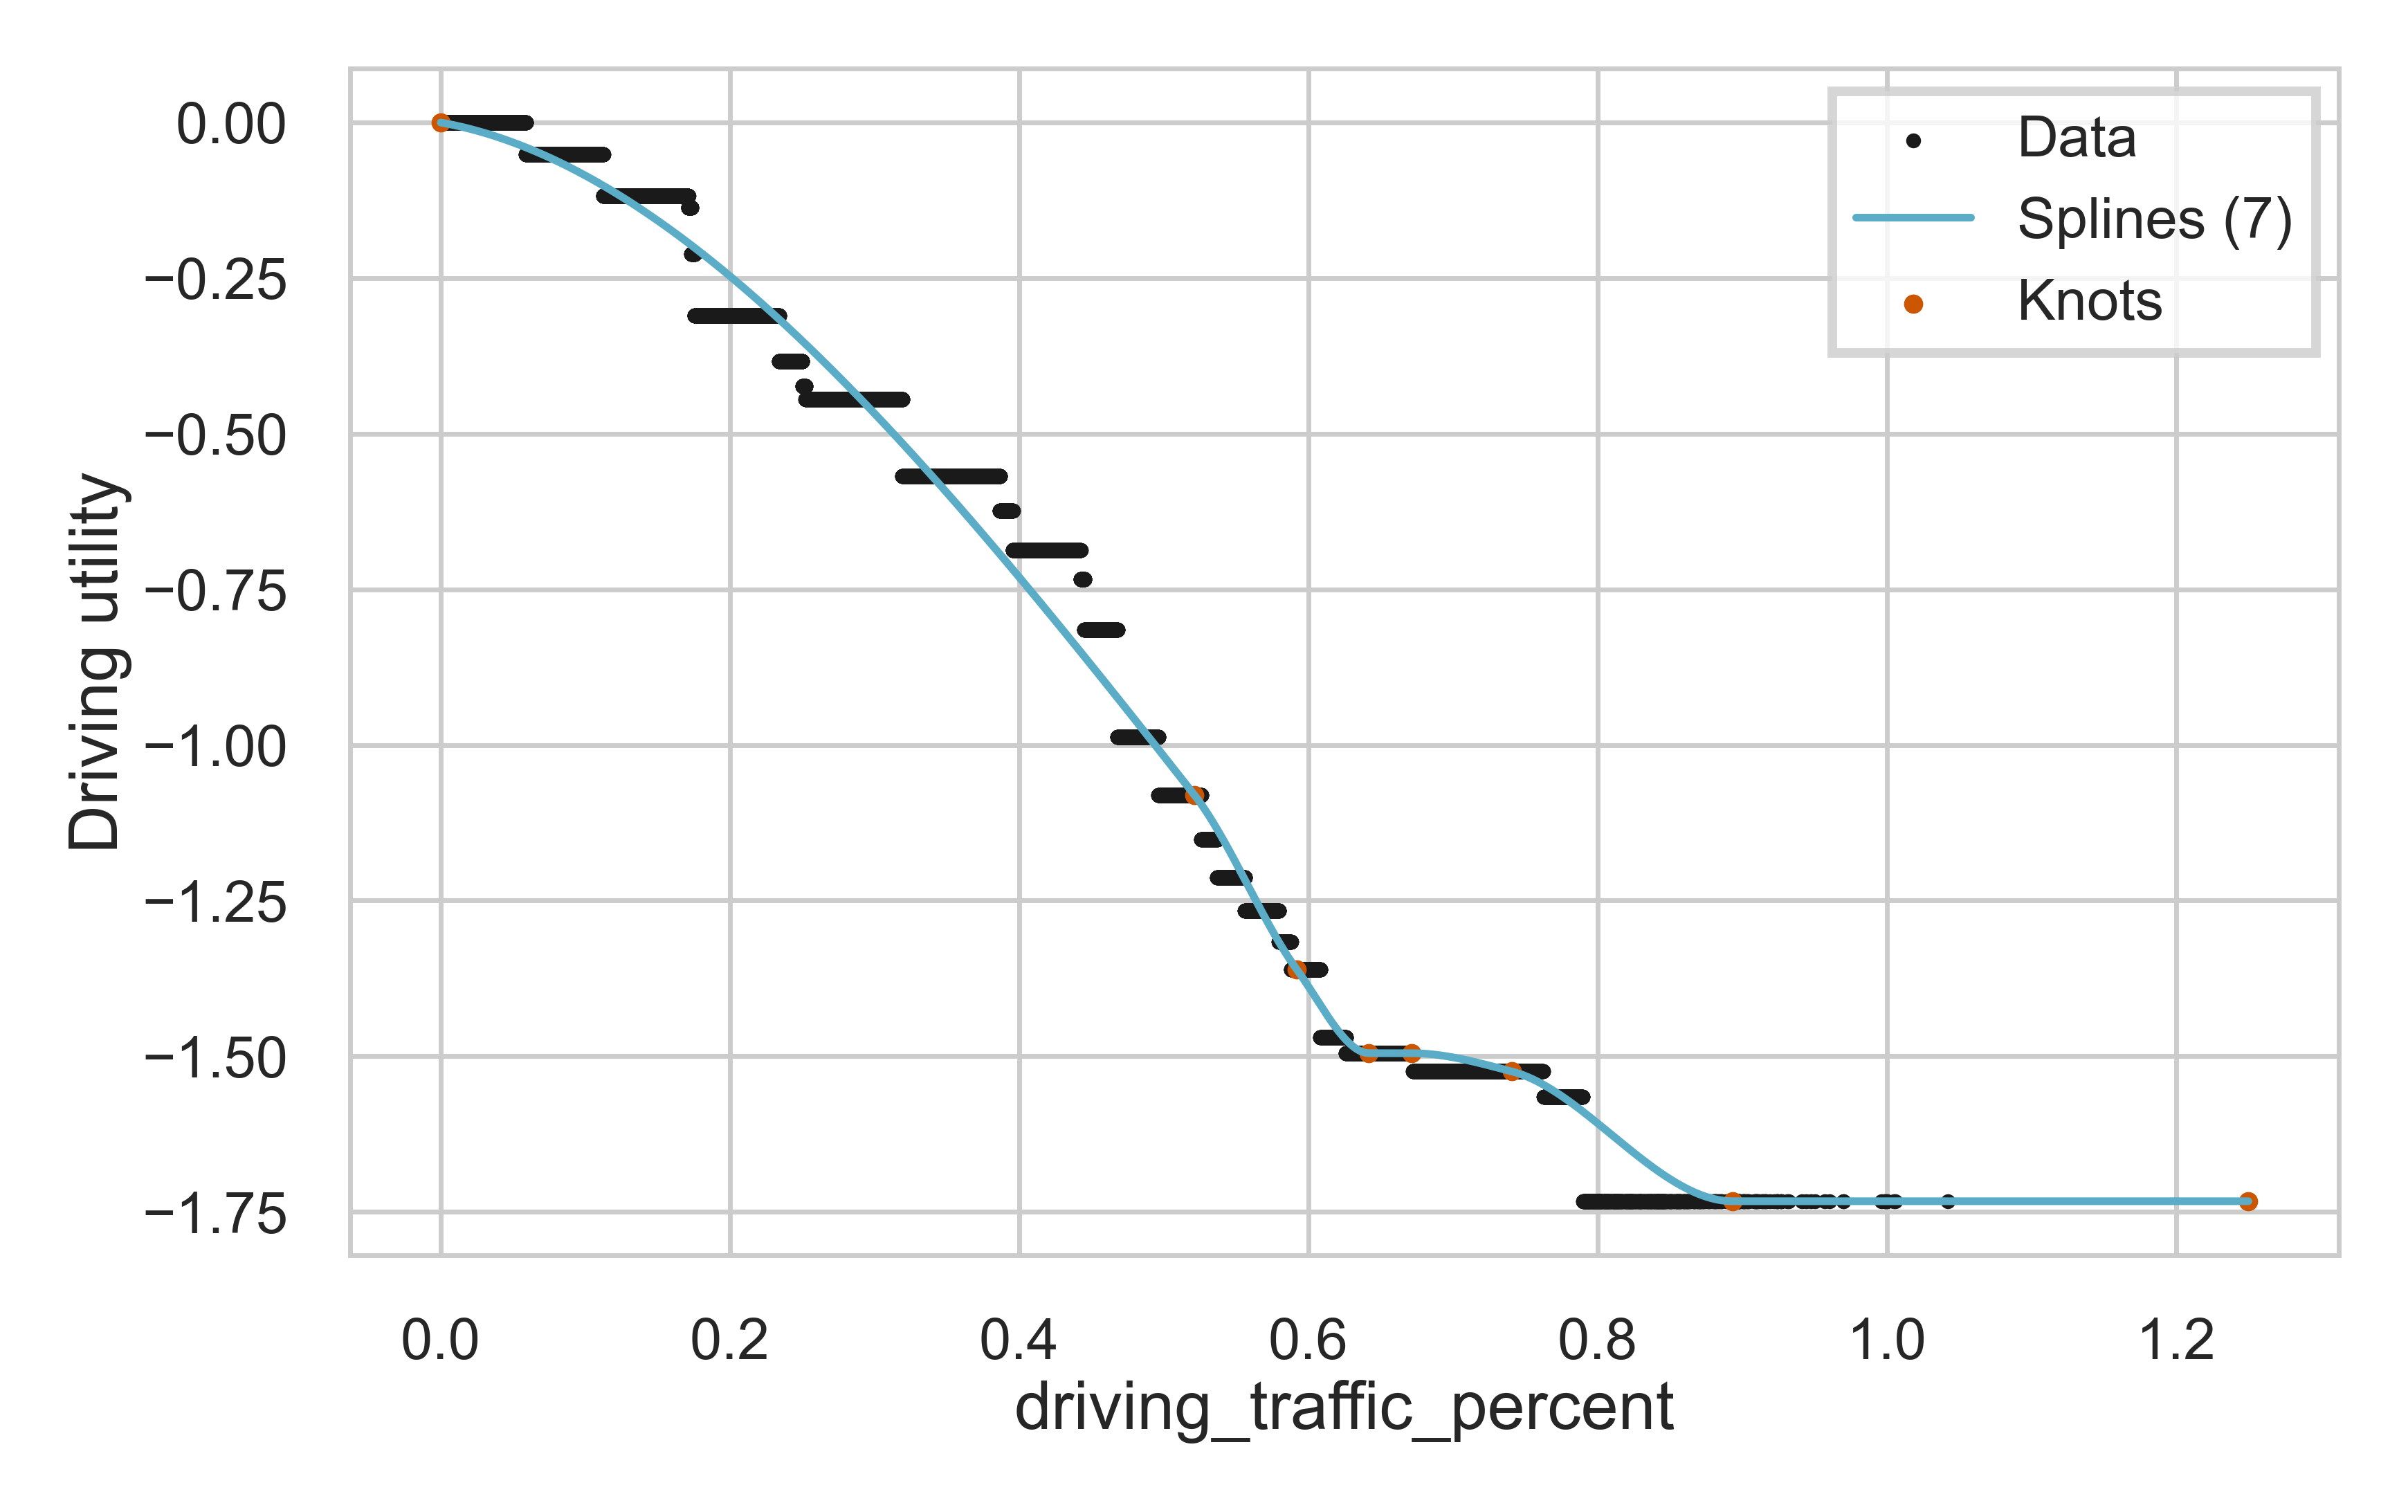

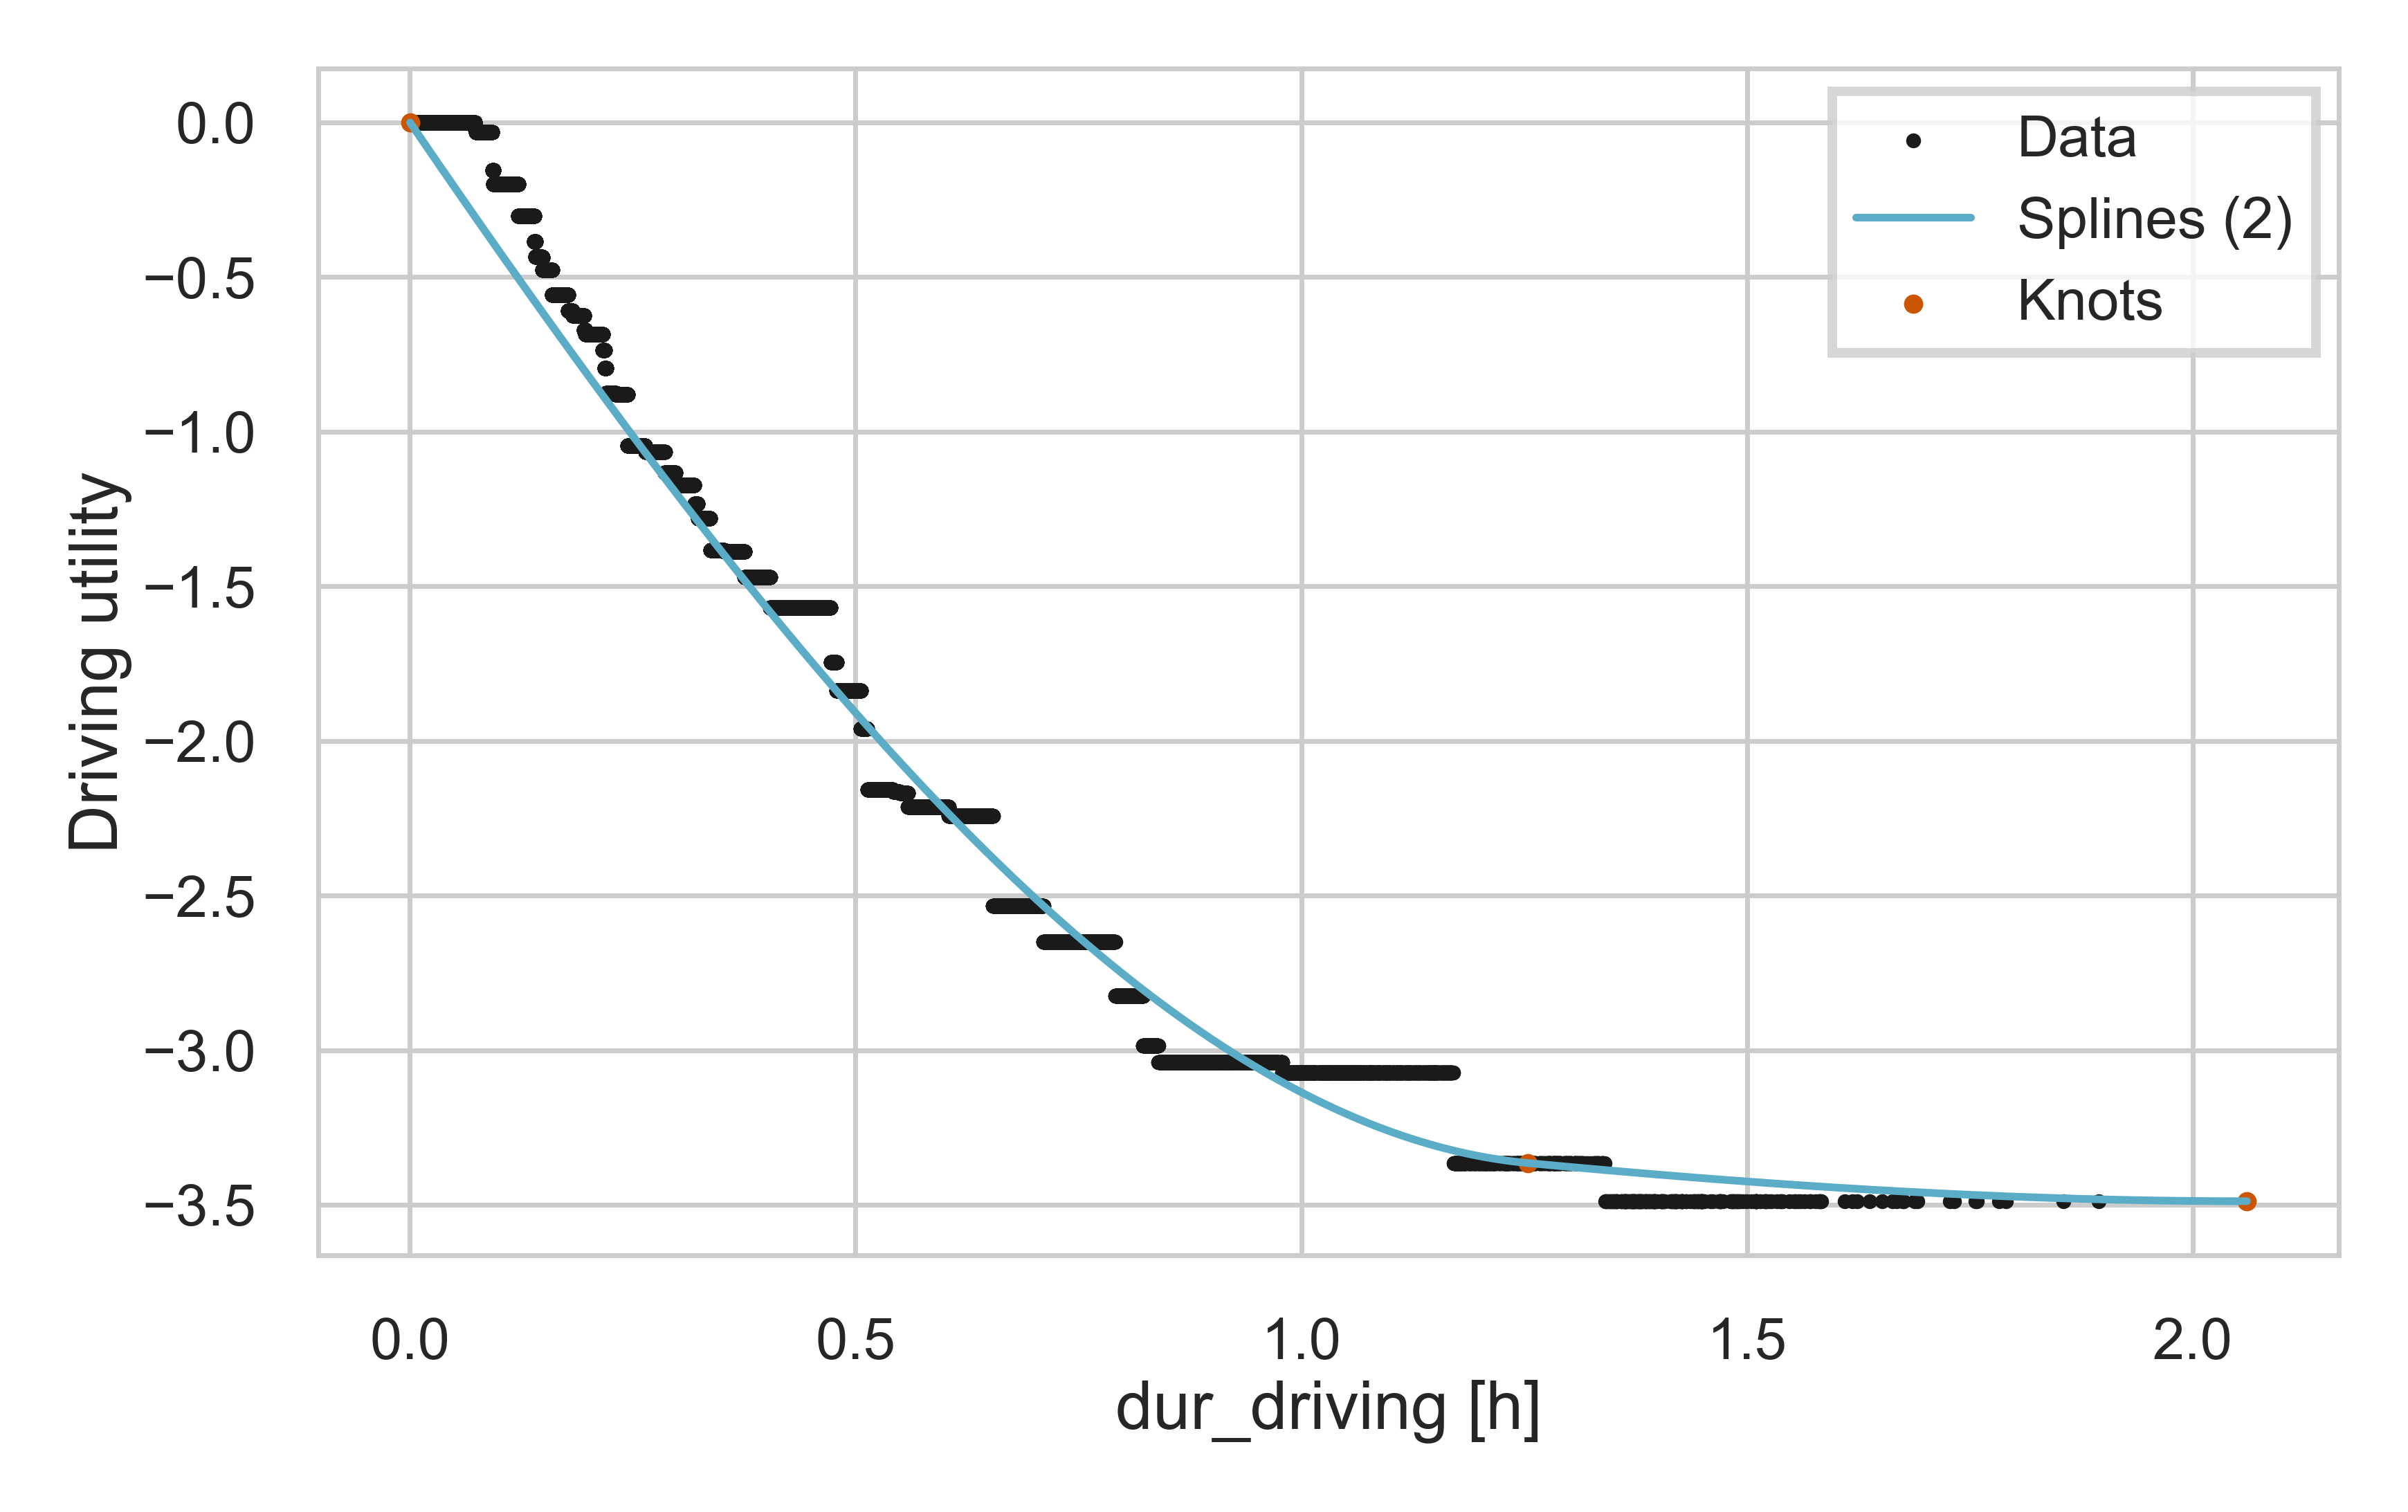

In [ ]:
best_splines = spline_collection
utility_names = {'0':'Walking', '1':'Cycling', '2':'PT', '3':'Driving'}
plot_spline(LPMC_model_fully_trained,LPMC_train,best_splines, utility_names, x_knots_dict=x_knots_dict, lpmc_tt_cost=True)

## Plotting the value of time

Using the smoothed utility functions, we can compute the value of time for the population, and per attributes. The results vary slightly from the paper du to the differences in the optimisation process.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\utility_plotting.py:1023: UserWarning: linewidths is ignored by contourf
  #axes.set_title(f'{utility_names[u]}')


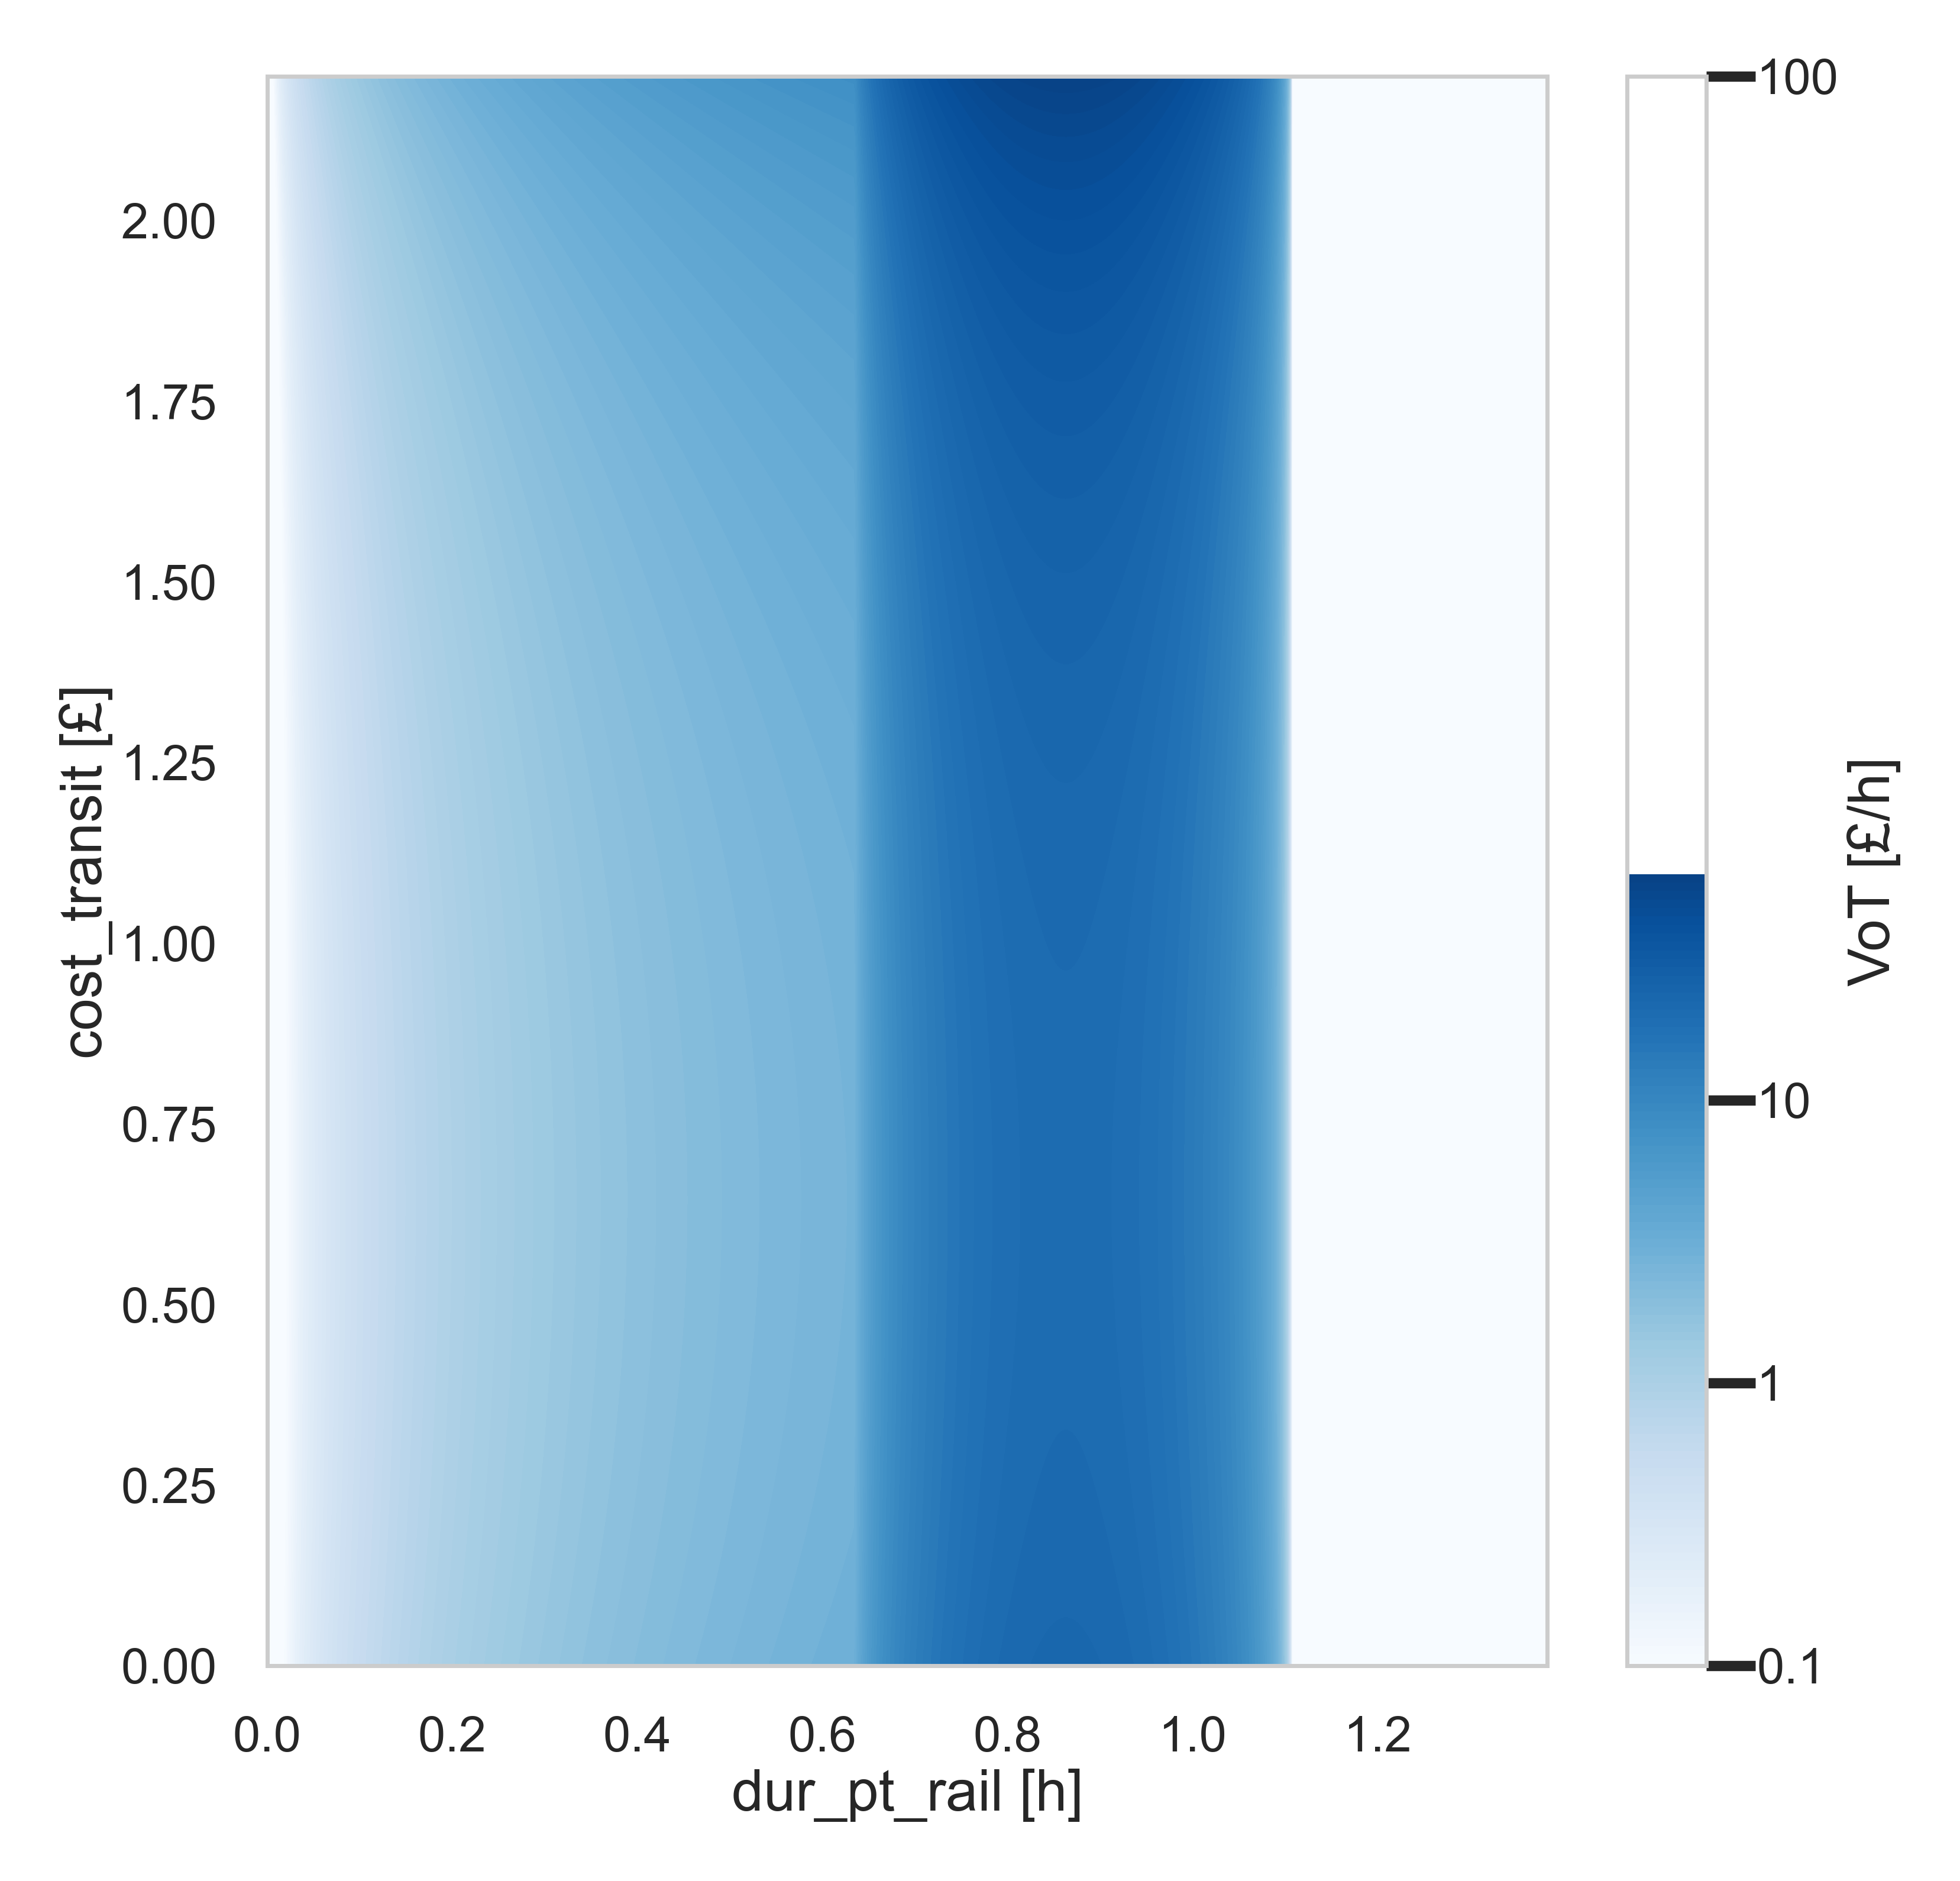

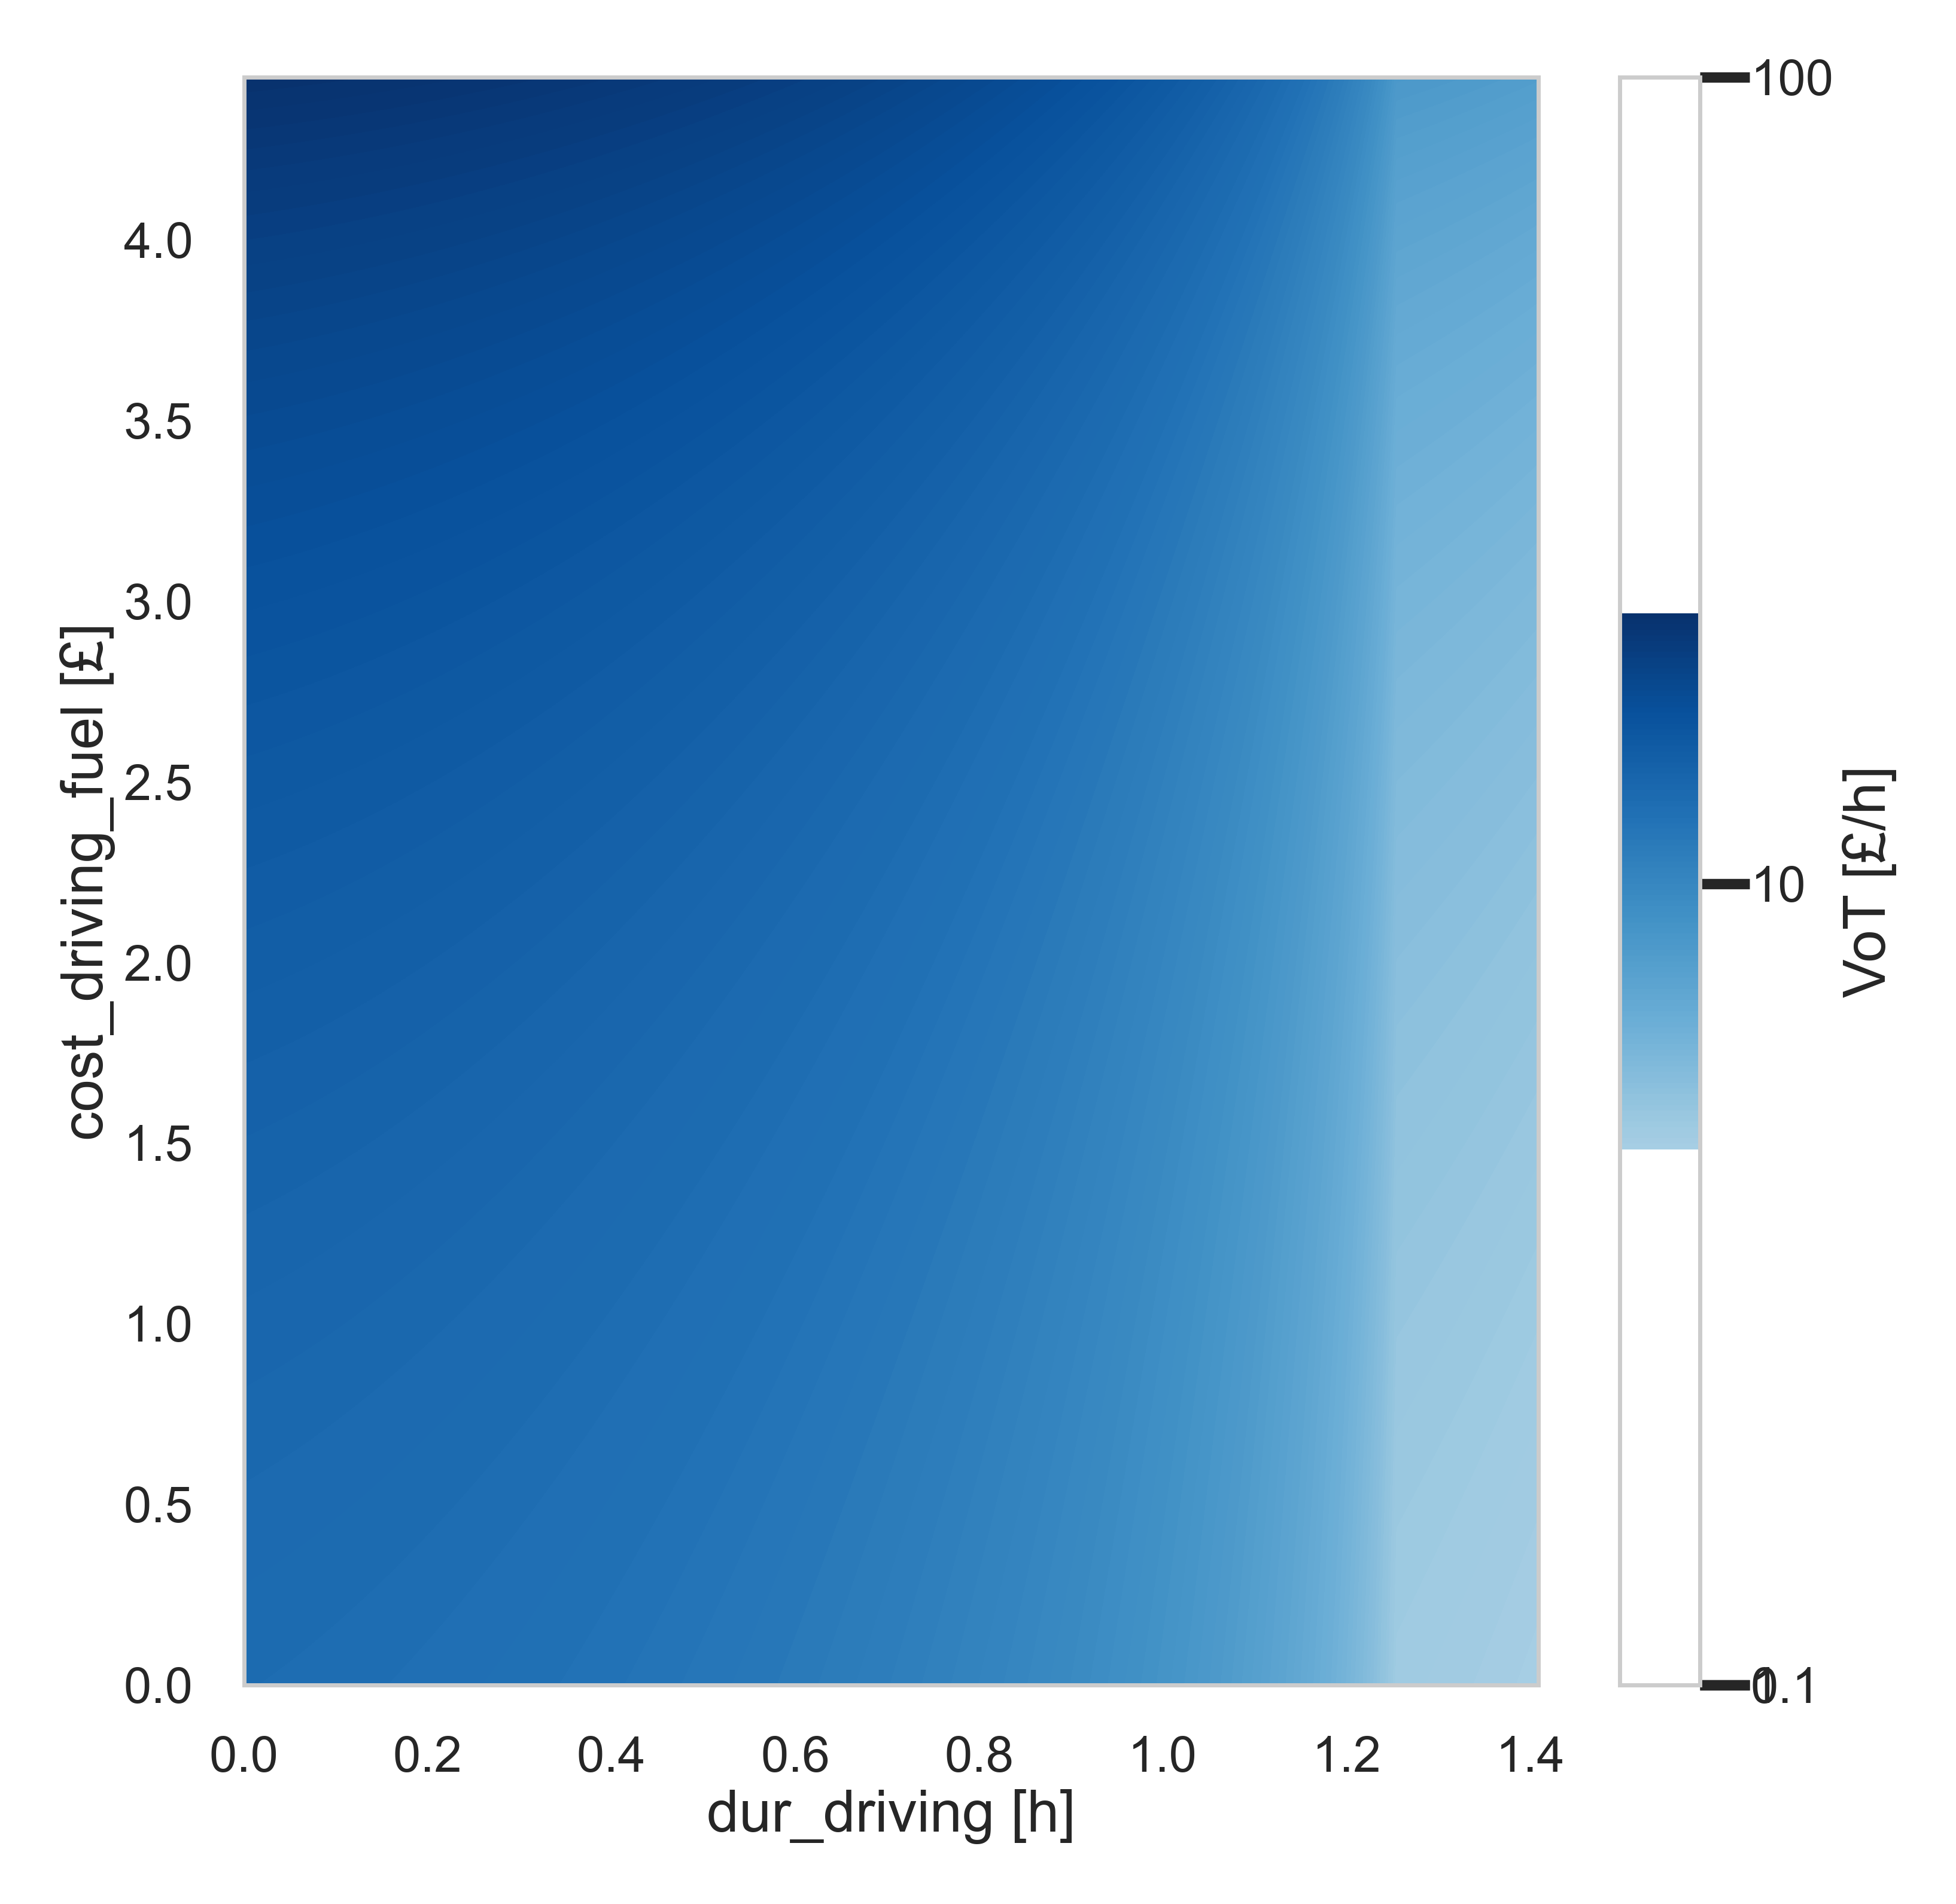

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\utility_plotting.py:1081: RuntimeWarning: divide by zero encountered in divide
  limited_VoT_pop = filtered_VoT_pop[(filtered_VoT_pop>0) & (filtered_VoT_pop < np.quantile(filtered_VoT_pop, 0.99))]
c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\utility_plotting.py:1081: RuntimeWarning: invalid value encountered in divide
  limited_VoT_pop = filtered_VoT_pop[(filtered_VoT_pop>0) & (filtered_VoT_pop < np.quantile(filtered_VoT_pop, 0.99))]


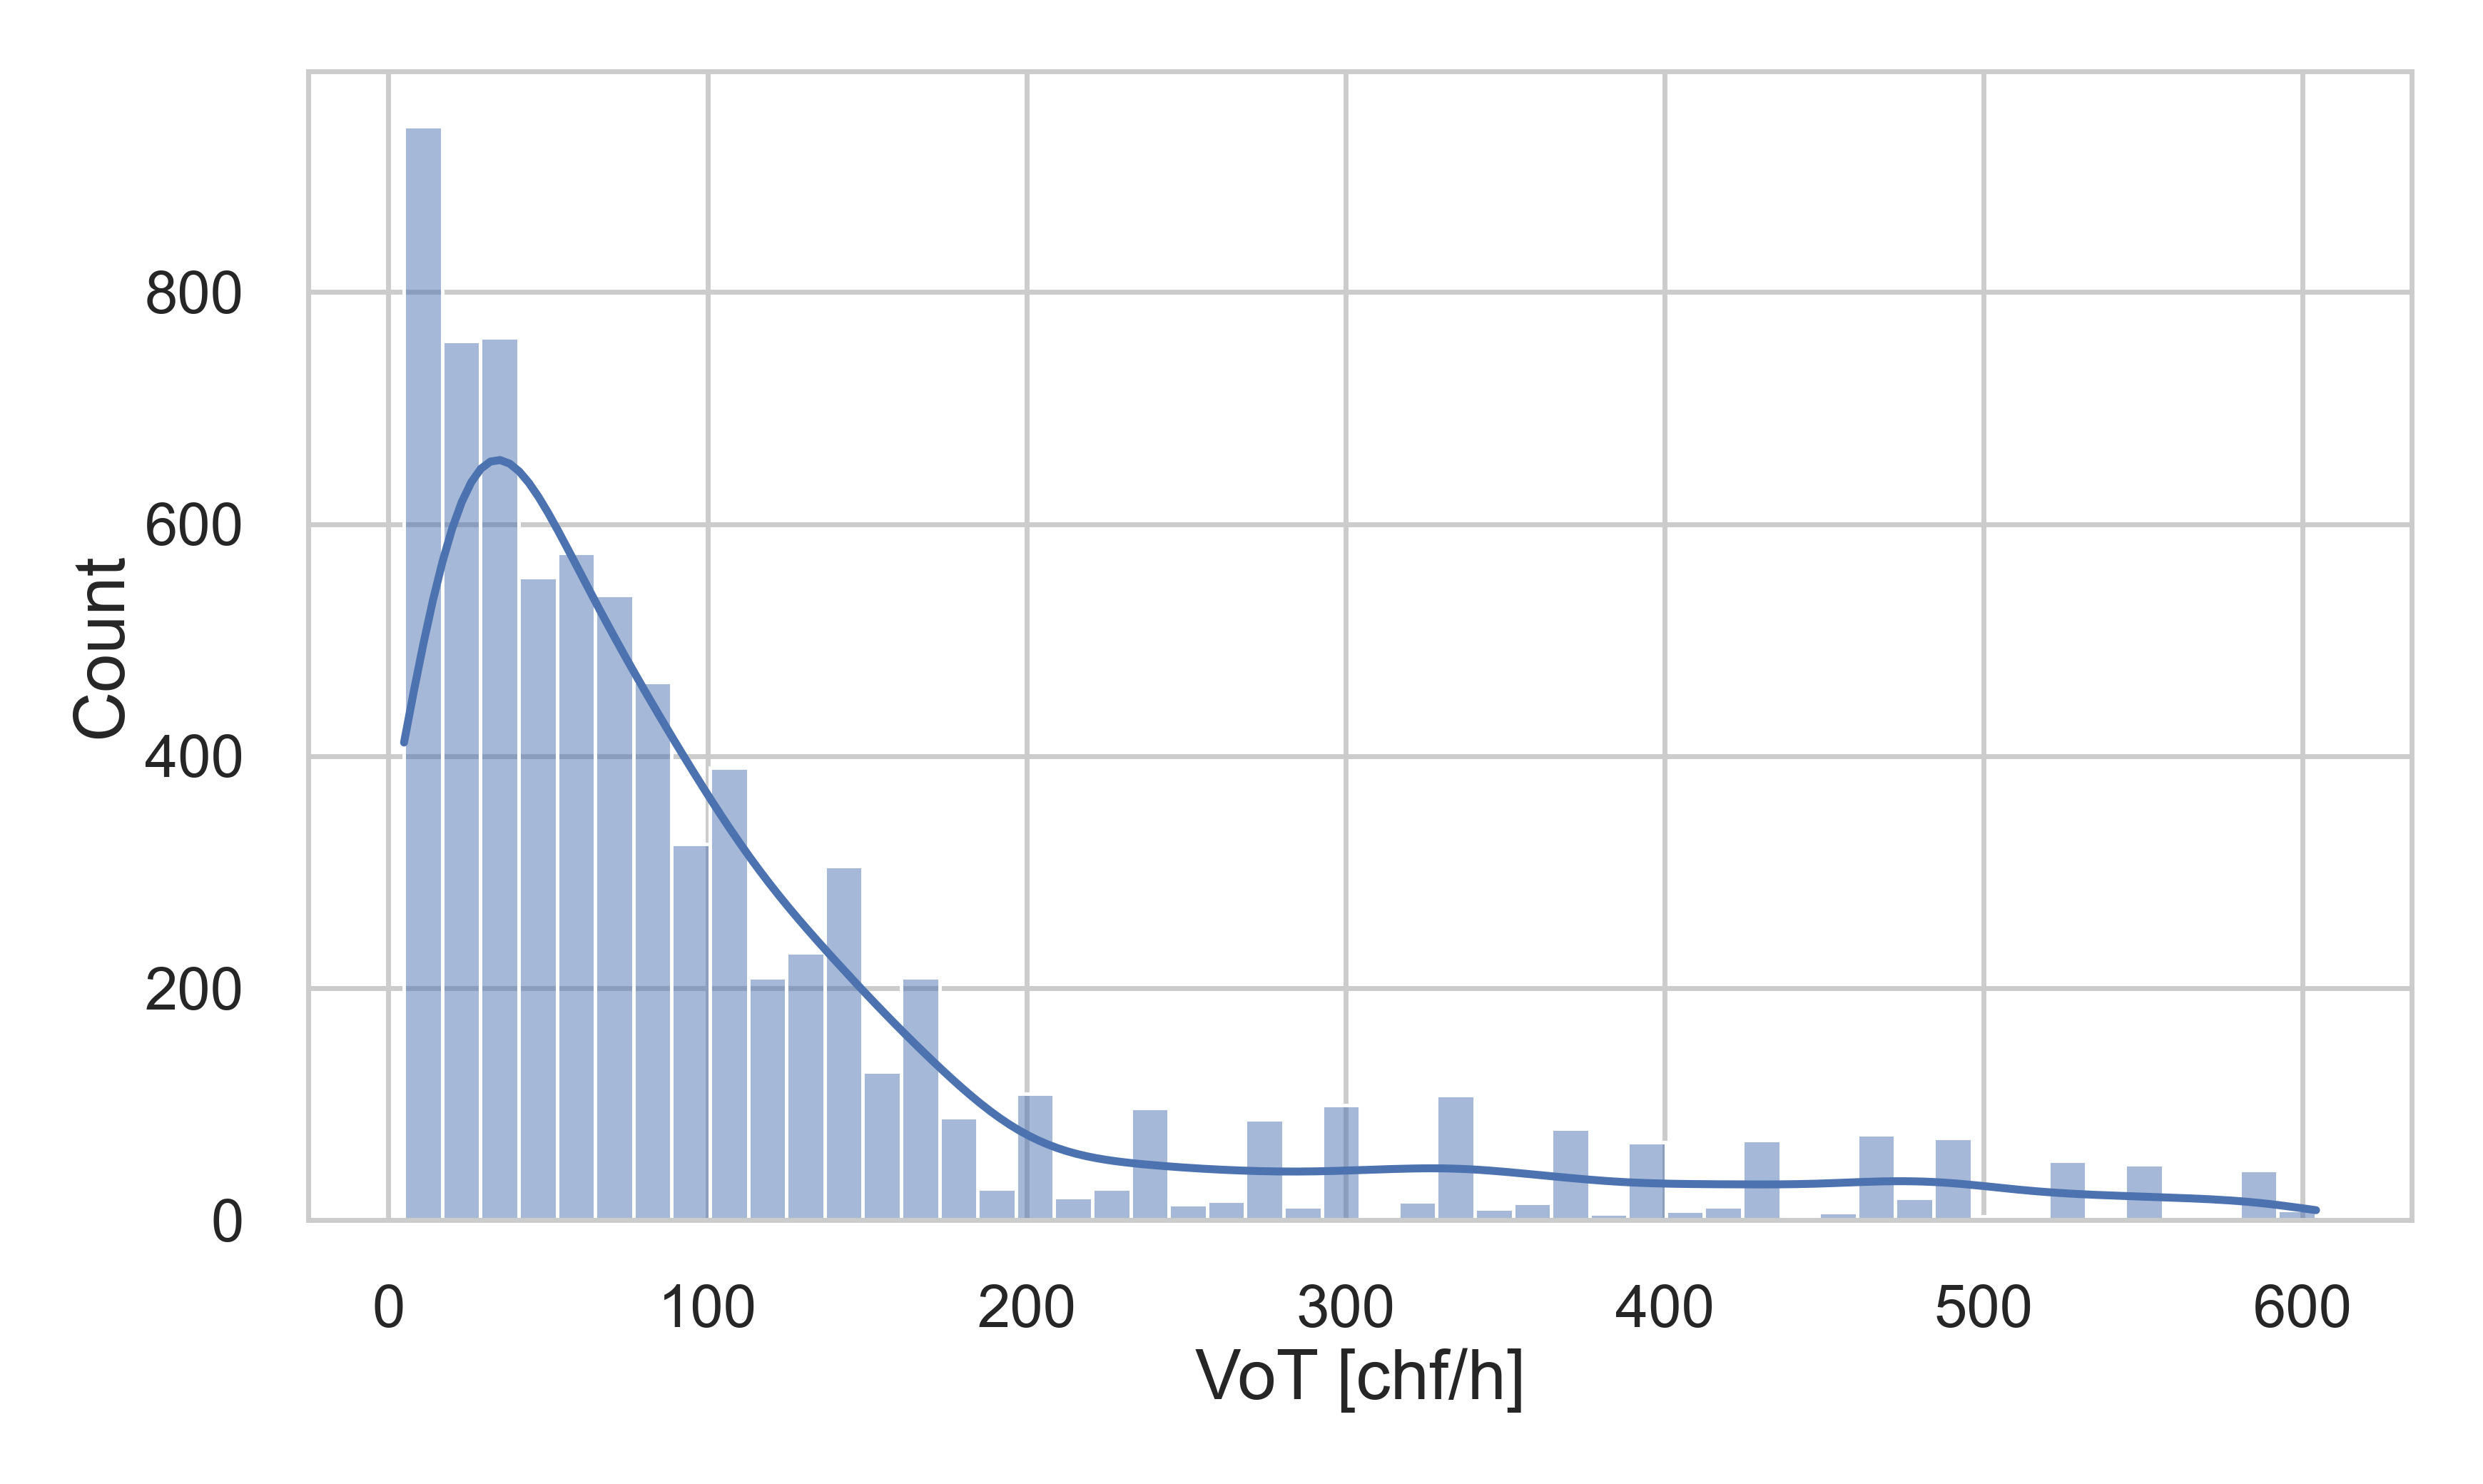

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\utility_plotting.py:1081: RuntimeWarning: divide by zero encountered in divide
  limited_VoT_pop = filtered_VoT_pop[(filtered_VoT_pop>0) & (filtered_VoT_pop < np.quantile(filtered_VoT_pop, 0.99))]


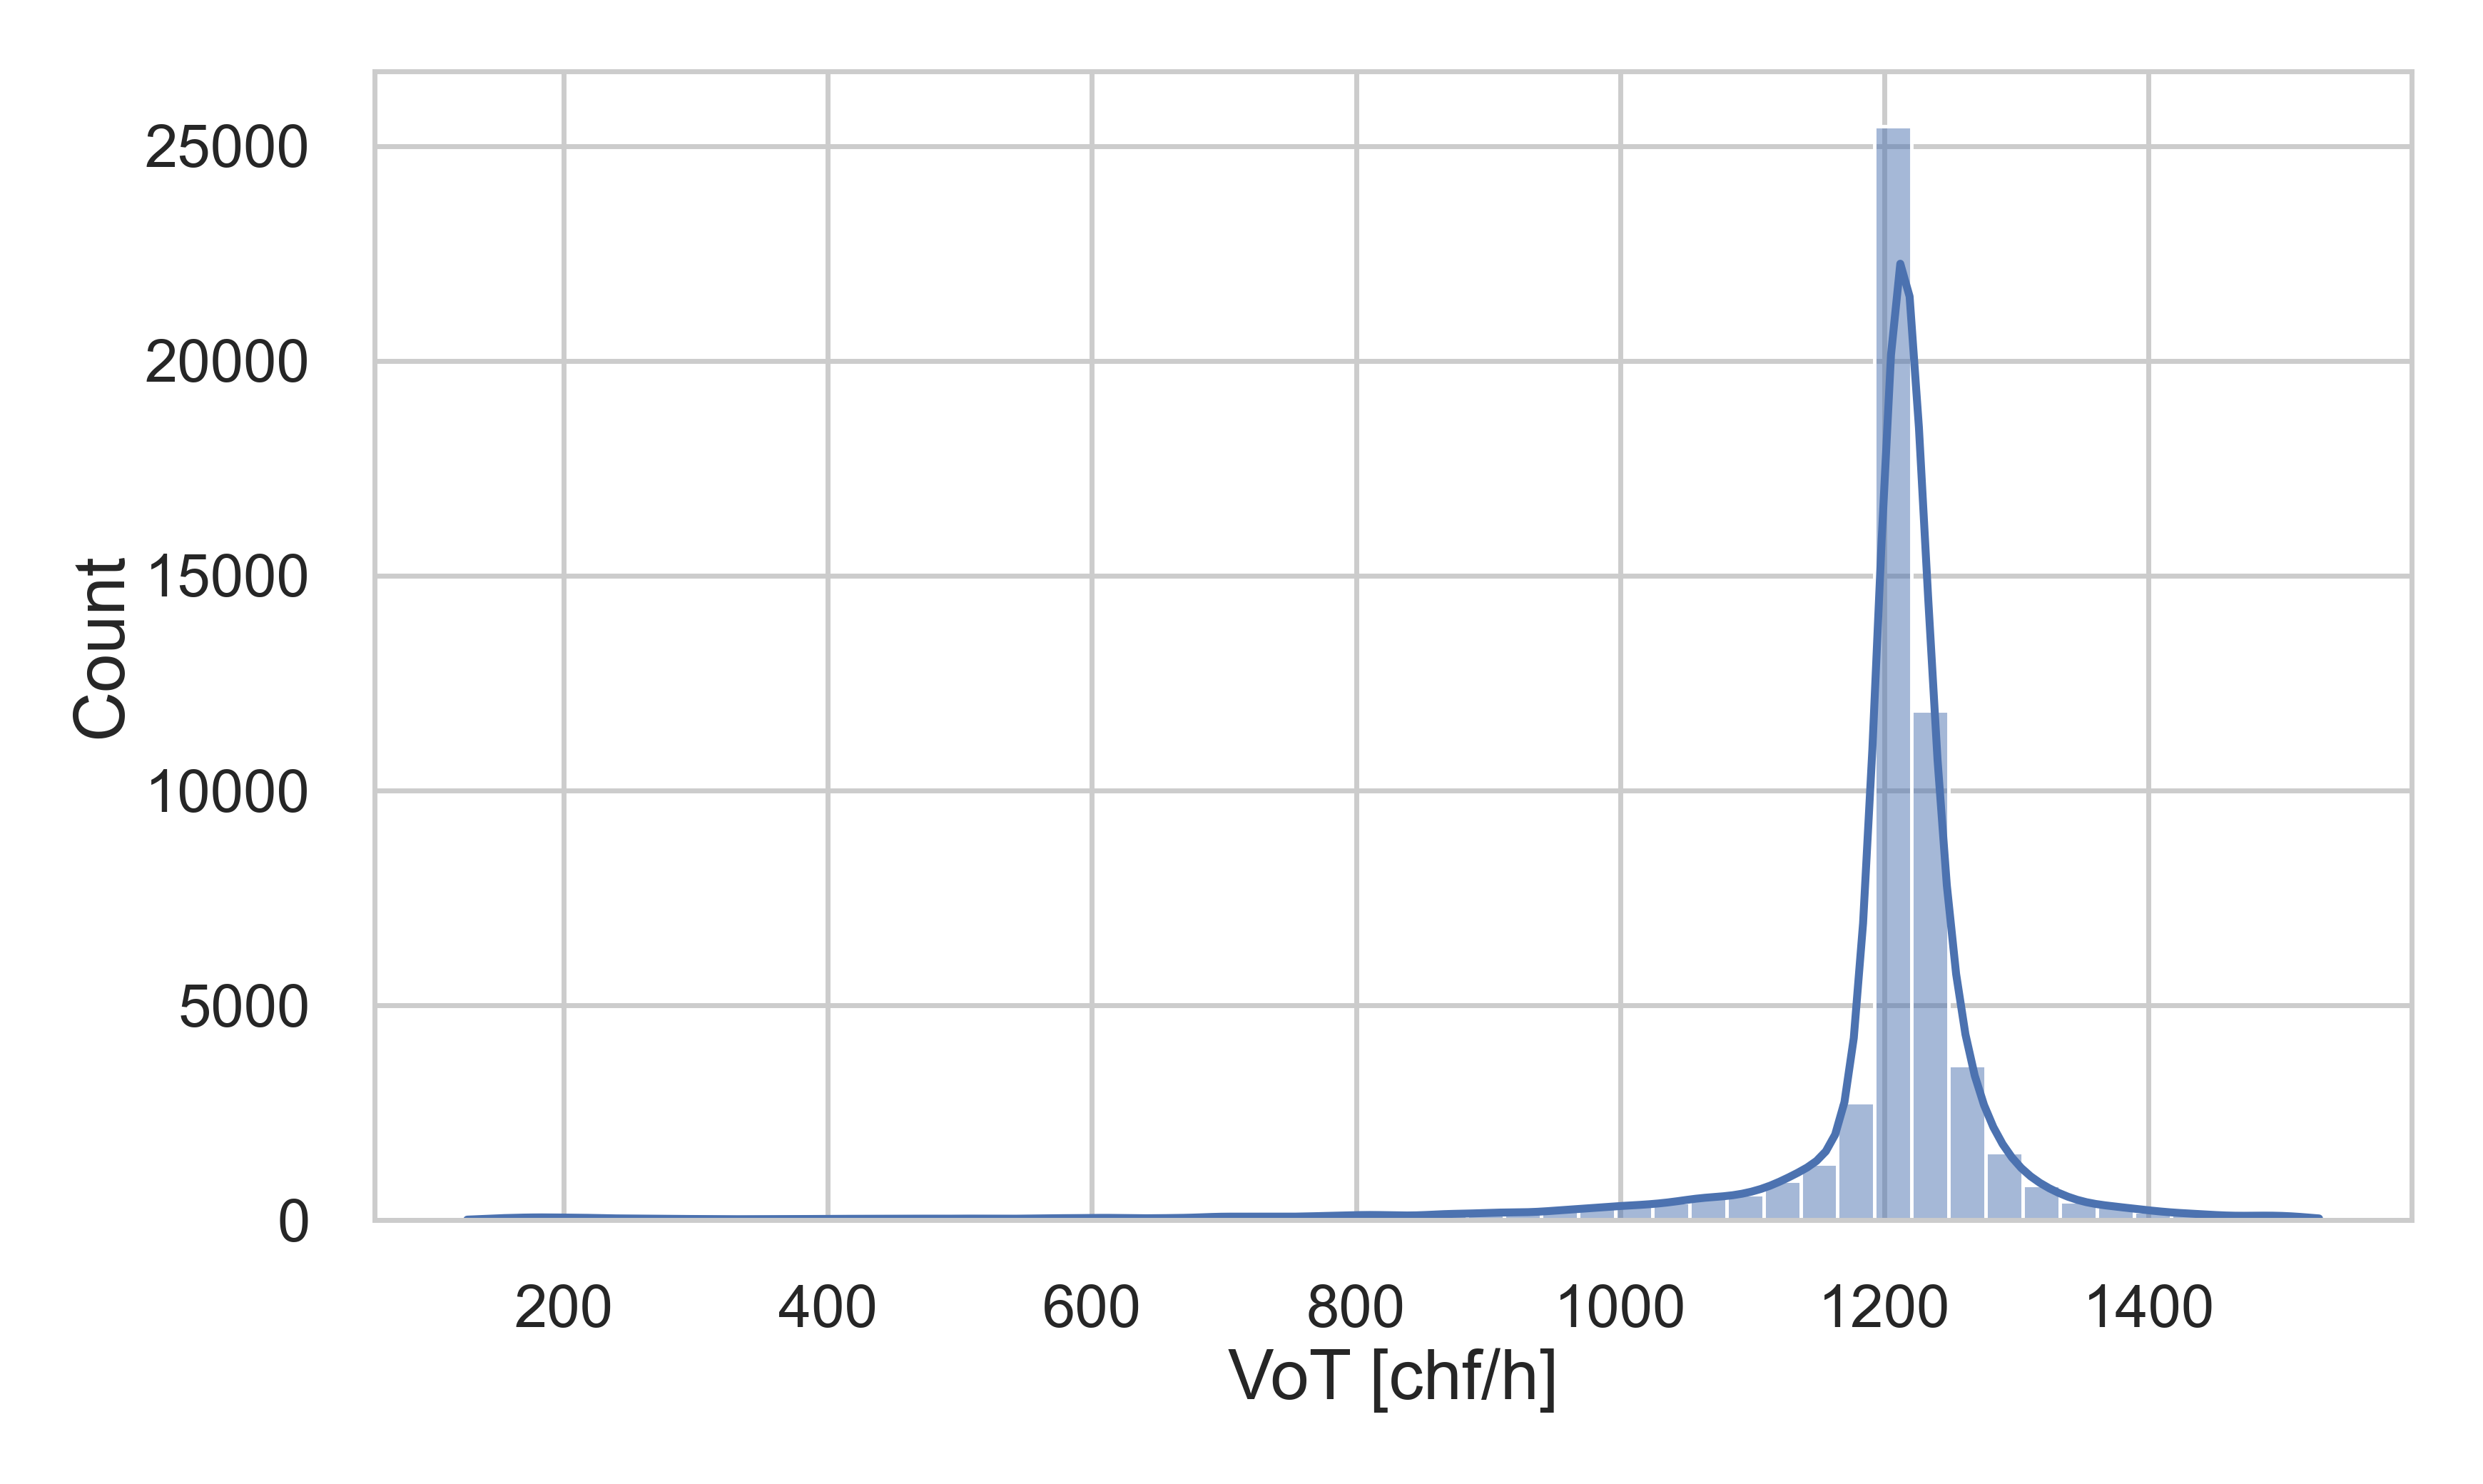

In [ ]:
attribute_VoT =  {'2': ('dur_pt_rail', 'cost_transit'), '3':('dur_driving', 'cost_driving_fuel')}
draw_range = {'2':{'dur_pt_rail':(0,1.383), 'cost_transit':(0, 2.2)}, '3':{'dur_driving':(0, 1.409), 'cost_driving_fuel':(0, 4.45)}}

plot_VoT(LPMC_train, util_collection, attribute_VoT, utility_names={'0': 'Walking', '1': 'Cycling', '2':'Rail', '3':'Driving'}, draw_range=draw_range, save_figure=False)

plot_pop_VoT(LPMC_train, util_collection, attribute_VoT, save_figure=False)

# References

Salvadé, N., & Hillel, T. (2024). Rumboost: Gradient Boosted Random Utility Models. *arXiv preprint [arXiv:2401.11954](https://arxiv.org/abs/2401.11954)*

Hillel, T., Elshafie, M.Z.E.B., Jin, Y., 2018. Recreating passenger mode choice-sets for transport simulation: A case study of London, UK. Proceedings of the Institution of Civil Engineers - Smart Infrastructure and Construction 171, 29–42. https://doi.org/10.1680/jsmic.17.00018